In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload

## Some preliminary info.

In [2]:
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/2023-01-18'
os.chdir(location)
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

In [3]:
blaze_dir = 'Blaze-data'

In [4]:
dir_name = 'Corr-data'
test = pf.open(dir_name+'/'+sorted(os.listdir(dir_name))[10])

test.info()

Filename: Corr-data/r.NIRPS.2023-01-18T17:07:21.603_S2D_BLAZE_A_CORR.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1044   ()      
  1  SCIDATA       1 ImageHDU        10   (4084, 71)   float32   
  2  ERRDATA       1 ImageHDU        10   (4084, 71)   float32   
  3  QUALDATA      1 ImageHDU        12   (4084, 71)   int16 (rescales to uint16)   
  4  WAVEDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  5  WAVEDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   
  6  DLLDATA_VAC_BARY    1 ImageHDU        10   (4084, 71)   float64   
  7  DLLDATA_AIR_BARY    1 ImageHDU        10   (4084, 71)   float64   
  8  SCIDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
  9  SCIDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
 10  ERRDATA_CORR    1 ImageHDU         8   (4084, 71)   float64   
 11  TELLURIC      1 ImageHDU         8   (4084, 71)   float64   


In [5]:
test[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-02-16T13:38:29' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-LASILLA'        / European Southern Observatory                  
TELESCOP= 'ESO-3P6 '           / ESO <TEL>                                      
INSTRUME= 'NIRPS   '           / Instrument used.                               
OBJECT  = 'SUN,FP,G2V'         / Original target.                               
EXPTIME =              50.1597 / [s] Exposure time                              
MJD-OBS =     59962.71344448

In [6]:
CCF_dir_name = 'CCF_RV-data'
test_RV = pf.open(CCF_dir_name+'/'+sorted(os.listdir(CCF_dir_name))[10])


test_RV.info()
test_RV[0].header

Filename: CCF_RV-data/r.NIRPS.2023-01-18T17:07:21.603_CCF_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1069   ()      
  1  SCIDATA       1 ImageHDU        10   (41, 72)   float32   
  2  ERRDATA       1 ImageHDU        10   (41, 72)   float32   
  3  QUALDATA      1 ImageHDU        10   (41, 72)   int32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2023-03-11T09:59:44' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-LASILLA'        / European Southern Observatory                  
TELESCOP= 'ESO-3P6 '           / ESO <TEL>                                      
INSTRUME= 'NIRPS   '           / Instrument used.                               
OBJECT  = 'SUN,FP,G2V'         / Original target.                               
EXPTIME =              50.1597 / [s] Exposure time                              
MJD-OBS =     59962.71344448

# Studying solar spectrum of one day (looking at all times)

In [7]:
reload(AF)

#Extracting the data
tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_BIS_SPAN, tot_H2O, tot_O2, tot_CO2, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)




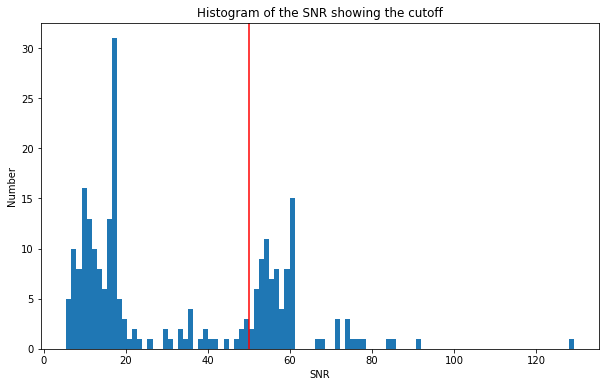

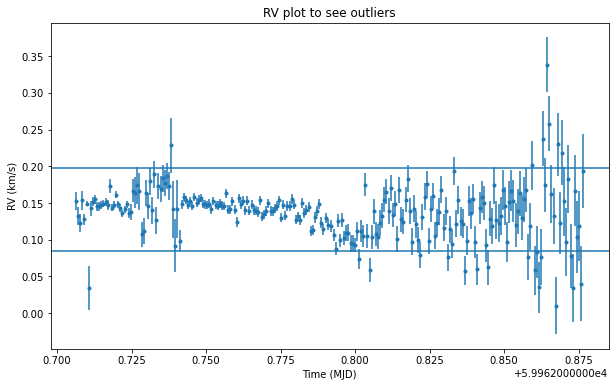

In [15]:
cut = 50
threshold = 0.4

plt.figure(figsize=[10, 6])
plt.hist(tot_SNR[tot_SNR>0], bins=100)
plt.axvline(cut, color='r')
plt.xlabel('SNR')
plt.ylabel('Number')
plt.title('Histogram of the SNR showing the cutoff')
plt.show()

plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, tot_RV, yerr = tot_RV_err, fmt='.')
plt.axhline((1+threshold)*np.median(np.abs(tot_RV)))
plt.axhline((1-threshold)*np.median(np.abs(tot_RV)))
plt.xlabel('Time (MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV plot to see outliers')
plt.show()


In [16]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, threshold)

    total_norm_spctr_HA, total_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, threshold)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, threshold)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, threshold)

    total_norm_err_HA, total_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, threshold)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, threshold)

    total_RV_HA, total_RV_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV, tot_RV, cut, threshold)

    total_RV_err_HA, total_RV_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV_err, tot_RV, cut, threshold)

    total_FWHM_HA, total_FWHM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM, tot_RV, cut, threshold)

    total_BIS_SPAN_HA, total_BIS_SPAN_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN, tot_RV, cut, threshold)

    total_H2O_HA, total_H2O_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O, tot_RV, cut, threshold)

    total_O2_HA, total_O2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2, tot_RV, cut, threshold)
    
    total_CO2_HA, total_CO2_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2, tot_RV, cut, threshold)

    total_AIRM_HA, total_AIRM_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_AIRM, tot_RV, cut, threshold)

#If there is one mode of observation
else:
    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, threshold)

    total_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, threshold)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, threshold)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, threshold)

    total_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, threshold)
    
    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, threshold)

    total_RV = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV, tot_RV, cut, threshold)

    total_RV_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_RV_err, tot_RV, cut, threshold)

    total_FWHM = AF.segment_and_reduce(tot_mode, tot_SNR, tot_FWHM, tot_RV, cut, threshold)

    total_BIS_SPAN = AF.segment_and_reduce(tot_mode, tot_SNR, tot_BIS_SPAN, tot_RV, cut, threshold)

    total_H2O = AF.segment_and_reduce(tot_mode, tot_SNR, tot_H2O, tot_RV, cut, threshold)

    total_O2 = AF.segment_and_reduce(tot_mode, tot_SNR, tot_O2, tot_RV, cut, threshold)
    
    total_CO2 = AF.segment_and_reduce(tot_mode, tot_SNR, tot_CO2, tot_RV, cut, threshold)

    total_AIRM = AF.segment_and_reduce(tot_mode, tot_SNR, tot_AIRM, tot_RV, cut, threshold)

    
mode = tot_mode

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


## Plotting the He triplet for all the spectra of the day

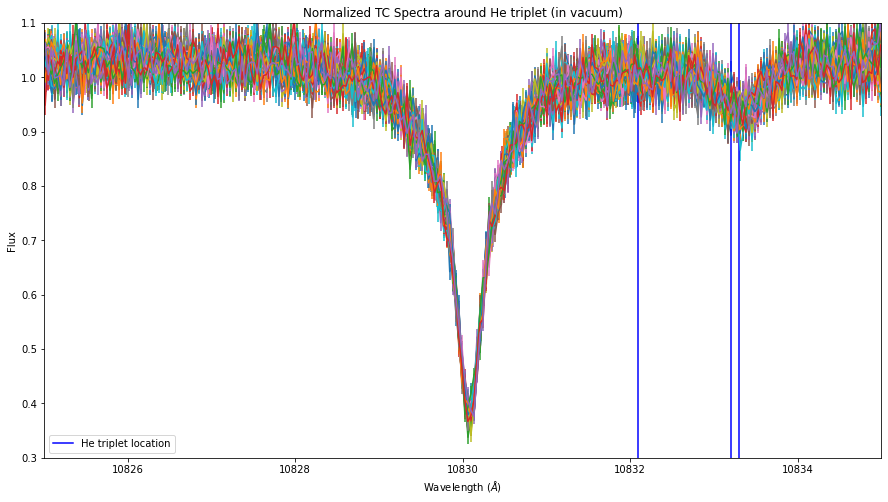

In [17]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra around He triplet (in vacuum) for HA')
        ax1.set_xlim([10825, 10835])
        ax1.set_ylim([0.3, 1.1])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra around He triplet (in vacuum) for HE')
        ax2.set_xlim([10825, 10835])
        ax2.set_ylim([0.3, 1.1])

    ax1.axvline(10833.2, color='b', label='He triplet location')
    ax1.axvline(10833.3, color='b')
    ax1.axvline(10832.1, color='b')

    ax2.axvline(10833.2, color='b', label='He triplet location')
    ax2.axvline(10833.3, color='b')
    ax2.axvline(10832.1, color='b')

    ax1.legend()
    ax2.legend()
    plt.savefig('Plot_Results/Superpose_He_triplet_Vacuum.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra around He triplet (in vacuum)')
    plt.xlim([10825, 10835])
    plt.ylim([0.3, 1.1])
    
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    plt.savefig('Plot_Results/Superpose_He_triplet_Vacuum.pdf')
    plt.show()

## Perform air-to-vacuum correction

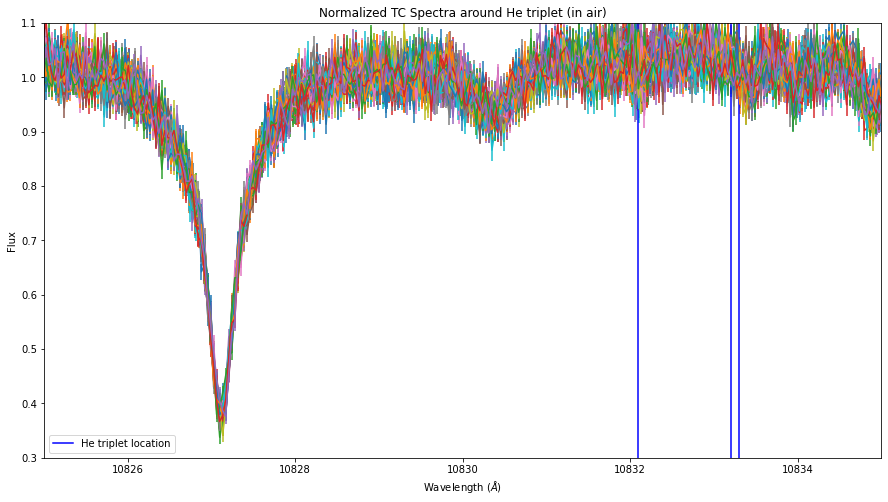

In [18]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(AF.vac2air(total_lamda_HA[i]), total_norm_spctr_HA[i], yerr=total_norm_err_HA[i])
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra around He triplet (in air) for HA')
        ax1.set_xlim([10825, 10835])
        ax1.set_ylim([0.3, 1.1])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(AF.vac2air(total_lamda_HE[i]), total_norm_spctr_HE[i], yerr=total_norm_err_HE[i])
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra around He triplet (in air) for HE')
        ax2.set_xlim([10825, 10835])
        ax2.set_ylim([0.3, 1.1])

    ax1.axvline(10829.09, color='b', label='He triplet location')
    ax1.axvline(10830.34, color='b')
    ax1.axvline(10830.25, color='b')

    ax2.axvline(10829.09, color='b', label='He triplet location')
    ax2.axvline(10830.34, color='b')
    ax2.axvline(10830.25, color='b')

    ax1.legend()
    ax2.legend()
    plt.savefig('Plot_Results/Superpose_He_triplet_Air.pdf')
    plt.show()
    
#If there is one mode of observation 
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(AF.vac2air(total_lamda[i]), total_norm_spctr[i], yerr=total_norm_err[i])
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra around He triplet (in air)')
    plt.xlim([10825, 10835])
    plt.ylim([0.3, 1.1])
    
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    plt.savefig('Plot_Results/Superpose_He_triplet_Air.pdf')
    plt.show()

## Plotting the continuum

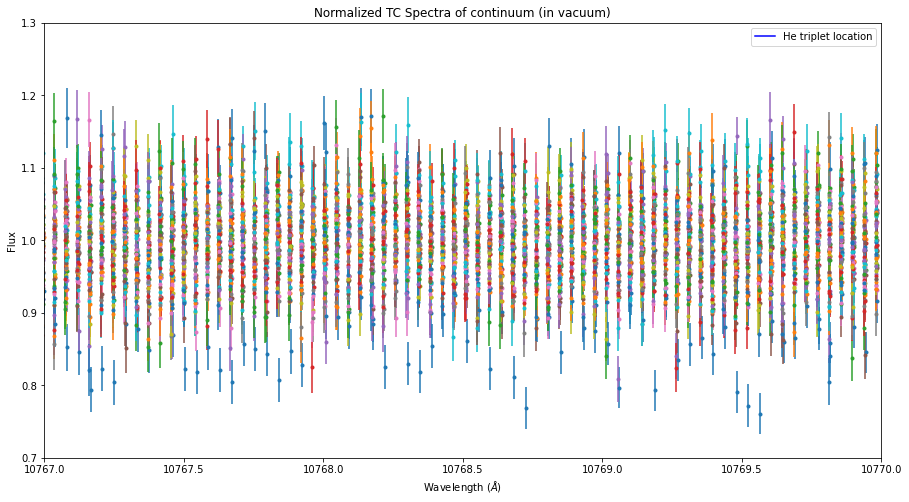

In [19]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    for i in range(len(total_lamda_HA)):
        ax1.errorbar(total_lamda_HA[i], total_norm_spctr_HA[i], yerr=total_norm_err_HA[i], fmt='.')
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Flux')
        ax1.set_title('Normalized TC Spectra of continuum (in vacuum) for HA')
        ax1.set_xlim([10767, 10770])
        #ax1.set_ylim([0.7, 1.3])
    
    for i in range(len(total_lamda_HE)):
        ax2.errorbar(total_lamda_HE[i], total_norm_spctr_HE[i], yerr=total_norm_err_HE[i], fmt='.')
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Flux')
        ax2.set_title('Normalized TC Spectra of continuum (in vacuum) for HE')
        ax2.set_xlim([10767, 10770])
        #ax2.set_ylim([0.7, 1.3])

    ax1.axvline(10829.09, color='b', label='He triplet location')
    ax1.axvline(10830.34, color='b')
    ax1.axvline(10830.25, color='b')

    ax2.axvline(10829.09, color='b', label='He triplet location')
    ax2.axvline(10830.34, color='b')
    ax2.axvline(10830.25, color='b')

    ax1.legend()
    ax2.legend()
    
    plt.savefig('Plot_Results/Continuum.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])
    for i in range(len(total_lamda)):
        plt.errorbar(total_lamda[i], total_norm_spctr[i], yerr=total_norm_err[i], fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized TC Spectra of continuum (in vacuum)')
    plt.xlim([10767, 10770])
    plt.ylim([0.7, 1.3])
    
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    plt.savefig('Plot_Results/Continuum.pdf')
    plt.show()

## Calculating the systematics

In [20]:
low = 10767
up = 10770

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    index_A = 1
    index_E = 1

    std_A = np.zeros(index_A)
    std_E = np.zeros(index_E)

    photon_A = np.zeros(index_A)
    photon_E = np.zeros(index_E)

    for i in range(index_A):
    
        low_lamda_A = total_lamda_HA[i][low<total_lamda_HA[i]]
        low_spctr_A = total_spctr_HA[i][low<total_lamda_HA[i]]
        low_err_A = total_err_HA[i][low<total_lamda_HA[i]]
    
        bound_spctr_A = low_spctr_A[low_lamda_A < up]
        bound_err_A = low_err_A[low_lamda_A < up]
    
        std_A[i] = np.std(bound_spctr_A)

        photon_A[i] = np.sqrt(np.mean(bound_spctr_A))

    for i in range(index_E):

        low_lamda_E = total_lamda_HE[i][low<total_lamda_HE[i]]
        low_spctr_E = total_spctr_HE[i][low<total_lamda_HE[i]]
        low_err_E = total_err_HE[i][low<total_lamda_HE[i]]
    
        bound_spctr_E = low_spctr_E[low_lamda_E < up]
        bound_err_E = low_err_E[low_lamda_E < up]
    
        std_E[i] = np.std(bound_spctr_E)

        photon_E[i] = np.sqrt(np.mean(bound_spctr_E))

#If there is one mode of observation
else:
    index = 1

    std = np.zeros(index)

    photon = np.zeros(index)

    for i in range(index):
    
        low_lamda = total_lamda[i][low<total_lamda[i]]
        low_spctr = total_spctr[i][low<total_lamda[i]]
        low_err = total_err[i][low<total_lamda[i]]
    
        bound_spctr = low_spctr[low_lamda < up]
        bound_err = low_err[low_lamda < up]
    
        std[i] = np.std(bound_spctr)

        photon[i] = np.sqrt(np.mean(bound_spctr))

In [21]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    print('Standard deviations:', np.mean(std_A), np.mean(std_E))
    print('Photon noise:', np.mean(photon_A), np.mean(photon_E))
    print('SNR:', np.mean(tot_SNR[0]), np.mean(tot_SNR[0]))
    ##Noise is 
    print(np.sqrt(np.mean(std_A)**2 - np.mean(photon_A)**2), np.sqrt(np.mean(std_E)**2 - np.mean(photon_E)**2))
    
#If there is one mode of observation
else:
    print('Standard deviations:', np.mean(std))
    print('Photon noise:', np.mean(photon))
    print('SNR:', np.mean(tot_SNR[0]))
    ##Noise is 
    print(np.sqrt(np.mean(std)**2 - np.mean(photon)**2))


Standard deviations: 130892936.08344486
Photon noise: 50112.45047748483
SNR: 35.2348227015462
130892926.49065147


## Building a master spectrum

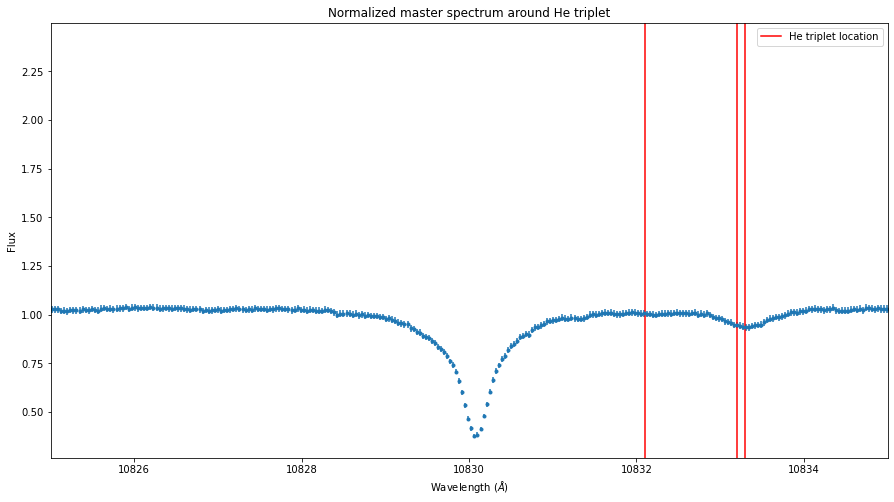

In [22]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    master_lamda_HA = np.mean(total_lamda_HA, axis=0)
    master_norm_spctr_HA = np.mean(total_norm_spctr_HA, axis=0)
    master_norm_err_HA = np.mean(total_norm_err_HA, axis=0)

    master_lamda_HE = np.mean(total_lamda_HE, axis=0)
    master_norm_spctr_HE = np.mean(total_norm_spctr_HE, axis=0)
    master_norm_err_HE = np.mean(total_norm_err_HA, axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])

    ax1.errorbar(master_lamda_HA, master_norm_spctr_HA, yerr=master_norm_err_HA, fmt='.')
    ax2.errorbar(master_lamda_HE, master_norm_spctr_HE, yerr=master_norm_err_HE, fmt='.')
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Flux')
    ax2.set_ylabel('Flux')
    ax1.set_title('Normalized master spectrum around He triplet for HA')
    ax2.set_title('Normalized master spectrum around He triplet for HE')
    ax1.set_xlim([10825, 10835])
    ax2.set_xlim([10825, 10835])
    ax1.axvline(10833.2, color='red', label='He triplet location')
    ax1.axvline(10833.3, color='red')
    ax1.axvline(10832.1, color='red')
    ax2.axvline(10833.2, color='red', label='He triplet location')
    ax2.axvline(10833.3, color='red')
    ax2.axvline(10832.1, color='red')
    ax1.legend()
    ax2.legend()
    
    plt.savefig('Plot_Results/He_triplet_Master.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])
    
    master_lamda = np.mean(total_lamda, axis=0)
    master_norm_spctr = np.mean(total_norm_spctr, axis=0)
    master_norm_err = np.mean(total_norm_err, axis=0)

    plt.errorbar(master_lamda, master_norm_spctr, yerr=master_norm_err, fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Normalized master spectrum around He triplet')
    plt.xlim([10825, 10835])
    plt.axvline(10833.2, color='red', label='He triplet location')
    plt.axvline(10833.3, color='red')
    plt.axvline(10832.1, color='red')
    plt.legend()
    
    plt.savefig('Plot_Results/He_triplet_Master.pdf')
    plt.show()

## Making residuals 

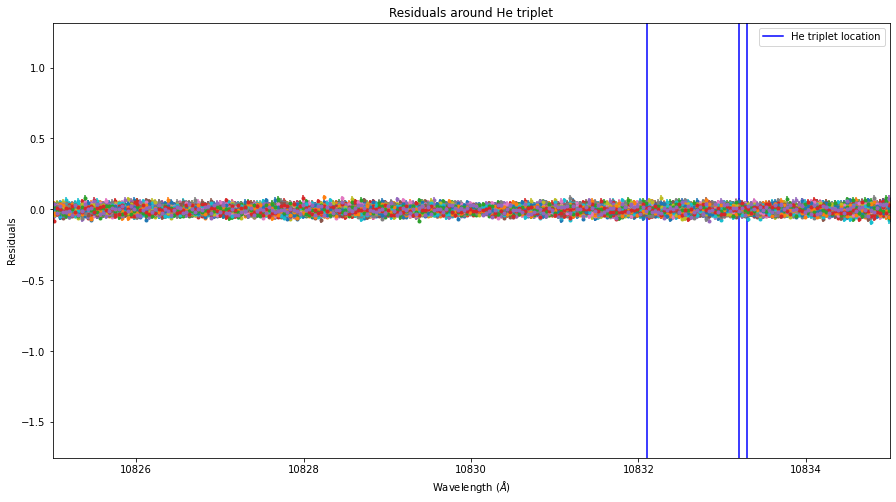

In [23]:
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6])
    
    for i in range(len(total_norm_spctr_HA)):
        ax1.errorbar(master_lamda_HA, total_norm_spctr_HA[i] - master_norm_spctr_HA, yerr=total_norm_err_HA[i], fmt='.')
        ax1.set_xlabel('Wavelength ($\AA$)')
        ax1.set_ylabel('Residuals')
        ax1.set_xlim([10825, 10835])

    for i in range(len(total_norm_spctr_HE)):
        ax2.errorbar(master_lamda_HE, total_norm_spctr_HE[i] - master_norm_spctr_HE, yerr=total_norm_err_HE[i], fmt='.')
        ax2.set_xlabel('Wavelength ($\AA$)')
        ax2.set_ylabel('Residuals')
        ax2.set_xlim([10825, 10835])
    ax1.set_title('Residuals  around He triplet for HA')
    ax1.axvline(10833.2, color='b', label='He triplet location')
    ax1.axvline(10833.3, color='b')
    ax1.axvline(10832.1, color='b')

    ax2.set_title('Residuals  around He triplet for HE')
    ax2.axvline(10833.2, color='b', label='He triplet location')
    ax2.axvline(10833.3, color='b')
    ax2.axvline(10832.1, color='b')

    ax1.legend()
    ax2.legend()
    
    plt.savefig('Plot_Results/He_triplet_Residuals.pdf')
    plt.show()

#If there is one mode of observation
else:
    plt.figure(figsize=[15, 8])  
    for i in range(len(total_norm_spctr)):
        plt.errorbar(master_lamda, total_norm_spctr[i] - master_norm_spctr, yerr=total_norm_err[i], fmt='.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Residuals')
    plt.xlim([10825, 10835])
    plt.title('Residuals around He triplet')
    plt.axvline(10833.2, color='b', label='He triplet location')
    plt.axvline(10833.3, color='b')
    plt.axvline(10832.1, color='b')

    plt.legend()
    plt.savefig('Plot_Results/He_triplet_Residuals.pdf')
    plt.show()
    

## Fitting a gaussian to the He triplet line

[-7.65562841e-02 -1.01273046e+02  1.08333643e+04  2.41796938e-01
  9.44341586e-03]


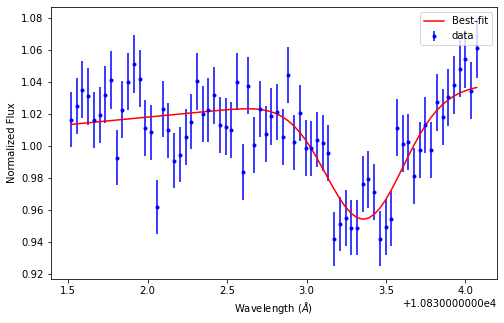

[-7.40113123e-02 -5.40285677e+01  1.08333275e+04  2.74536327e-01
  5.07997386e-03]


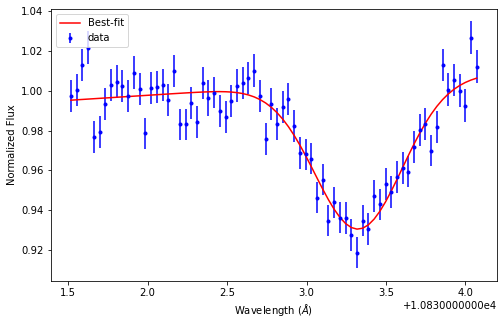

[-7.98400475e-02 -1.17943019e+01  1.08333336e+04  2.14459319e-01
  1.18102711e-03]


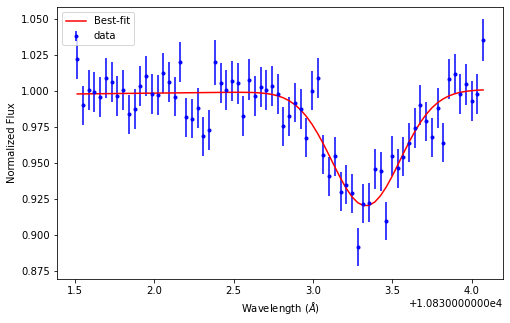

[-7.34209399e-02 -1.02446606e+02  1.08333902e+04  3.15855642e-01
  9.54996744e-03]


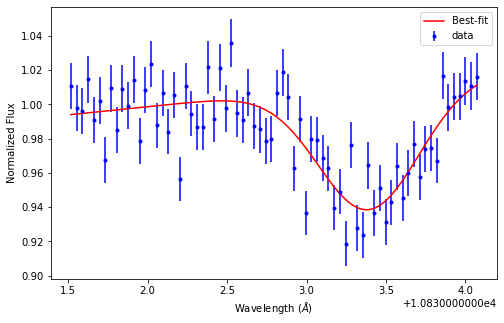

[-7.72470648e-02 -5.80017282e+01  1.08332979e+04  2.70978725e-01
  5.44671433e-03]


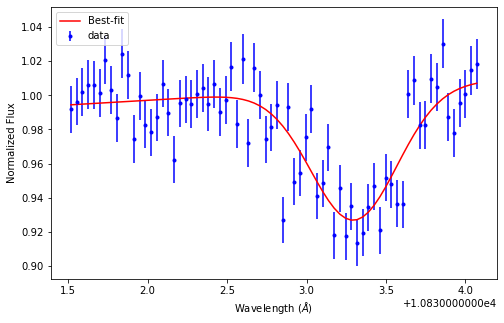

[-8.89391857e-02 -1.68338905e+02  1.08333358e+04  2.90378353e-01
  1.56335846e-02]


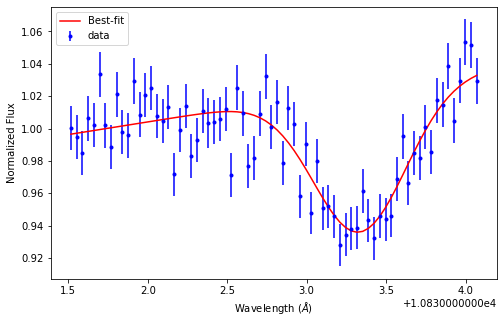

[-7.02636460e-02 -7.79524301e+01  1.08333226e+04  2.84824049e-01
  7.28895022e-03]


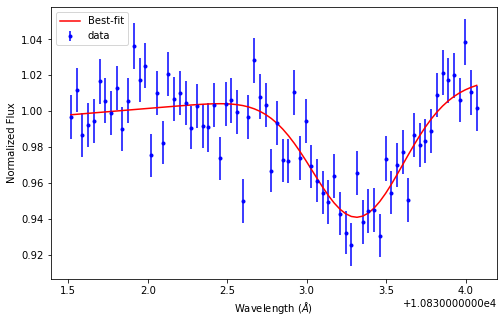

[-6.90829859e-02 -6.93223022e+01  1.08333013e+04  2.82537482e-01
  6.49199577e-03]


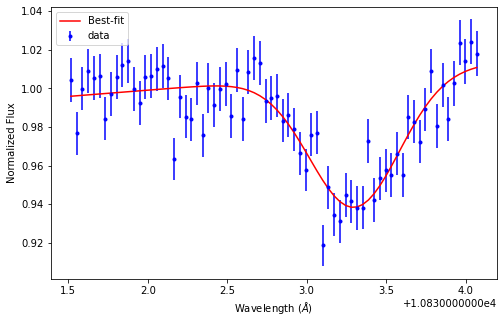

[-7.41728200e-02 -4.87284973e+01  1.08333113e+04  2.16760030e-01
  4.59047148e-03]


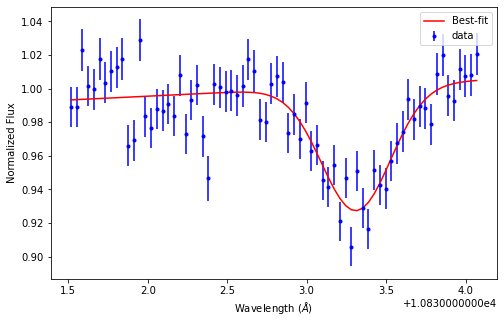

[-7.10735055e-02 -4.59118560e+01  1.08332866e+04  2.89695556e-01
  4.33026356e-03]


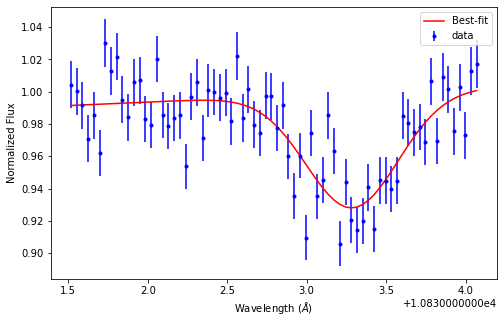

[-8.89865906e-02 -5.65138197e+01  1.08332918e+04  2.36139517e-01
  5.30906894e-03]


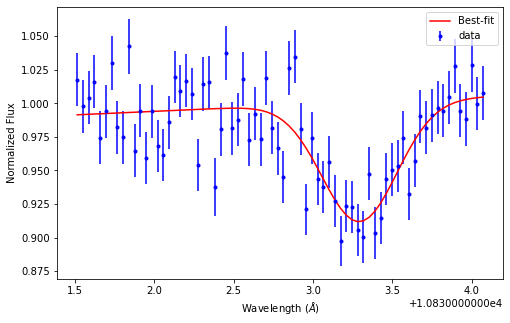

[-8.05608476e-02 -1.12024483e+02  1.08333385e+04  2.48519231e-01
  1.04349257e-02]


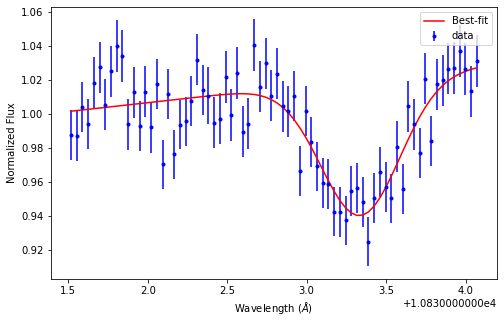

[-7.62461354e-02 -7.80317002e+01  1.08333141e+04  2.34140867e-01
  7.29606957e-03]


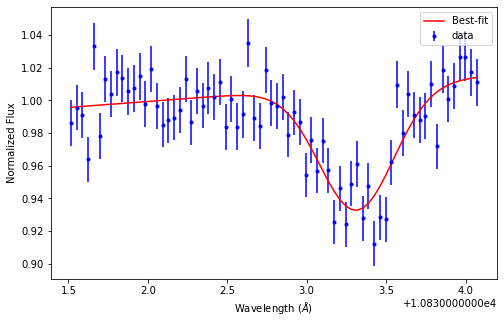

[-7.71898095e-02 -9.88114547e+01  1.08333110e+04  2.50874219e-01
  9.21495880e-03]


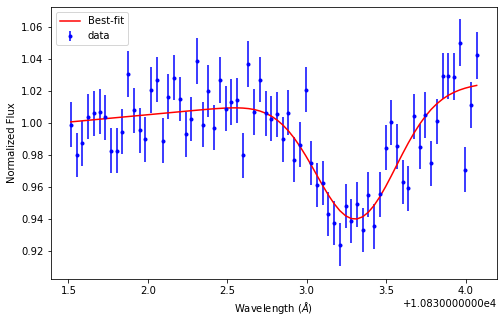

[-8.35787682e-02 -1.06038765e+01  1.08333267e+04  2.08909379e-01
  1.07232990e-03]


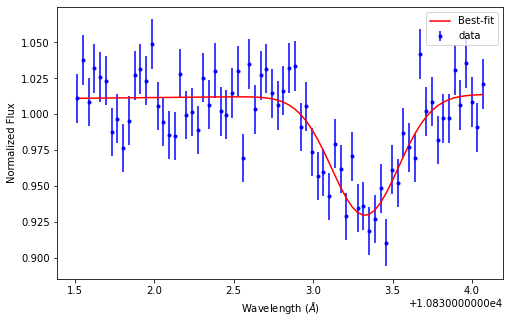

[-7.29176423e-02  1.82112878e+01  1.08333640e+04  1.96978647e-01
 -1.58818503e-03]


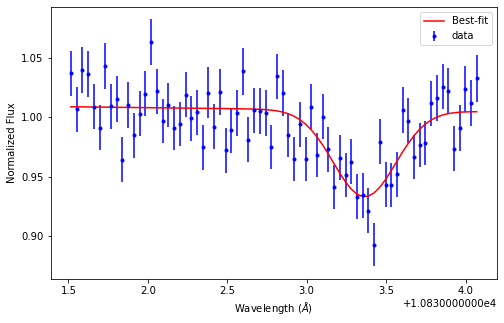

[-8.12826536e-02 -7.05410563e+01  1.08333118e+04  2.46030349e-01
  6.60539068e-03]


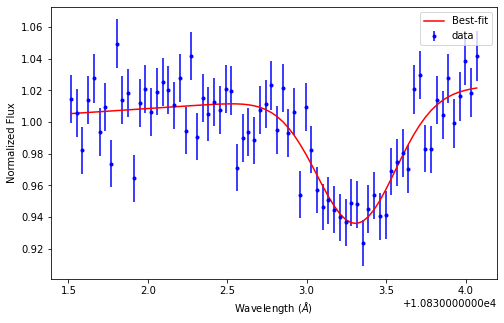

[-7.71411044e-02 -4.18773572e+01  1.08333017e+04  2.95734681e-01
  3.95976212e-03]


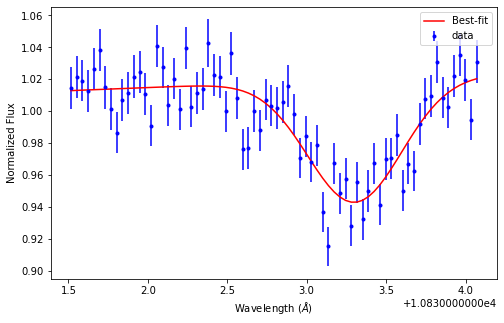

[-8.01301079e-02 -4.04244021e+01  1.08333615e+04  2.18252549e-01
  3.82465400e-03]


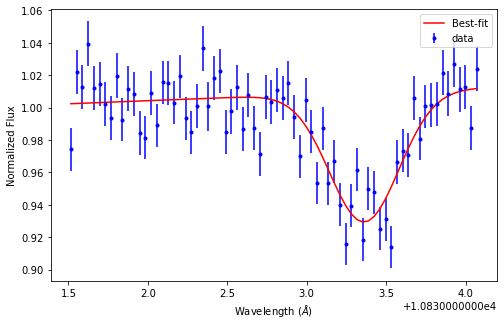

[-8.54033610e-02 -2.18102395e+01  1.08333137e+04  2.05709577e-01
  2.10572804e-03]


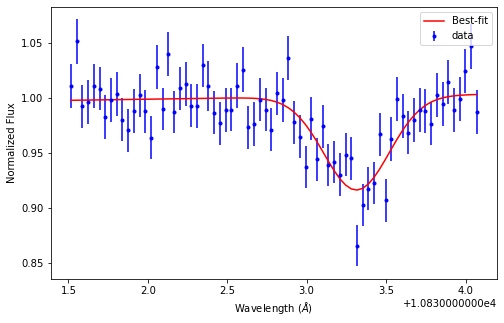

[-7.44871518e-02 -1.77760438e+02  1.08333443e+04  3.51076404e-01
  1.65034410e-02]


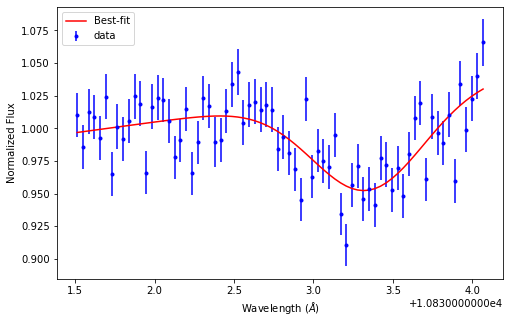

[-9.50161484e-02 -8.84960506e+01  1.08333398e+04  2.27348145e-01
  8.26344999e-03]


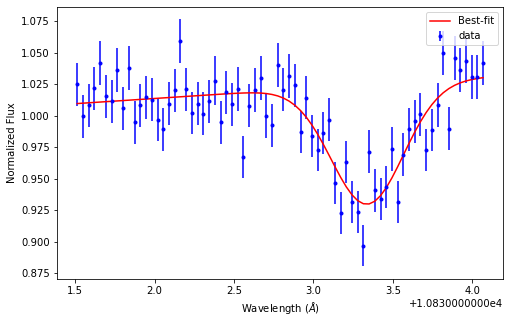

[-8.42843447e-02 -1.40240144e+02  1.08333020e+04  2.95647838e-01
  1.30399054e-02]


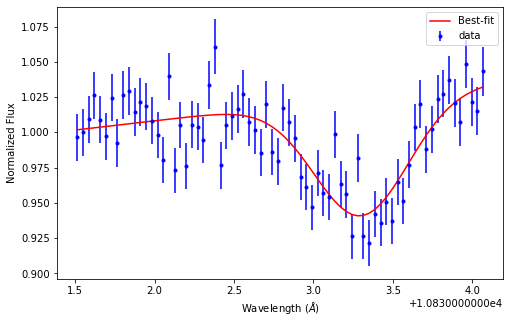

[-8.89149526e-02 -1.56309754e+02  1.08333378e+04  3.01688220e-01
  1.45231660e-02]


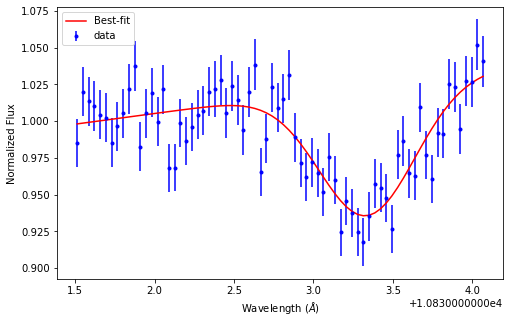

[-9.27656128e-02 -1.79105595e+02  1.08333889e+04  3.30602754e-01
  1.66283846e-02]


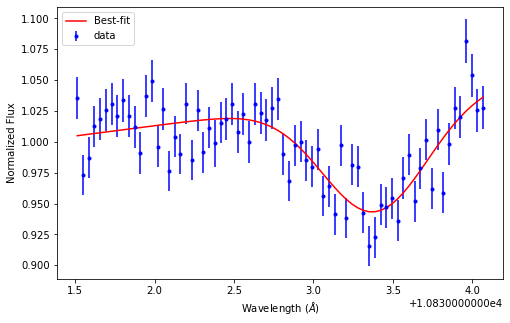

[-7.17333677e-02 -1.06393965e+02  1.08333112e+04  3.33458094e-01
  9.91524298e-03]


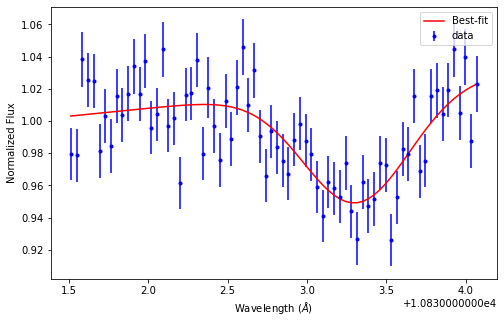

[-7.17691688e-02  2.34615713e+01  1.08332960e+04  2.36505075e-01
 -2.07248321e-03]


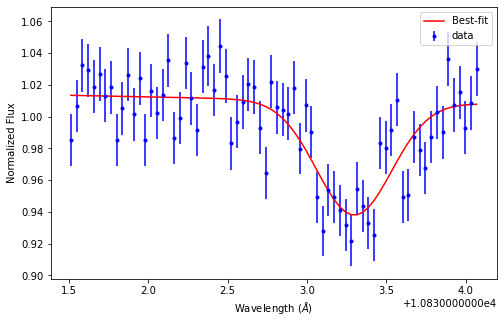

[-8.77340503e-02 -7.47927509e+01  1.08333183e+04  2.03562312e-01
  6.99759714e-03]


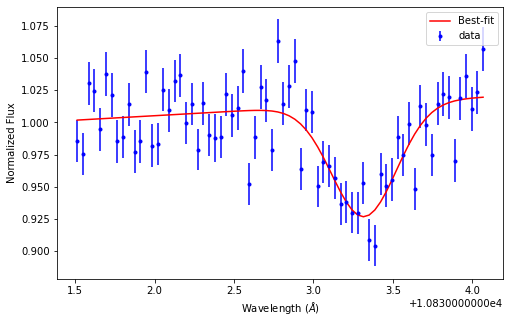

[-8.01743063e-02 -1.09430192e+02  1.08333654e+04  2.90768033e-01
  1.01957067e-02]


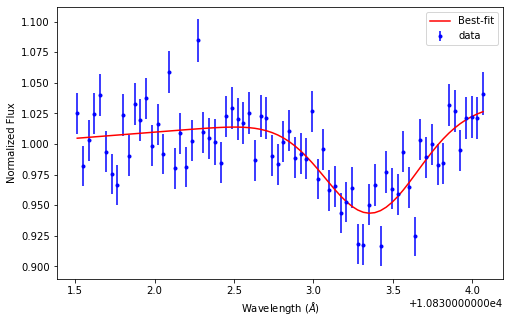

[-7.40547756e-02 -2.44587309e+01  1.08333107e+04  2.65646052e-01
  2.35171197e-03]


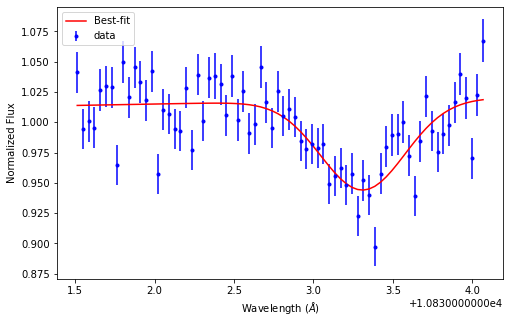

[-7.89633288e-02 -8.49285033e+01  1.08333279e+04  2.36575580e-01
  7.93334639e-03]


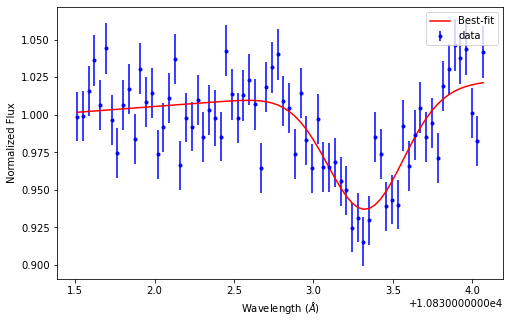

[-7.86276852e-02 -1.87171283e+02  1.08333536e+04  3.35457295e-01
  1.73725794e-02]


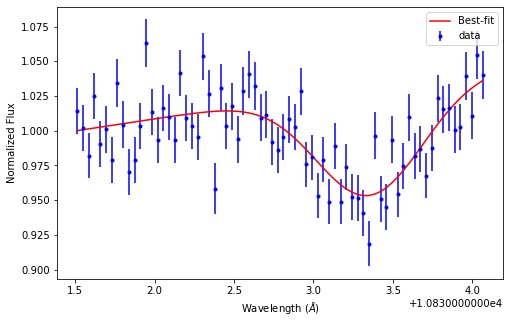

[-7.15826910e-02 -2.10784828e+01  1.08333186e+04  2.12083366e-01
  2.03899163e-03]


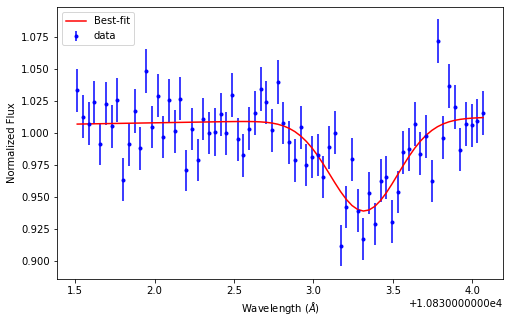

[-6.97412993e-02 -9.83525689e+01  1.08334000e+04  3.00340121e-01
  9.17300366e-03]


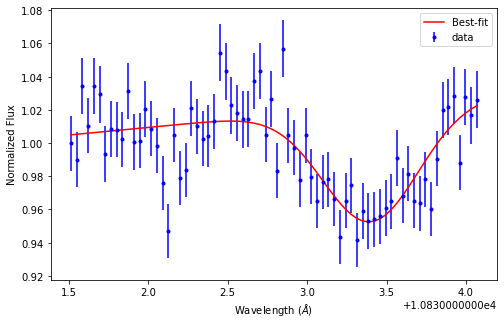

[-8.18188687e-02 -1.02916272e+02  1.08333171e+04  3.31727239e-01
  9.59447812e-03]


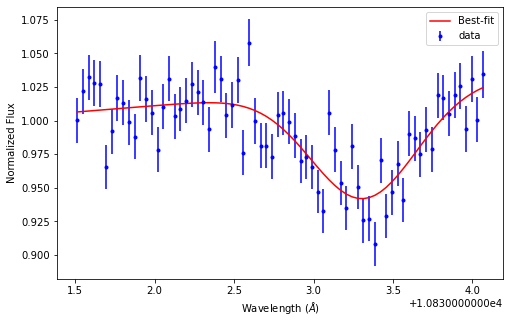

[-7.56009809e-02 -8.66642998e+01  1.08333424e+04  2.26093410e-01
  8.09371341e-03]


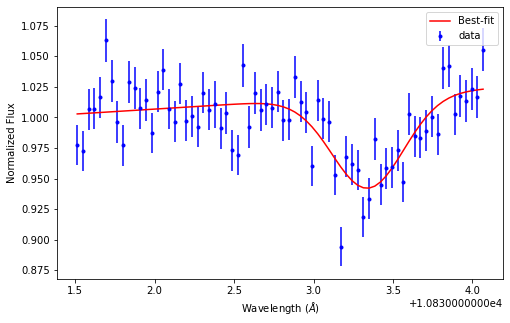

[-8.33528831e-02 -1.40942214e+02  1.08333285e+04  3.12632839e-01
  1.31049019e-02]


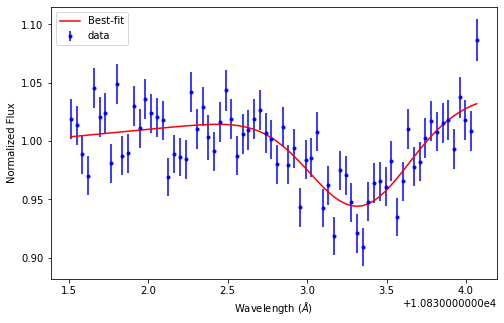

[-7.78450904e-02 -5.62564212e+01  1.08333825e+04  2.59890482e-01
  5.28643562e-03]


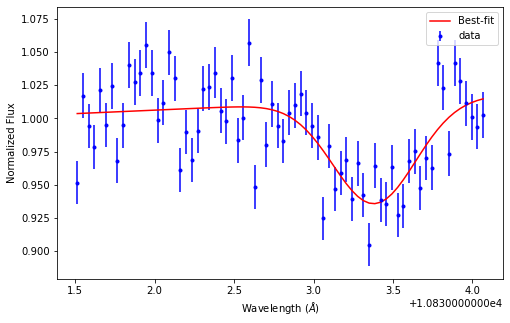

[-7.27420991e-02 -2.63562590e+01  1.08333266e+04  1.94133703e-01
  2.52592221e-03]


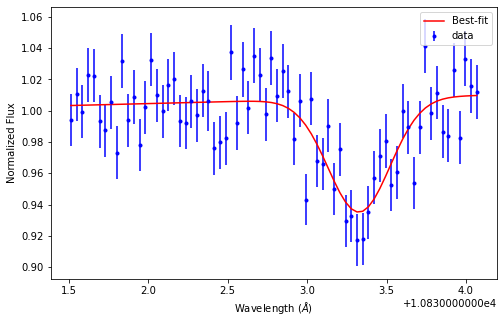

[-7.78561426e-02 -2.70777819e+01  1.08333528e+04  2.35440866e-01
  2.59272009e-03]


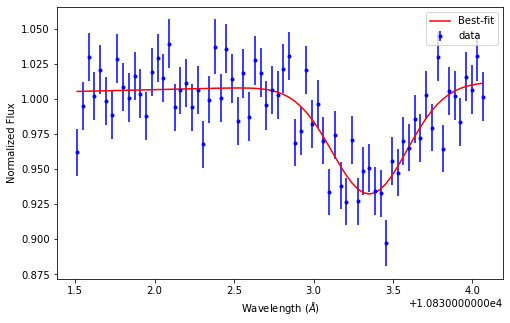

[-8.38876128e-02 -1.78943888e+02  1.08334000e+04  2.99964774e-01
  1.66123869e-02]


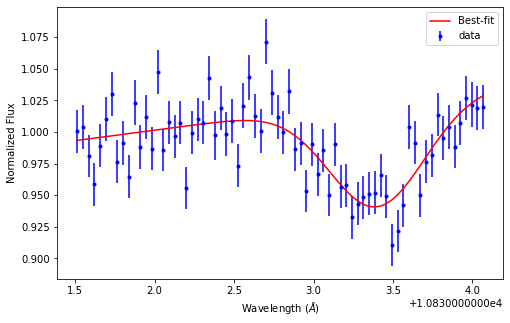

[-8.98027001e-02 -1.30563207e+02  1.08333525e+04  2.83263768e-01
  1.21468832e-02]


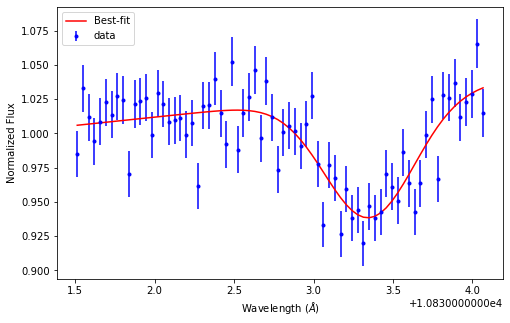

[-8.01272956e-02 -1.17091750e+02  1.08333289e+04  2.60637328e-01
  1.09022742e-02]


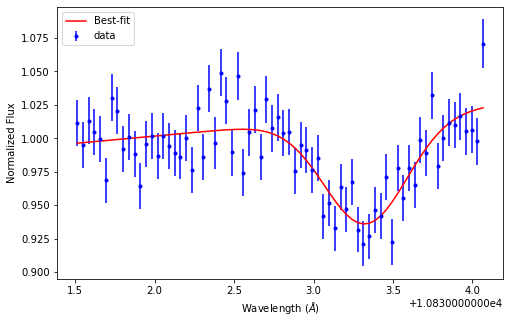

[-8.70490754e-02 -2.38219455e+01  1.08333154e+04  2.05056679e-01
  2.29240134e-03]


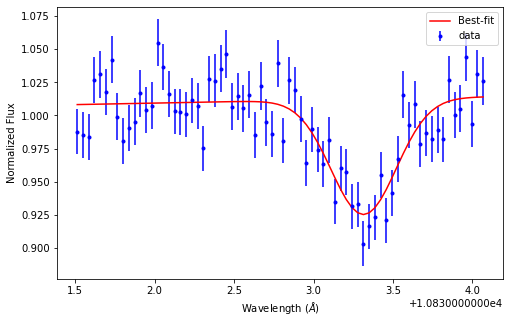

[-8.47449921e-02 -3.33691923e+01  1.08333404e+04  2.25287416e-01
  3.17354642e-03]


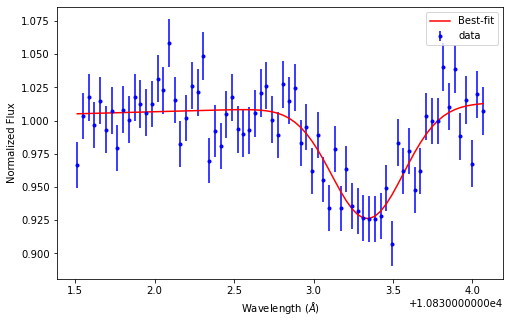

[-7.12263715e-02 -5.25195250e+01  1.08333676e+04  2.67670481e-01
  4.94153183e-03]


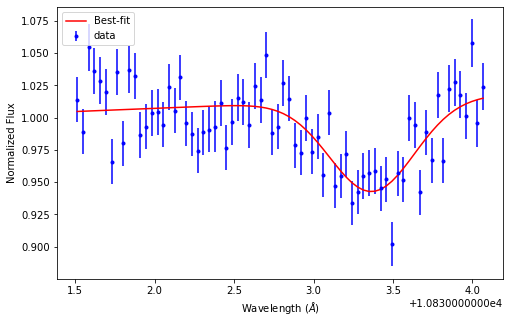

[-8.80152138e-02 -9.14974759e+01  1.08334000e+04  2.02450997e-01
  8.53910300e-03]


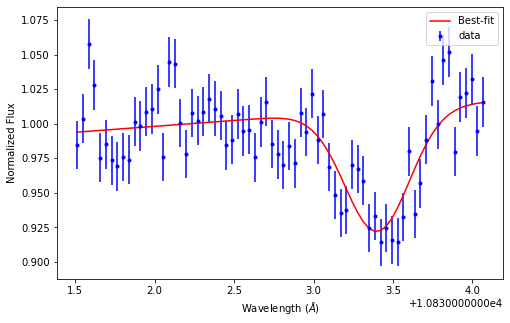

[-7.72364211e-02 -2.30852150e+01  1.08332443e+04  2.10816908e-01
  2.22381628e-03]


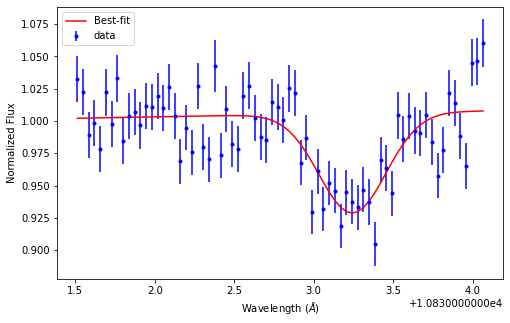

[-8.93760058e-02 -1.20911468e+02  1.08333575e+04  2.43314569e-01
  1.12550747e-02]


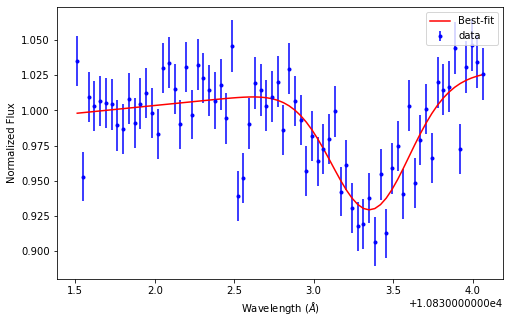

[-7.04773567e-02 -6.88645704e+01  1.08332815e+04  2.62671303e-01
  6.45057370e-03]


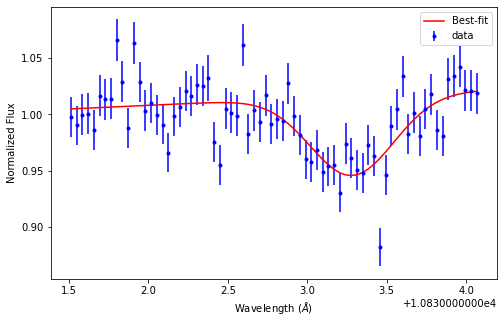

[-8.50942272e-02 -6.36604754e+01  1.08333236e+04  1.91493364e-01
  5.96972952e-03]


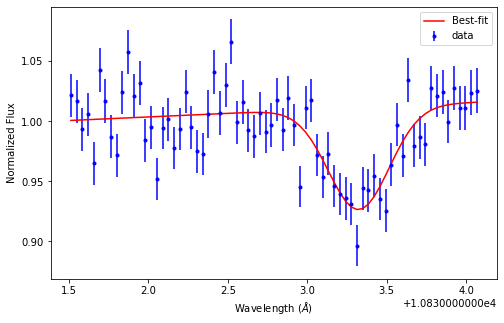

[-7.29860006e-02 -1.61849977e+01  1.08332695e+04  2.30273271e-01
  1.58705091e-03]


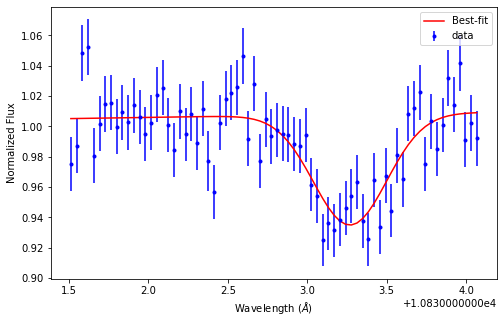

[-9.89106361e-02 -1.35111107e+02  1.08333737e+04  2.82509025e-01
  1.25668449e-02]


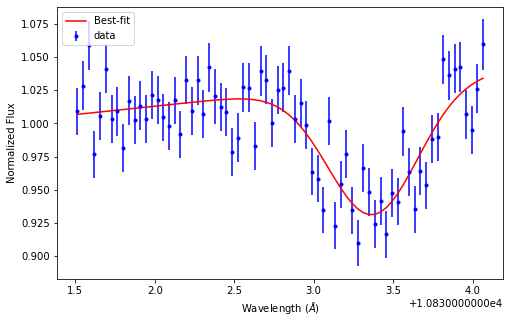

[-7.02094254e-02 -9.57417763e+01  1.08333102e+04  2.68283945e-01
  8.93128635e-03]


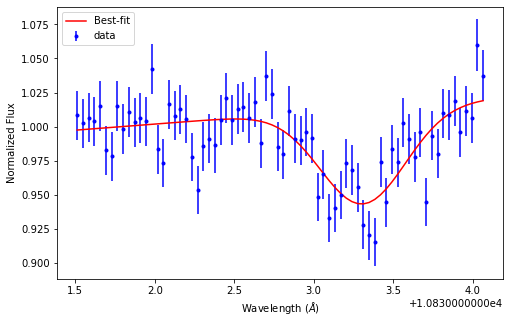

[-9.43101688e-02 -8.87273241e+01  1.08333196e+04  2.54175265e-01
  8.28377803e-03]


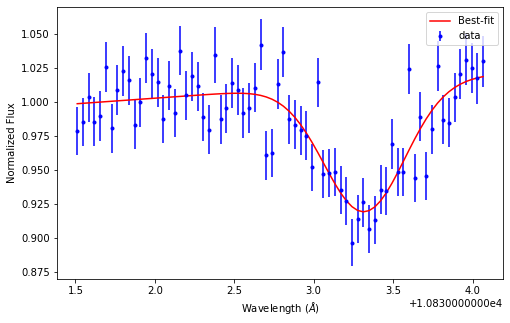

[-6.76536520e-02 -2.39585354e+00  1.08333073e+04  1.77563958e-01
  3.13990053e-04]


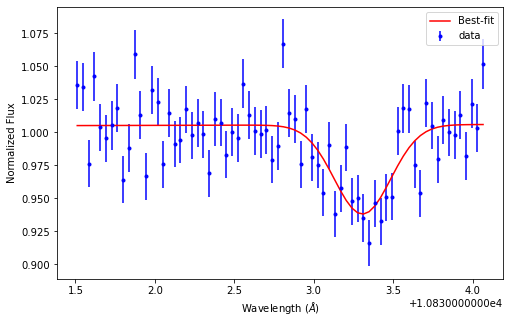

[-8.17509308e-02 -1.57507513e+02  1.08333690e+04  2.55441371e-01
  1.46328455e-02]


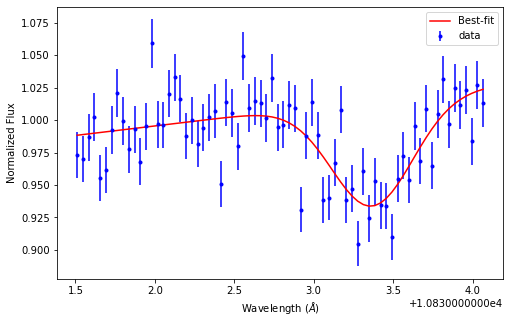

[-9.12333734e-02 -8.27997576e+00  1.08332979e+04  1.74155367e-01
  8.57762642e-04]


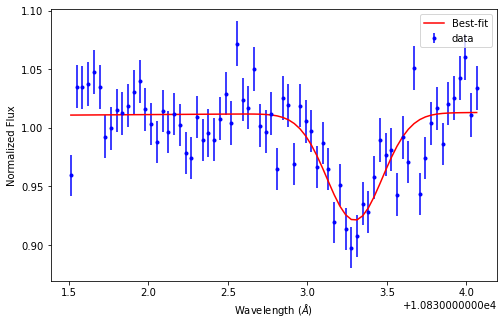

[-7.72554684e-02 -1.49743358e+02  1.08333436e+04  3.12642311e-01
  1.39162502e-02]


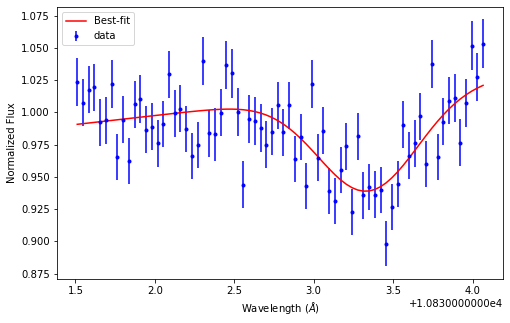

[-9.10067492e-02 -2.42534802e+02  1.08334000e+04  4.63833188e-01
  2.24840783e-02]


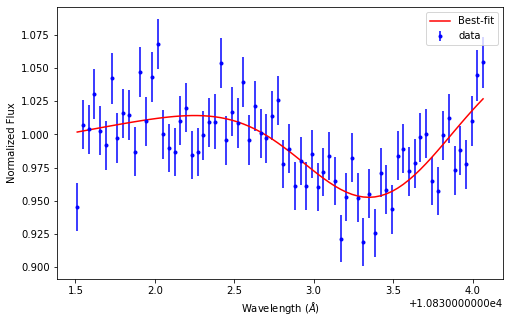

[-7.69954737e-02 -6.43801578e+00  1.08333157e+04  2.25016984e-01
  6.87287293e-04]


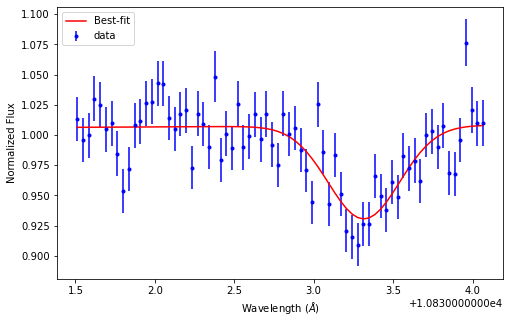

[-7.24752896e-02 -4.38476089e+01  1.08333099e+04  2.22634264e-01
  4.14053293e-03]


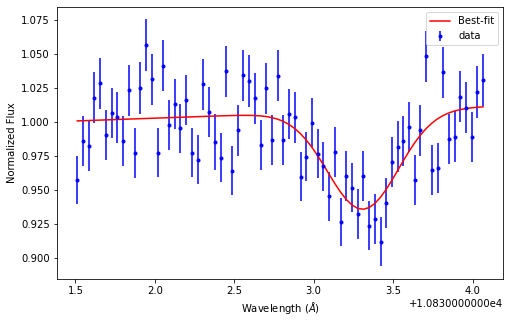

[-8.29986942e-02 -1.93376933e+02  1.08333289e+04  2.41874027e-01
  1.79444105e-02]


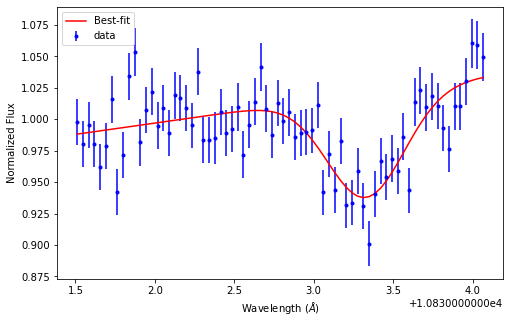

[-8.06579174e-02 -8.10556484e+01  1.08333326e+04  2.46612046e-01
  7.57548394e-03]


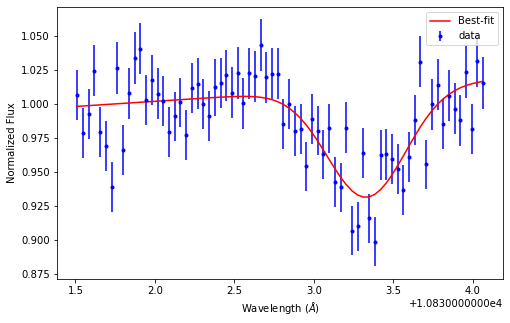

[-7.41660744e-02 -1.19599503e+02  1.08333009e+04  2.36177158e-01
  1.11338580e-02]


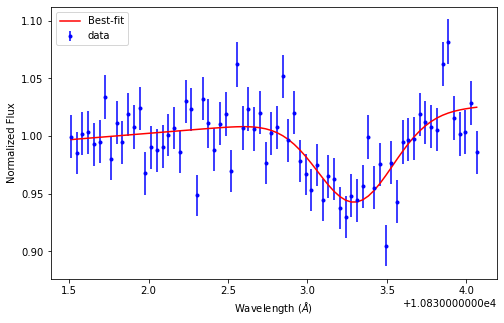

[-8.32469847e-02 -1.24756707e+02  1.08333176e+04  2.92297576e-01
  1.16102737e-02]


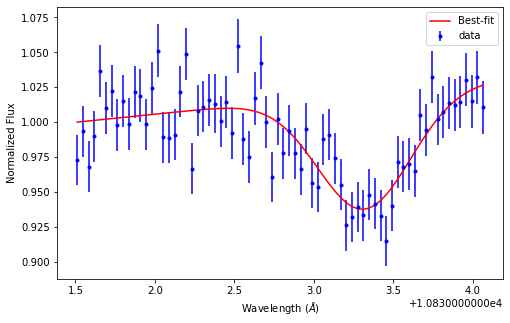

[-8.26066290e-02 -5.36026280e+01  1.08333058e+04  2.48730899e-01
  5.04156665e-03]


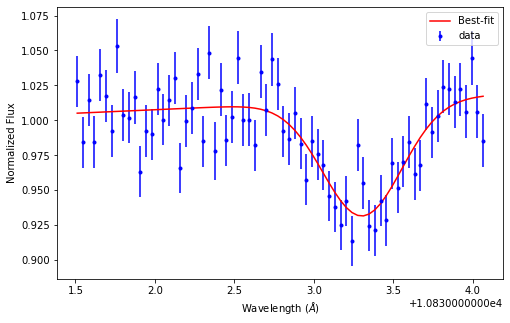

[-6.33685071e-02  2.61961354e+01  1.08333746e+04  2.07775880e-01
 -2.32528516e-03]


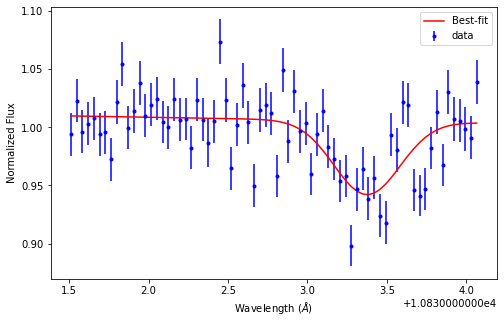

[-9.16563180e-02 -7.13935790e+01  1.08333672e+04  2.86181645e-01
  6.68541669e-03]


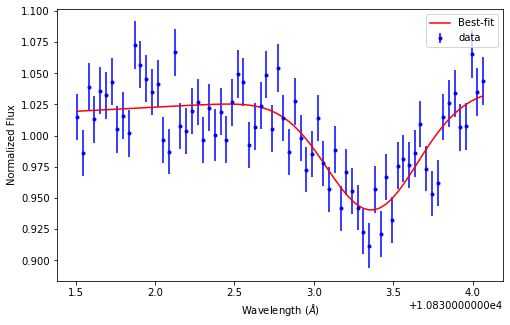

[-9.48023195e-02 -1.76073575e+01  1.08333325e+04  1.82879915e-01
  1.71912020e-03]


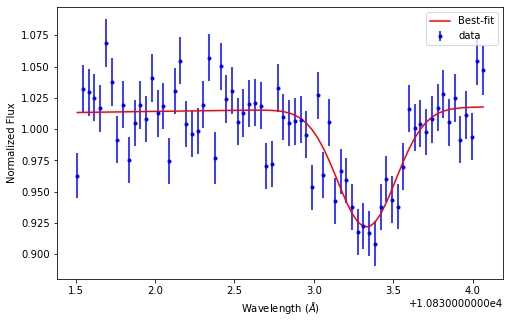

[-7.96691596e-02  3.22010245e+01  1.08333234e+04  1.44070779e-01
 -2.87969868e-03]


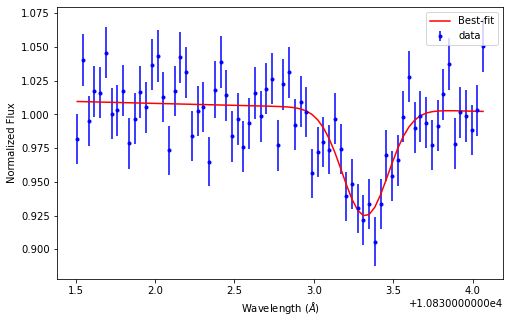

[-8.17659951e-02 -5.54232248e+01  1.08333223e+04  2.09614417e-01
  5.20944142e-03]


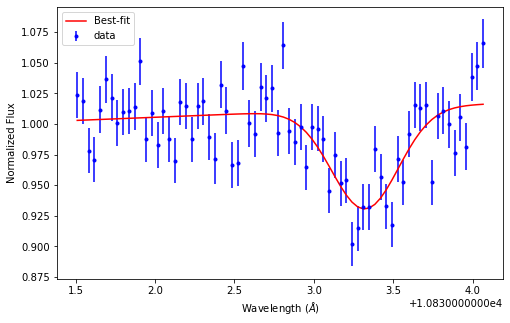

[-8.90854858e-02 -1.67412672e+02  1.08333672e+04  2.80618759e-01
  1.55479945e-02]


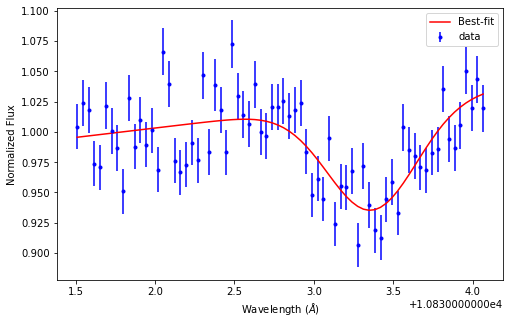

[-8.87290714e-02 -9.90367532e+01  1.08333022e+04  2.22792096e-01
  9.23535579e-03]


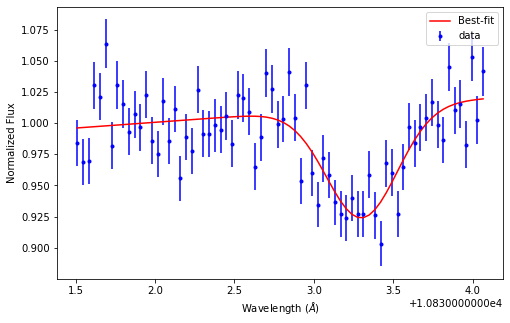

[-9.14733075e-02 -1.67252029e+02  1.08333333e+04  3.55441008e-01
  1.55341735e-02]


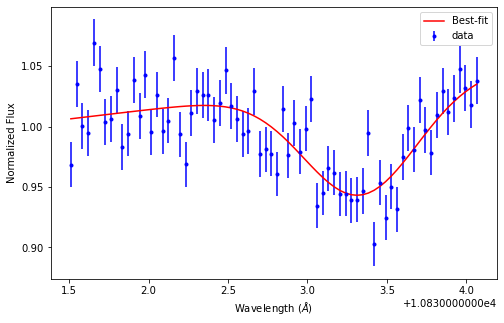

[-6.17695308e-02 -6.39649305e+01  1.08332791e+04  3.20832887e-01
  5.99797581e-03]


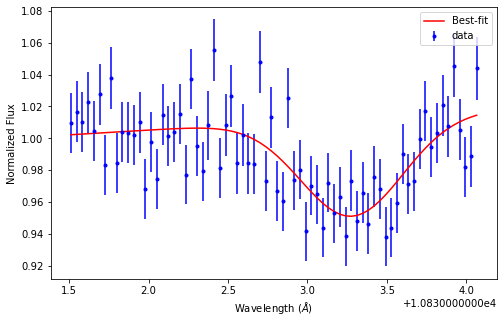

[-7.04815872e-02  4.42011918e+01  1.08333271e+04  2.15786804e-01
 -3.98702937e-03]


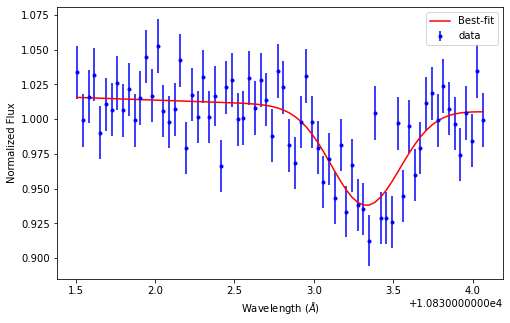

[-6.90907727e-02 -1.16856872e+02  1.08332917e+04  3.18278067e-01
  1.08803913e-02]


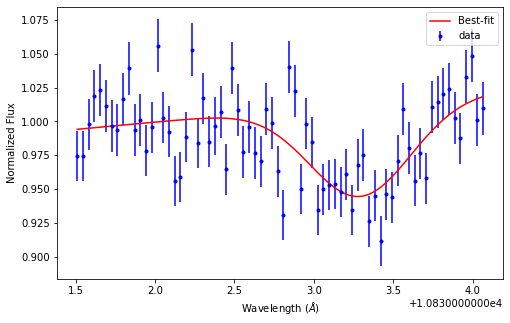

[-5.46362610e-02  5.99604671e+01  1.08332661e+04  2.73780729e-01
 -5.44169847e-03]


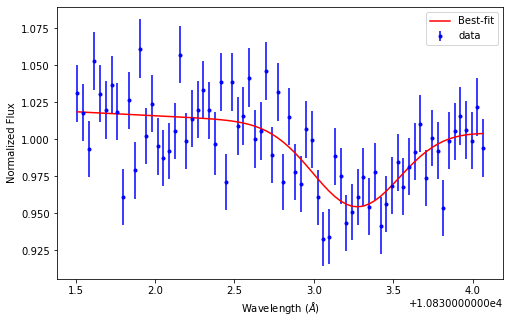

[-7.29879380e-02 -2.97603256e+01  1.08332789e+04  2.55006795e-01
  2.84005627e-03]


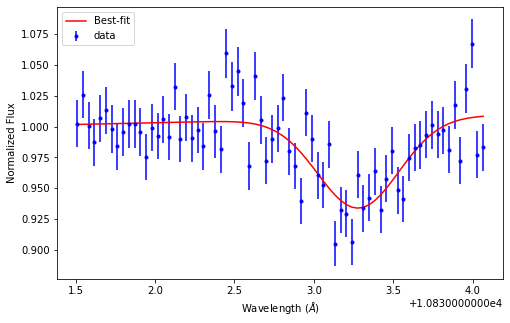

[-7.50739942e-02 -2.21040556e+02  1.08333522e+04  3.50435147e-01
  2.04986710e-02]


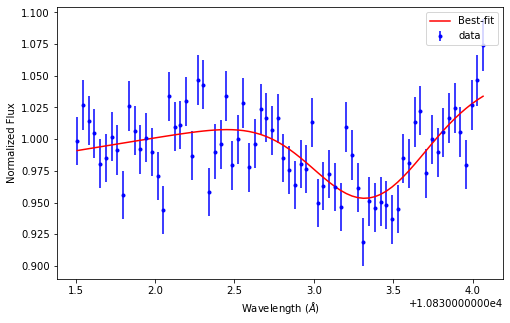

[-7.83803407e-02  1.75616654e+01  1.08332991e+04  1.28598509e-01
 -1.52883546e-03]


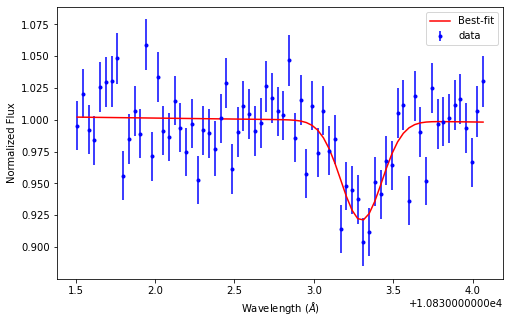

[-7.45569735e-02 -4.70509644e+01  1.08332891e+04  2.60122217e-01
  4.43701109e-03]


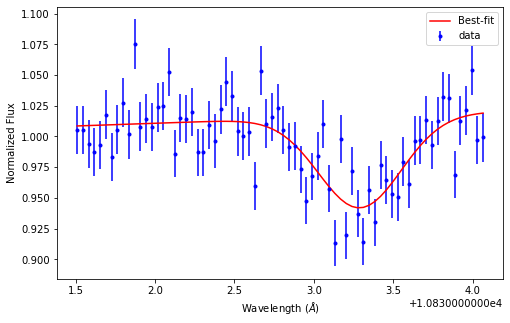

[-6.15500402e-02 -7.93516846e+01  1.08332895e+04  2.74669481e-01
  7.41838879e-03]


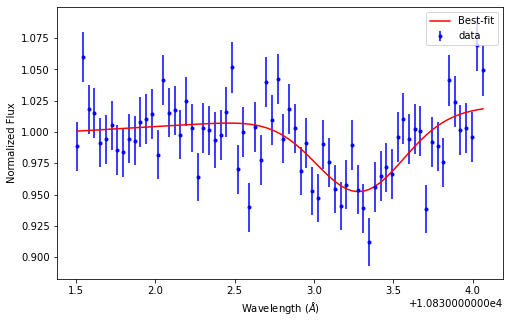

[-6.85240996e-02 -6.14599256e+01  1.08333259e+04  1.96547133e-01
  5.76663461e-03]


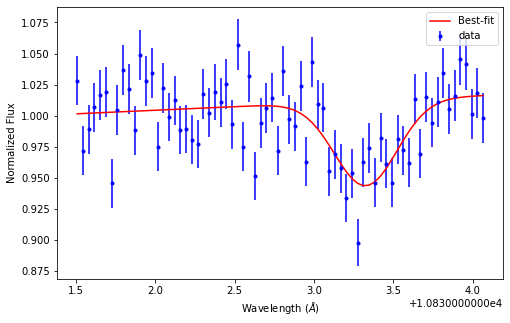

In [24]:
reload(AF)
lower_lim = 10831.5
upper_lim = 10834.1
guess_params = [-0.06, -100, 10833.3, 0.1, 0.008]
bounds_param = ((-np.inf, -np.inf, 10833.2, -np.inf, -np.inf),(0, np.inf, 10833.4, np.inf, np.inf)) 

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    theta_HA, err_theta_HA = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r')

    theta_HE, err_theta_HE = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k')
#If there is one mode of observation
else:
    theta, err_theta = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim, upper_lim, guess_params, 
                                               bounds_param, total_lamda, total_norm_spctr, total_norm_err, 'r')

    

## Plotting the positions, depths and widths of the fitted Gaussian lines

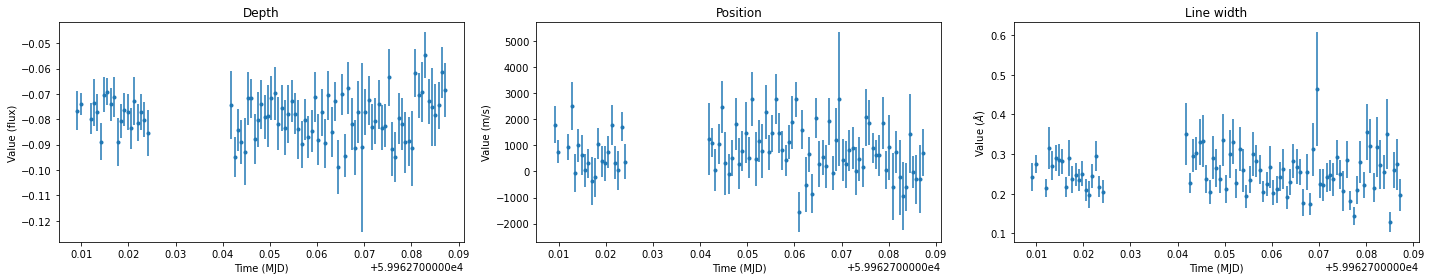

In [25]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ref_He = 10833.3

    ax1.errorbar(date_HA, theta_HA[:, 0], yerr=err_theta_HA[:, 0], fmt='.')
    ax2.errorbar(date_HA, (theta_HA[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_HA[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date_HA, theta_HA[:, 3], yerr=err_theta_HA[:, 3], fmt='.')
    ax1.set_xlabel('Time (MJD)')
    ax2.set_xlabel('Time (MJD)')
    ax3.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')

    fig.tight_layout()
    plt.savefig('Plot_Results/He_Gaussian_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[20, 4])

    ax4.errorbar(date_HE, theta_HE[:, 0], yerr=err_theta_HE[:, 0], fmt='.')
    ax5.errorbar(date_HE, (theta_HE[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_HE[:, 2]*3e8/ref_He, fmt='.')
    ax6.errorbar(date_HE, theta_HE[:, 3], yerr=err_theta_HE[:, 3], fmt='.')
    ax4.set_xlabel('Time (MJD)')
    ax5.set_xlabel('Time (MJD)')
    ax6.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')

    fig.tight_layout()
    plt.savefig('Plot_Results/He_Gaussian_Fit_HE.pdf')
    plt.show()
    
#If there one mode of observation.   
else:
    
    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ref_He = 10833.3

    ax1.errorbar(date, theta[:, 0], yerr=err_theta[:, 0], fmt='.')
    ax2.errorbar(date, (theta[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date, theta[:, 3], yerr=err_theta[:, 3], fmt='.')
    ax1.set_xlabel('Time (MJD)')
    ax2.set_xlabel('Time (MJD)')
    ax3.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Value (flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')

    fig.tight_layout()
    plt.savefig('Plot_Results/He_Gaussian_Fit.pdf')
    plt.show()

## Periodogram for the position, depth and width of the He line

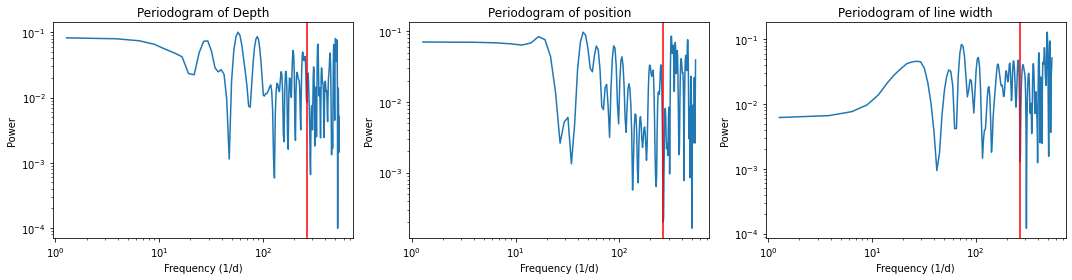

In [26]:
oscillation_freq = 24*60/5.4 #in 1/days!!

#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth_HA = LombScargle(date_HA, theta_HA[:, 0]).autopower(nyquist_factor=1)
    LS_position_HA = LombScargle(date_HA, theta_HA[:, 2]).autopower(nyquist_factor=1)
    LS_width_HA = LombScargle(date_HA, theta_HA[:, 3]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_HA[0], LS_depth_HA[1])
    ax2.loglog(LS_position_HA[0], LS_position_HA[1])
    ax3.loglog(LS_width_HA[0], LS_width_HA[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax1.set_title('Periodogram of depth for HA')
    ax2.set_title('Periodogram of position for HA')
    ax3.set_title('Periodogram of line width for HA')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    plt.savefig('Plot_Results/Periodogram_He_fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth_HE = LombScargle(date_HE, theta_HE[:, 0]).autopower(nyquist_factor=1)
    LS_position_HE = LombScargle(date_HE, theta_HE[:, 2]).autopower(nyquist_factor=1)
    LS_width_HE = LombScargle(date_HE, theta_HE[:, 3]).autopower(nyquist_factor=1)

    ax4.loglog(LS_depth_HE[0], LS_depth_HE[1])
    ax5.loglog(LS_position_HE[0], LS_position_HE[1])
    ax6.loglog(LS_width_HE[0], LS_width_HE[1])
    ax4.set_xlabel('Frequency (1/d)')
    ax5.set_xlabel('Frequency (1/d)')
    ax6.set_xlabel('Frequency (1/d)')
    ax5.set_ylabel('Power')
    ax6.set_ylabel('Power')
    ax4.set_ylabel('Power')
    ax4.set_title('Periodogram of depth for HE')
    ax5.set_title('Periodogram of position for HE')
    ax6.set_title('Periodogram of line width for HE')
    ax4.axvline(oscillation_freq, color='r')
    ax5.axvline(oscillation_freq, color='r')
    ax6.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    
    plt.savefig('Plot_Results/Periodogram_He_fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation.    
else:
    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth = LombScargle(date, theta[:, 0]).autopower(nyquist_factor=1)
    LS_position = LombScargle(date, theta[:, 2]).autopower(nyquist_factor=1)
    LS_width = LombScargle(date, theta[:, 3]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth[0], LS_depth[1])
    ax2.loglog(LS_position[0], LS_position[1])
    ax3.loglog(LS_width[0], LS_width[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax1.set_title('Periodogram of Depth')
    ax2.set_title('Periodogram of position')
    ax3.set_title('Periodogram of line width')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    
    plt.savefig('Plot_Results/Periodogram_He_fit.pdf')
    plt.show()
 

## Plotting the timeseries and periodogram of the Radial Velocity

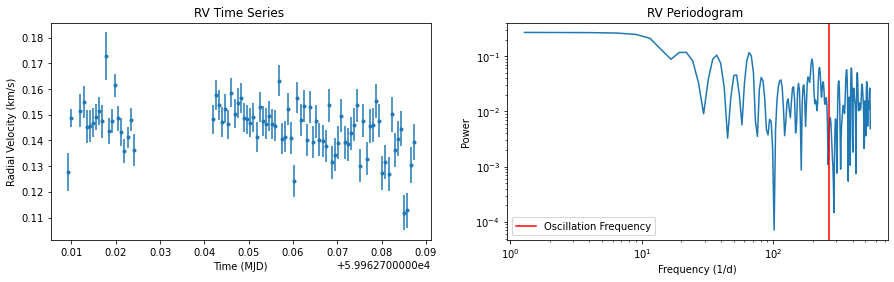

In [28]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_RV_HA, total_RV_err_HA, 'Radial Velocity (km/s)', 'RV', '(HA)', error=True)
    
    AF.plot_TS_Periodo(date_HE, total_RV_HE, total_RV_err_HE, 'Radial Velocity (km/s)', 'RV', '(HE)', error=True)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_RV, total_RV_err, 'Radial Velocity (km/s)', 'RV', '', error=True)

## Plotting the timeseries and periodogram of the FWHM

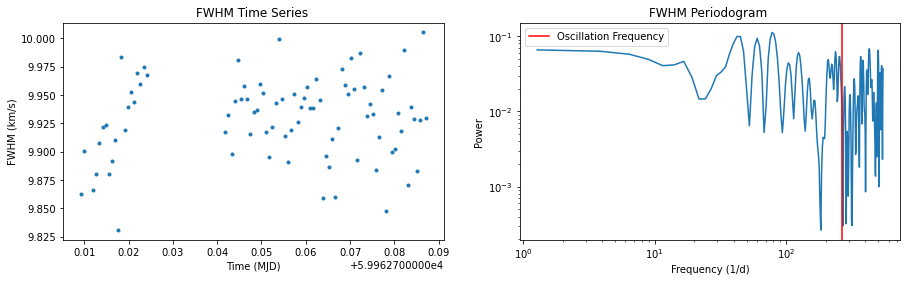

In [29]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_FWHM_HA, [],'FWHM (km/s)', 'FWHM', '(HA)')
    
    AF.plot_TS_Periodo(date_HE, total_FWHM_HE, [],'FWHM (km/s)', 'FWHM', '(HE)')
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_FWHM, [], 'FWHM (km/s)', 'FWHM', '')

## Plotting the timeseries and periodogram of the Bisector Span

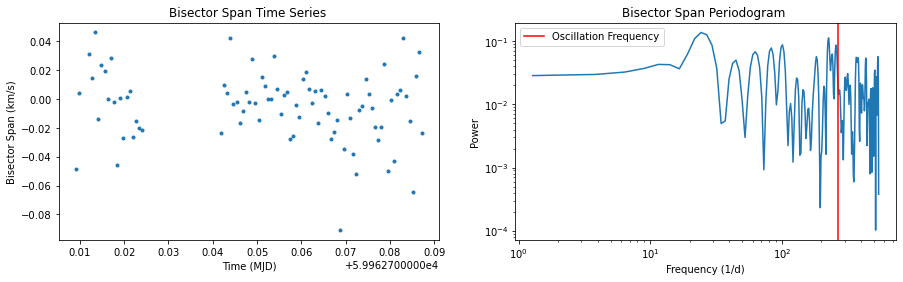

In [30]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_BIS_SPAN_HA, [], 'Bisector Span (km/s)', 'Bisector Span', '(HA)')
    
    AF.plot_TS_Periodo(date_HE, total_BIS_SPAN_HE, [], 'Bisector Span (km/s)', 'Bisector Span', '(HE)')
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_BIS_SPAN, [], 'Bisector Span (km/s)', 'Bisector Span', '')

## Plotting the timeseries and periodogram of H2O IWV

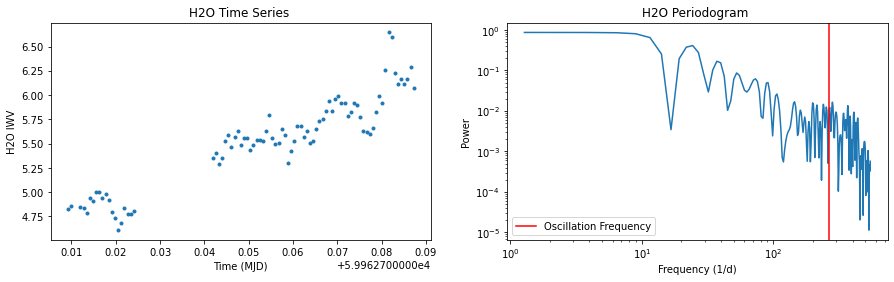

In [31]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_H2O_HA, [], 'H2O IWV', 'H2O', '(HA)')
    
    AF.plot_TS_Periodo(date_HE, total_H2O_HE, [], 'H2O IWV', 'H2O', '(HE)')
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_H2O, [], 'H2O IWV', 'H2O', '')

## Plotting the timeseries and periodogram of O2 IWV

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_81696/817064243.py:9: RankWarning: Polyfit may be poorly conditioned
  AF.plot_TS_Periodo(date, total_O2, [], 'O2 IWV', 'O2', '', fit=True, order=4)


          4         3             2
0.009475 x - 284.1 x - 3.406e+07 x - 1.022e+12 x + 1.225e+17


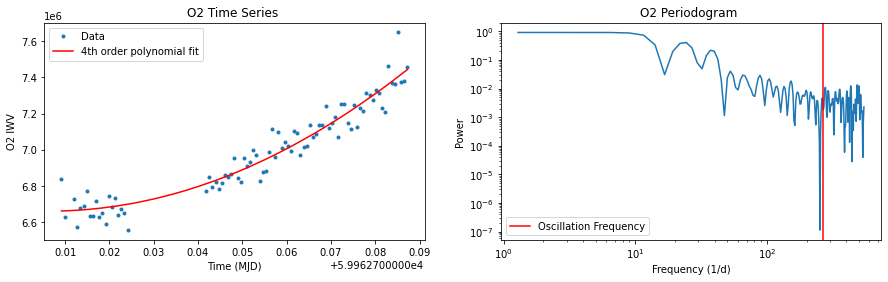

In [32]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_O2_HA, [], 'O2 IWV', 'O2', '(HA)', fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_O2_HE, [], 'O2 IWV', 'O2', '(HE)', fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_O2, [], 'O2 IWV', 'O2', '', fit=True, order=4)

## Plotting the timeseries and periodogram of CO2 IWV

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_81696/1829393102.py:10: RankWarning: Polyfit may be poorly conditioned
  AF.plot_TS_Periodo(date, total_CO2, [], 'CO2 IWV', 'CO2', '', fit=True, order=4)


         4         3             2
0.01636 x - 490.6 x - 5.881e+07 x - 1.764e+12 x + 2.115e+17


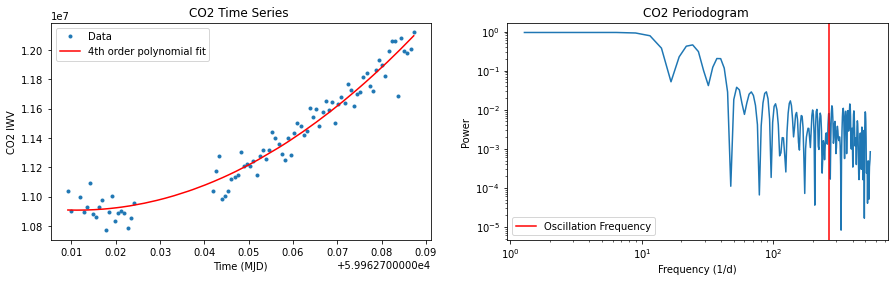

In [33]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_CO2_HA, [], 'CO2 IWV', 'CO2', '(HA)', fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_CO2_HE, [], 'CO2 IWV', 'CO2', '(HE)', fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_CO2, [], 'CO2 IWV', 'CO2', '', fit=True, order=4)

## Fitting a Voigt profile to the Si line

[1.02384094e+00 5.05250216e-01 1.08300779e+04 1.06842447e-04
 2.59904441e-01]


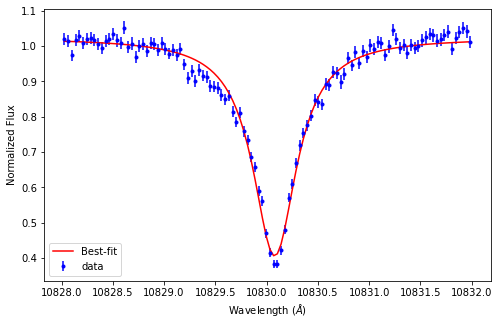

[1.00711437e+00 4.85025449e-01 1.08300797e+04 5.13786095e-05
 2.52110231e-01]


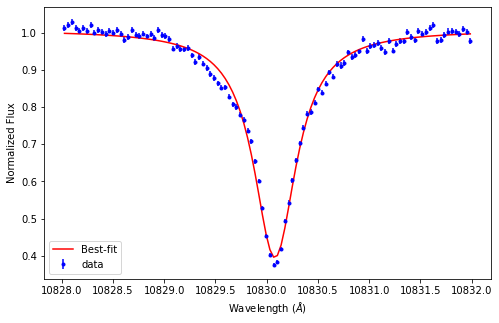

[1.00698295e+00 4.88686491e-01 1.08300801e+04 1.93887040e-05
 2.51651193e-01]


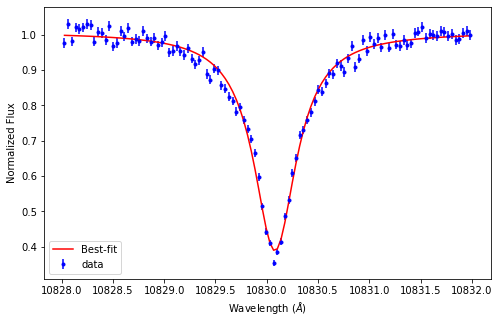

[1.00645066e+00 4.76549107e-01 1.08300756e+04 1.34830946e-06
 2.45533906e-01]


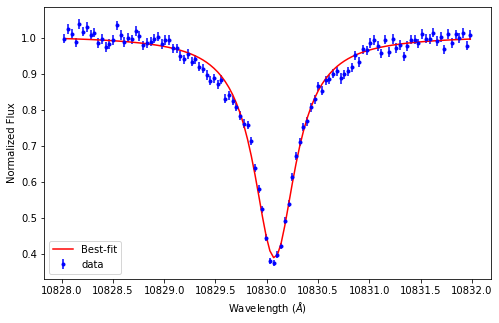

[1.01004839e+00 5.09666791e-01 1.08300822e+04 1.08309888e-06
 2.60697745e-01]


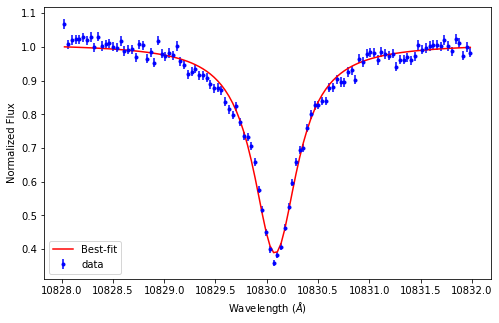

[1.01354242e+00 4.96683469e-01 1.08300759e+04 5.70952686e-06
 2.52669639e-01]


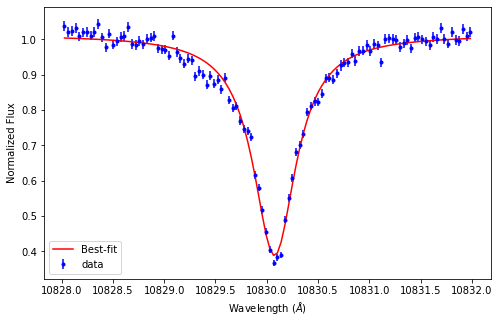

[1.01223627e+00 4.98324422e-01 1.08300787e+04 1.09894342e-05
 2.57257768e-01]


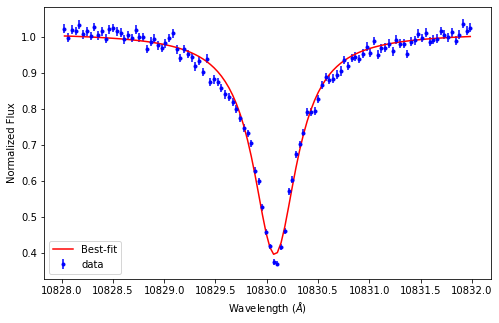

[1.01342897e+00 5.02122956e-01 1.08300771e+04 2.68649294e-05
 2.60843153e-01]


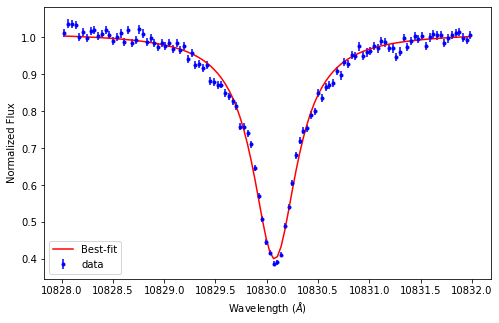

[1.00848906e+00 4.92314441e-01 1.08300769e+04 2.29982062e-04
 2.57135236e-01]


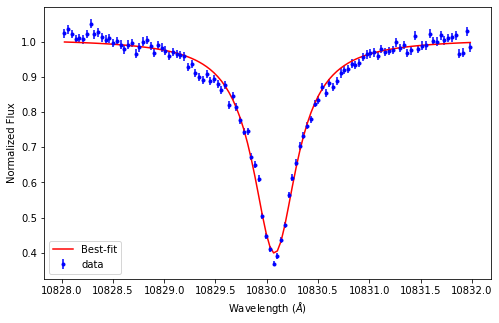

[1.00034029e+00 4.74931863e-01 1.08300828e+04 5.44220059e-04
 2.48439350e-01]


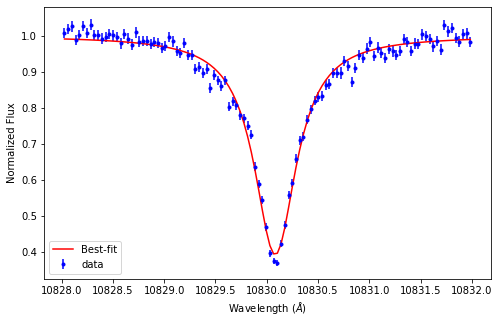

[1.00473757e+00 4.85983878e-01 1.08300818e+04 7.53317421e-06
 2.56049072e-01]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


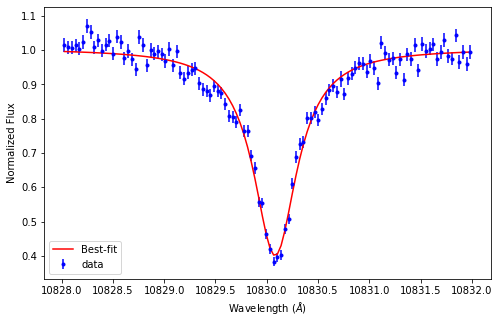

[1.02053597e+00 5.09326555e-01 1.08300803e+04 6.71132300e-05
 2.65956701e-01]


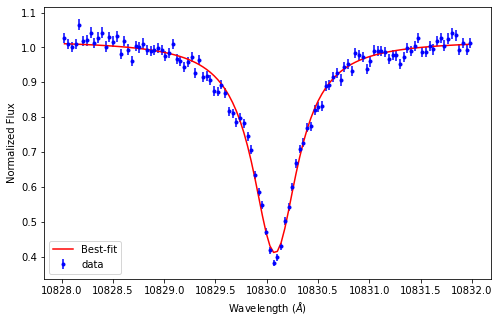

[1.00936395e+00 4.89518422e-01 1.08300780e+04 8.01559470e-06
 2.57592461e-01]


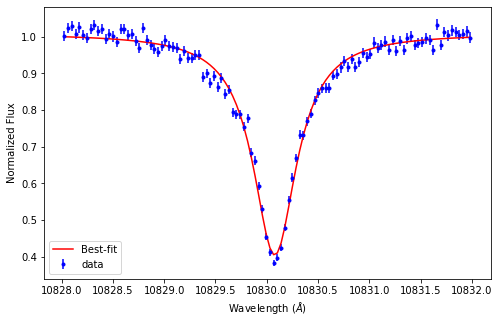

[1.01232283e+00 4.93690119e-01 1.08300809e+04 1.86528886e-05
 2.56697124e-01]


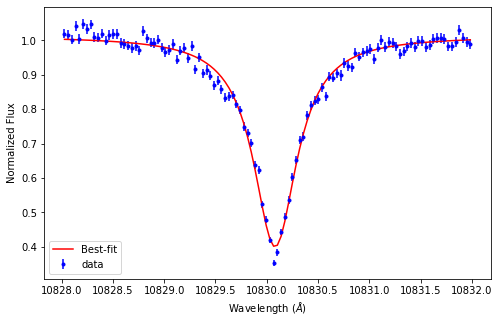

[1.01987519e+00 5.27601465e-01 1.08300808e+04 4.10244119e-06
 2.70823146e-01]


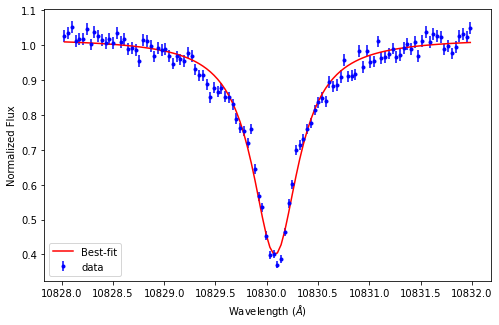

[1.01896344e+00 4.92611410e-01 1.08300779e+04 3.17052527e-05
 2.54983890e-01]


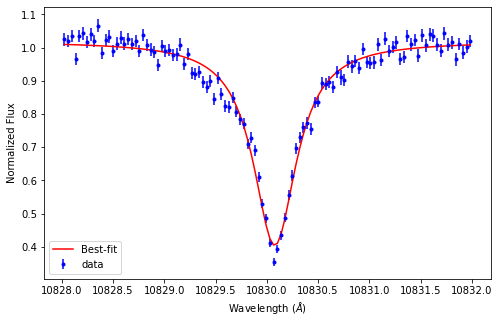

[1.01554732e+00 4.86768660e-01 1.08300772e+04 4.73948649e-05
 2.53419507e-01]


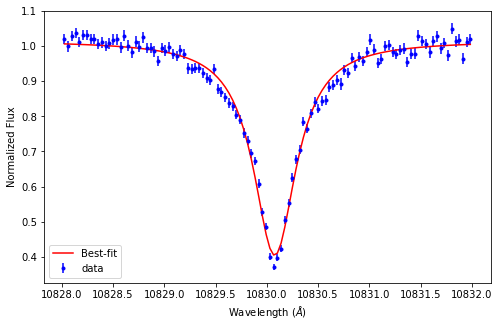

[1.01897393e+00 5.06354714e-01 1.08300826e+04 2.67179859e-06
 2.57855139e-01]


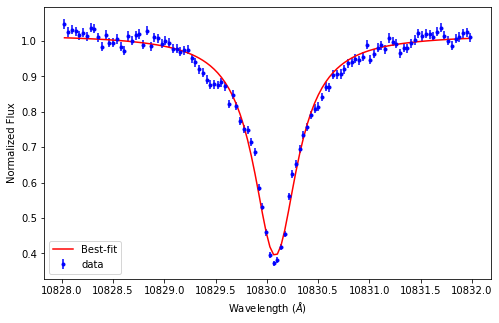

[1.01805331e+00 5.08767696e-01 1.08300821e+04 2.78744608e-07
 2.64448321e-01]


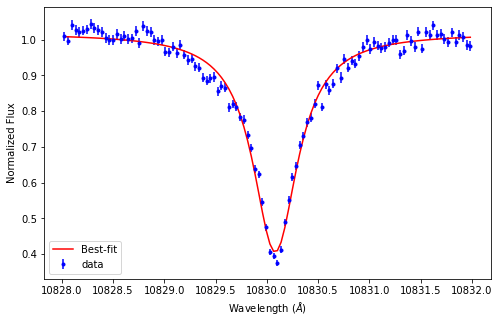

[1.00800171e+00 4.97720294e-01 1.08300781e+04 3.60313529e-05
 2.60665504e-01]


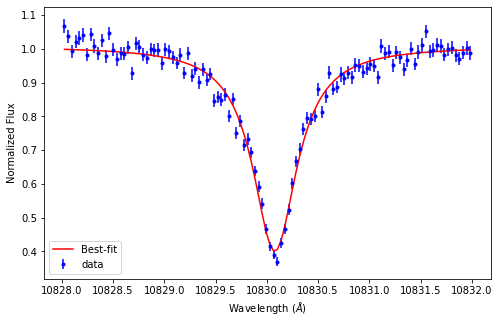

[1.01303469e+00 4.96471652e-01 1.08300768e+04 1.29086577e-04
 2.57570225e-01]


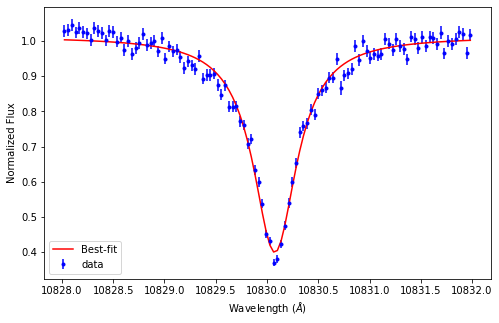

[1.02353455e+00 4.96154976e-01 1.08300807e+04 1.76706032e-04
 2.53627219e-01]


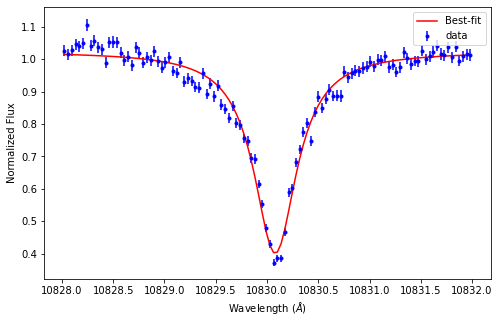

[1.01108746e+00 4.84919365e-01 1.08300792e+04 1.63103982e-03
 2.48066860e-01]


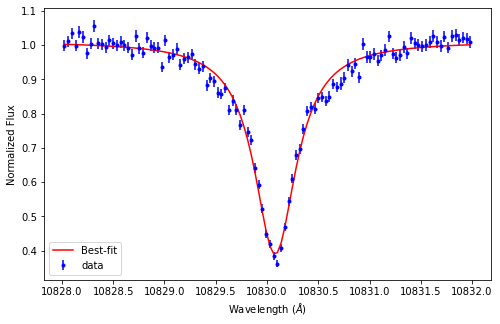

[1.01725975e+00 4.92564080e-01 1.08300792e+04 6.96775434e-06
 2.51450278e-01]


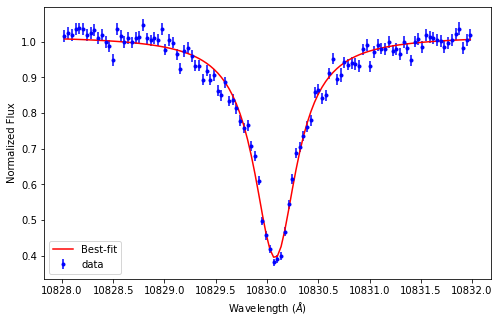

[1.01884413e+00 5.06240214e-01 1.08300794e+04 2.25558921e-05
 2.58817367e-01]


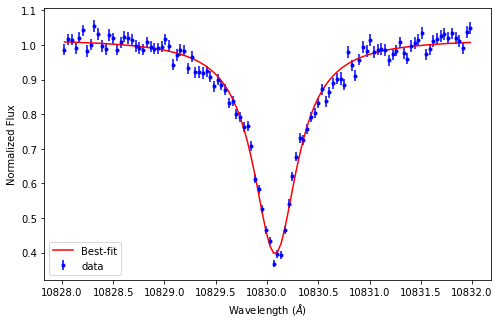

[1.01497634e+00 4.95724726e-01 1.08300791e+04 6.31098301e-06
 2.56576340e-01]


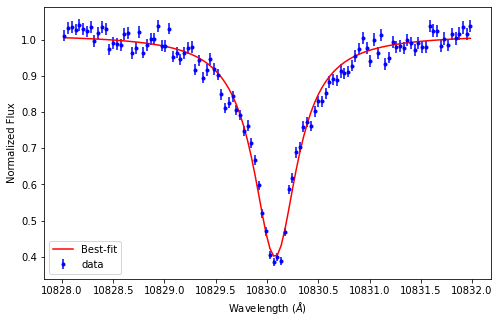

[1.01828198e+00 5.05354551e-01 1.08300825e+04 5.25578548e-06
 2.62632729e-01]


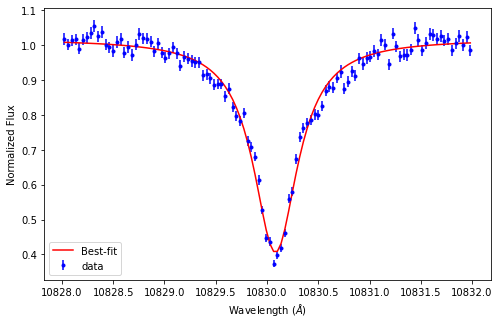

[1.01128425e+00 4.94670285e-01 1.08300858e+04 3.05011921e-04
 2.54194089e-01]


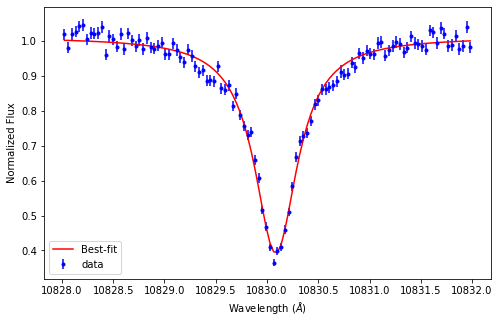

[1.01544124e+00 4.93140607e-01 1.08300778e+04 5.85730817e-04
 2.53856702e-01]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


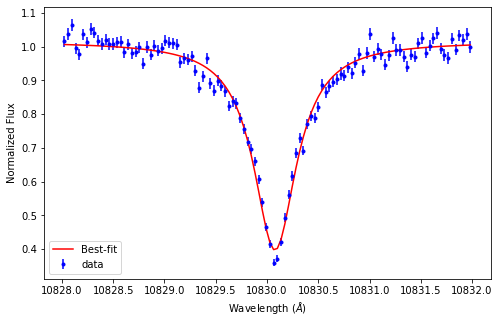

[1.03192488e+00 5.40877386e-01 1.08300786e+04 1.89057685e-07
 2.79043856e-01]


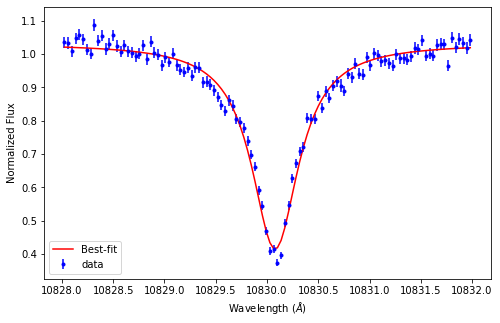

[1.01286356e+00 4.92996872e-01 1.08300780e+04 4.30364184e-05
 2.58799414e-01]


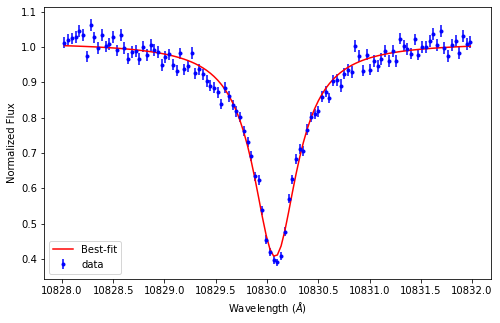

[1.01879173e+00 5.15528757e-01 1.08300801e+04 1.12569487e-04
 2.64374706e-01]


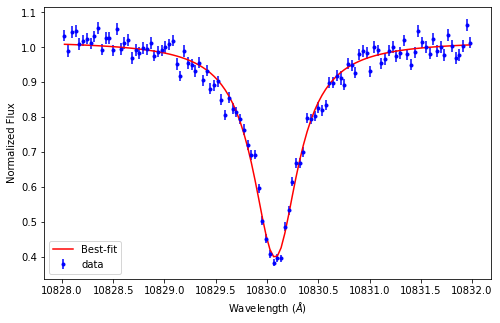

[1.01190719e+00 4.79072227e-01 1.08300811e+04 3.07592383e-04
 2.50338451e-01]


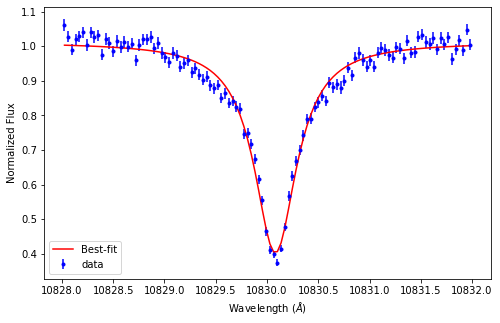

[1.00905626e+00 4.72919562e-01 1.08300813e+04 5.88637094e-05
 2.39935692e-01]


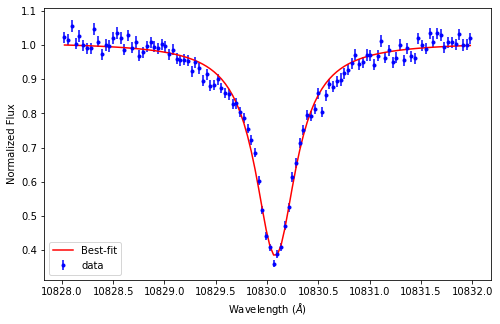

[1.01942958e+00 5.11918381e-01 1.08300802e+04 2.34977668e-05
 2.62221106e-01]


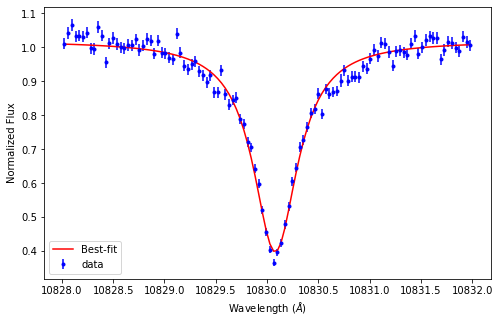

[1.01433951e+00 4.85654979e-01 1.08300818e+04 1.63711948e-05
 2.51244311e-01]


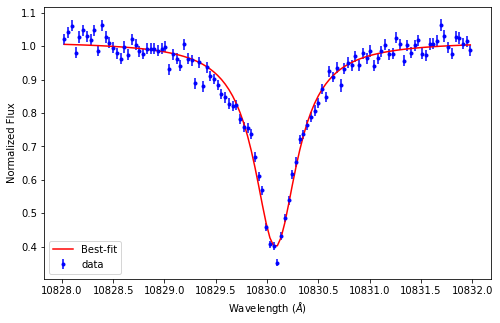

[1.01711682e+00 4.99069726e-01 1.08300851e+04 1.74011188e-05
 2.48781521e-01]


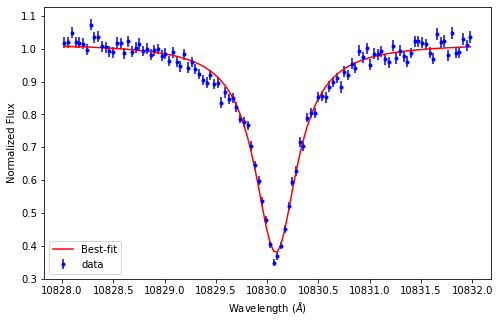

[1.01736835e+00 5.09020484e-01 1.08300723e+04 2.58197195e-05
 2.61240358e-01]


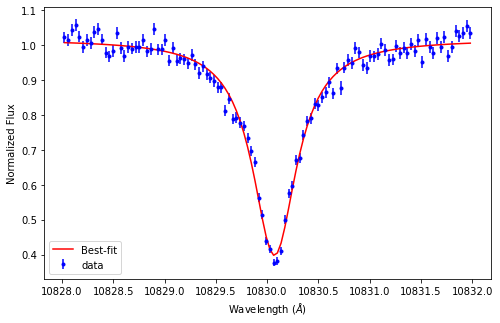

[1.00851716e+00 4.79475912e-01 1.08300790e+04 1.48988792e-05
 2.44752571e-01]


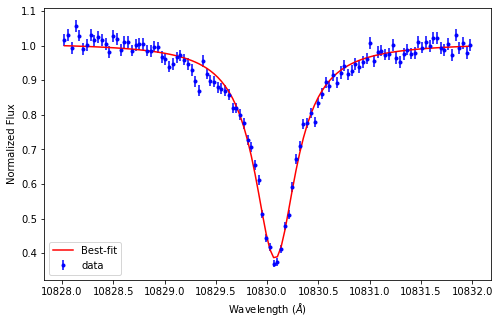

[1.01635882e+00 4.92026908e-01 1.08300770e+04 3.87948207e-05
 2.57936504e-01]


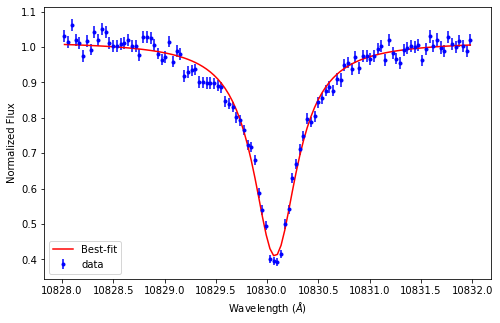

[1.01489352e+00 4.77194523e-01 1.08300808e+04 3.35158996e-05
 2.46721713e-01]


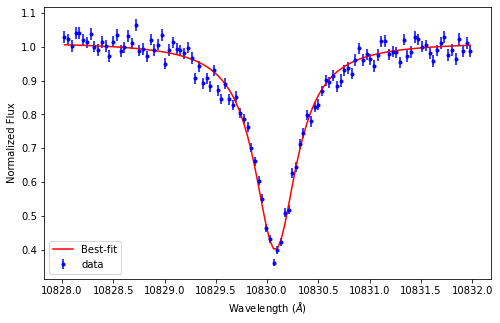

[1.01468390e+00 5.09873118e-01 1.08300790e+04 3.08188818e-05
 2.58512256e-01]


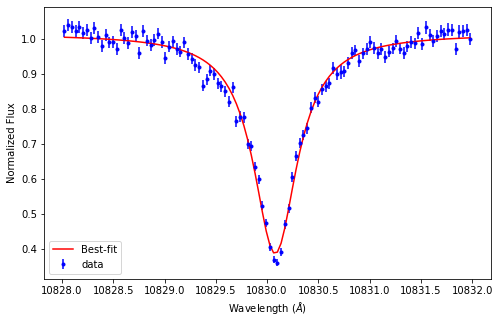

[1.01202992e+00 4.96200582e-01 1.08300826e+04 5.59276562e-06
 2.57406388e-01]


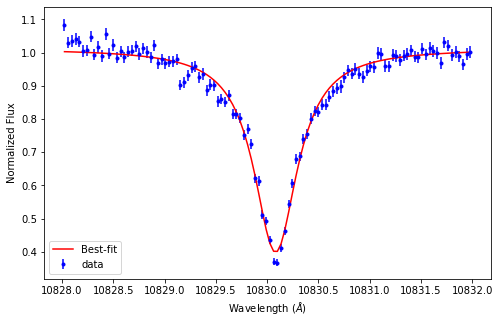

[1.02505491e+00 5.47298454e-01 1.08300791e+04 8.72071482e-06
 2.87507369e-01]


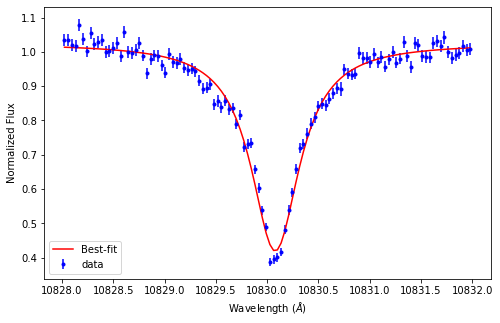

[1.01187402e+00 5.04024509e-01 1.08300801e+04 7.51661047e-06
 2.57553430e-01]


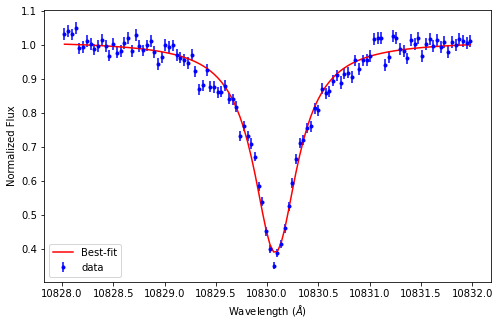

[1.01733533e+00 4.94678685e-01 1.08300714e+04 1.51491696e-04
 2.54648568e-01]


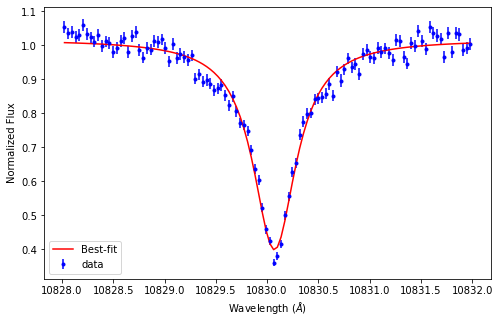

[1.00853837e+00 4.93904848e-01 1.08300806e+04 2.26608716e-06
 2.56432024e-01]


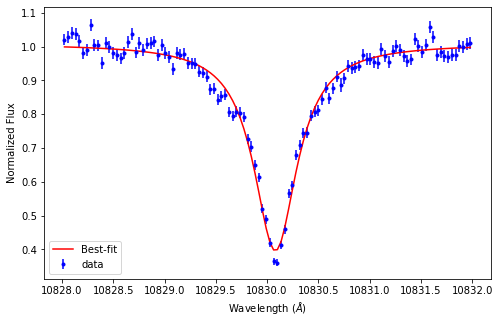

[1.01494269e+00 4.93679258e-01 1.08300795e+04 2.08238764e-05
 2.54446473e-01]


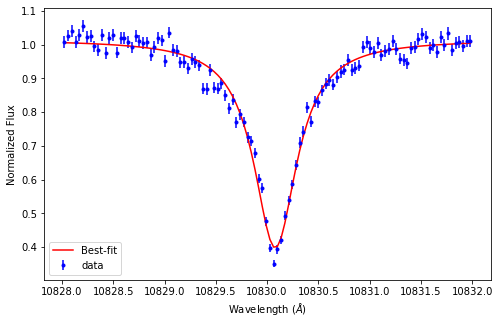

[1.01893311e+00 5.27025822e-01 1.08300820e+04 9.42659892e-06
 2.71699087e-01]


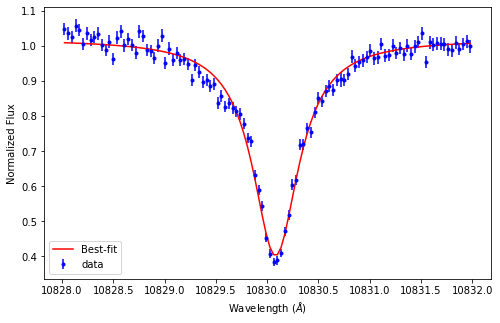

[1.01270980e+00 4.88275029e-01 1.08300786e+04 7.73706205e-05
 2.50645816e-01]


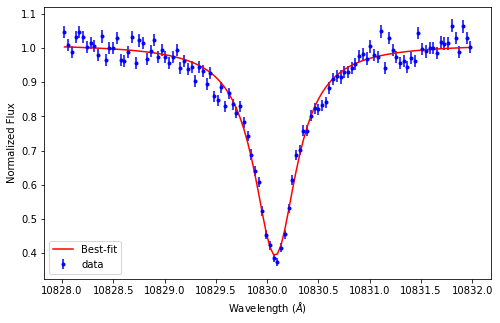

[1.01254019e+00 4.88937652e-01 1.08300775e+04 3.92794574e-05
 2.54333904e-01]


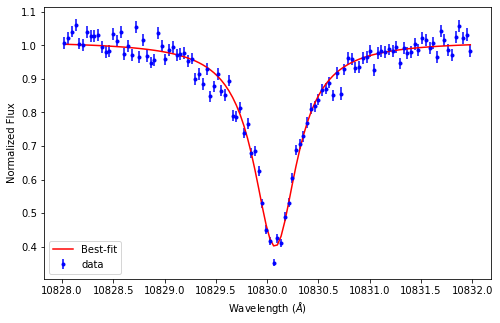

[1.01659830e+00 5.06063651e-01 1.08300799e+04 2.38265965e-04
 2.61713016e-01]


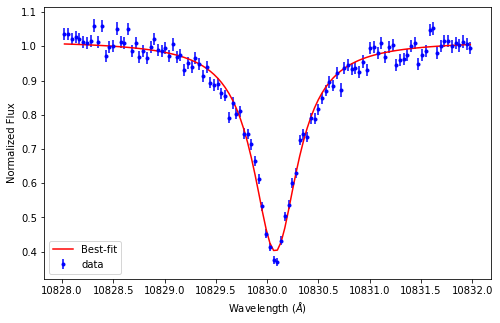

[1.02003385e+00 4.90736493e-01 1.08300776e+04 2.01559978e-05
 2.55793539e-01]


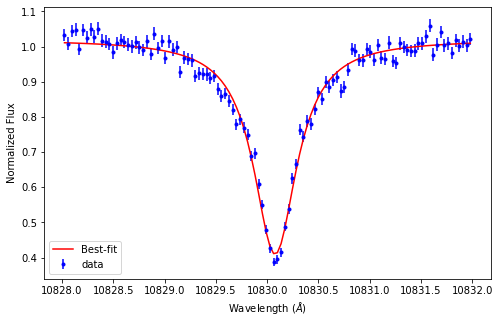

[1.01695341e+00 5.11695731e-01 1.08300758e+04 7.81309474e-06
 2.66967981e-01]


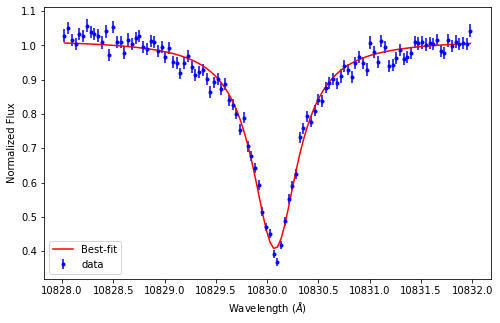

[1.00874525e+00 4.78300202e-01 1.08300763e+04 1.02458996e-03
 2.49291564e-01]


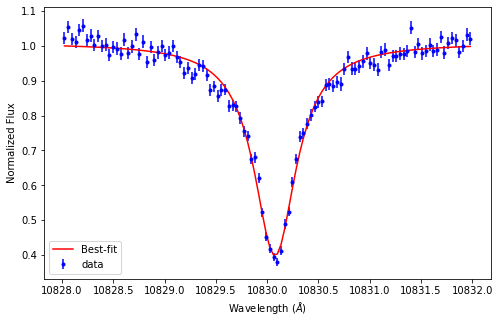

[1.01878382e+00 5.10078026e-01 1.08300847e+04 2.20267395e-04
 2.61838551e-01]


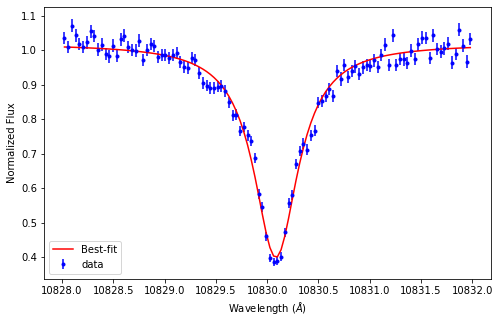

[1.00909014e+00 5.00637085e-01 1.08300793e+04 1.14787301e-03
 2.61526208e-01]


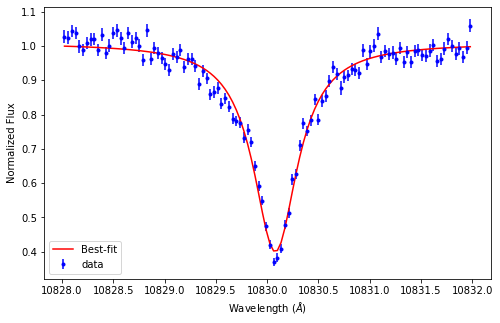

[1.02082184e+00 5.07830196e-01 1.08300836e+04 4.17486130e-06
 2.62882042e-01]


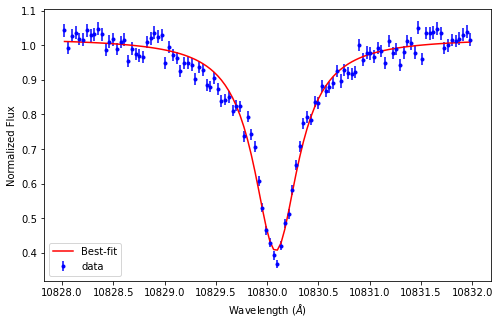

[1.01255151e+00 4.99676473e-01 1.08300800e+04 3.92441087e-06
 2.61270924e-01]


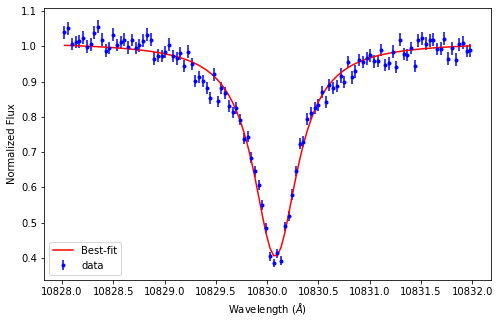

[1.01733452e+00 4.90222323e-01 1.08300782e+04 2.64831388e-05
 2.53778535e-01]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


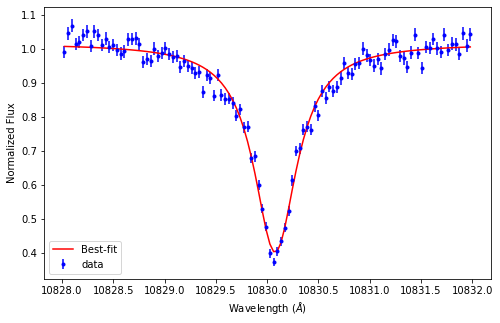

[1.01206860e+00 5.00205688e-01 1.08300793e+04 1.02720287e-04
 2.56537549e-01]


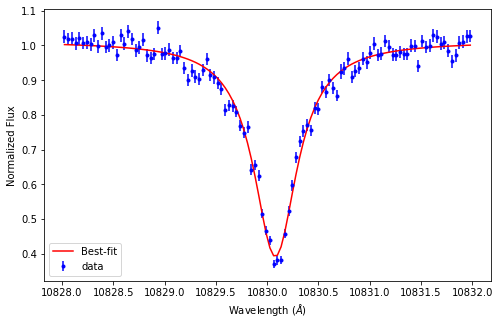

[1.01285601e+00 5.03327277e-01 1.08300763e+04 1.19927680e-06
 2.60182337e-01]


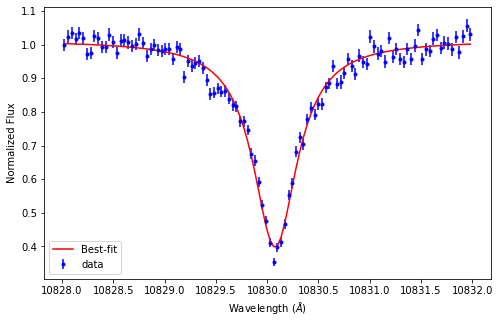

[1.00896002e+00 4.92713239e-01 1.08300786e+04 3.63431367e-06
 2.53909333e-01]


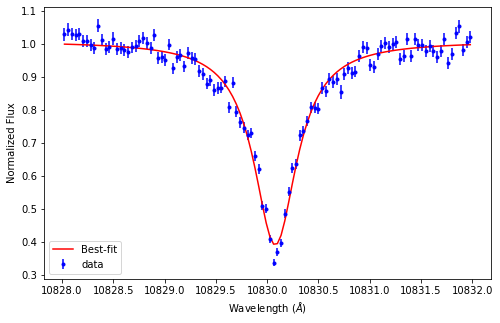

[1.00967523e+00 4.88350731e-01 1.08300832e+04 1.11005929e-03
 2.57117775e-01]


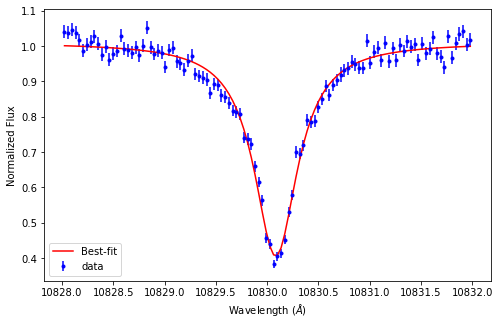

[1.01755913e+00 5.10193722e-01 1.08300806e+04 1.09287793e-04
 2.66005318e-01]


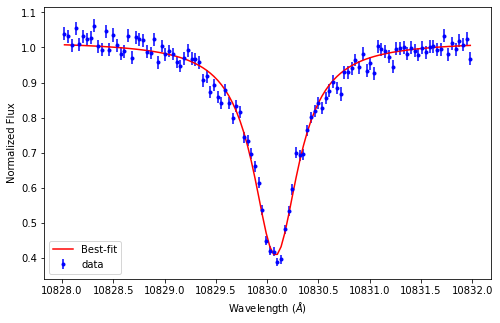

[1.01078965e+00 4.83519208e-01 1.08300764e+04 1.06620775e-04
 2.51003601e-01]


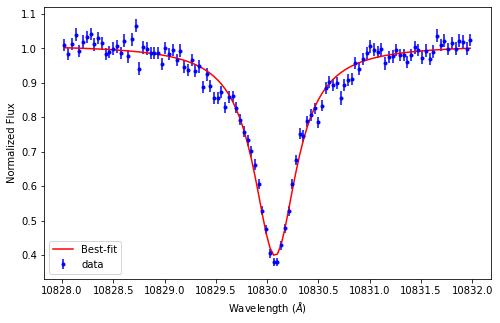

[1.00545378e+00 4.79072560e-01 1.08300770e+04 1.98275506e-05
 2.52204237e-01]


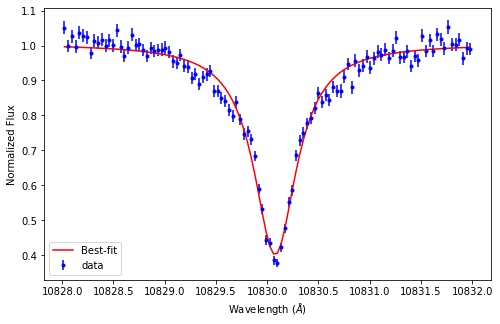

[1.02226402e+00 5.16734567e-01 1.08300762e+04 1.29824961e-06
 2.67655873e-01]


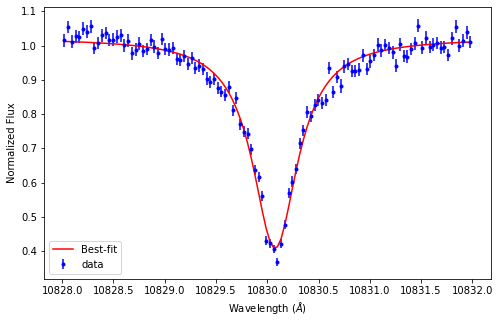

[1.01893223e+00 4.88877570e-01 1.08300782e+04 2.54332402e-05
 2.51122911e-01]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


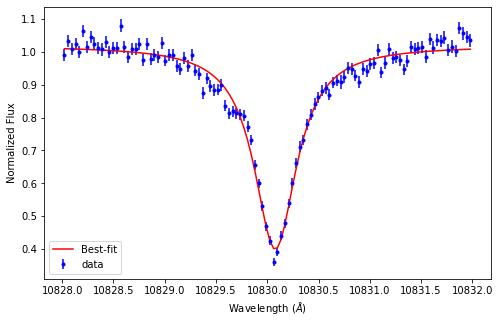

[1.01740605e+00 5.14988913e-01 1.08300738e+04 2.16939166e-06
 2.74065605e-01]


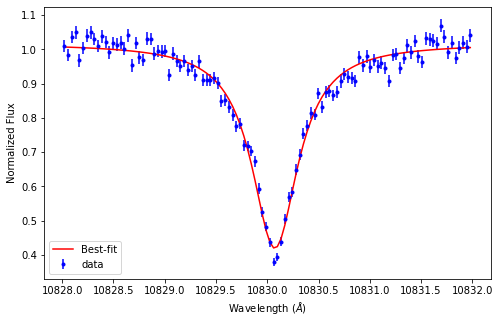

[1.01023430e+00 4.82322665e-01 1.08300791e+04 1.17409492e-05
 2.58458632e-01]


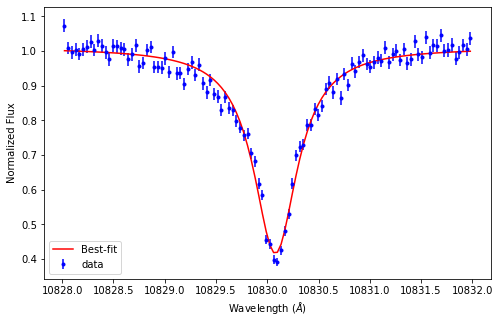

[1.01000144e+00 4.91507432e-01 1.08300762e+04 9.21213205e-05
 2.56445572e-01]


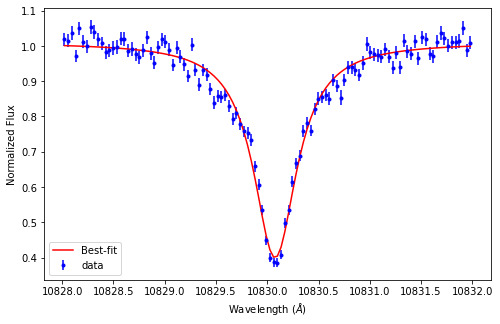

[1.01032189e+00 4.93946403e-01 1.08300848e+04 6.28043295e-05
 2.57678184e-01]


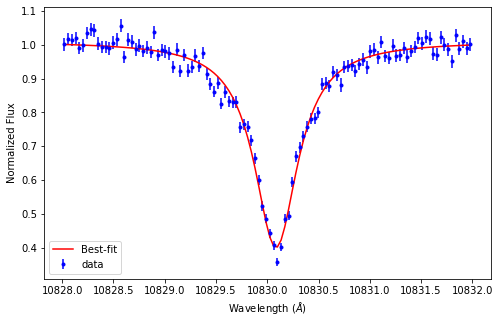

[1.00980470e+00 4.93003249e-01 1.08300806e+04 6.64463998e-06
 2.56647869e-01]


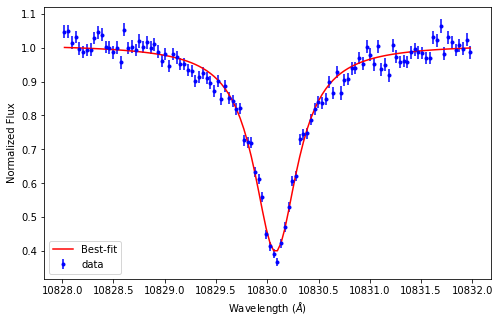

[1.01585740e+00 4.85812123e-01 1.08300782e+04 4.39486324e-07
 2.54460566e-01]


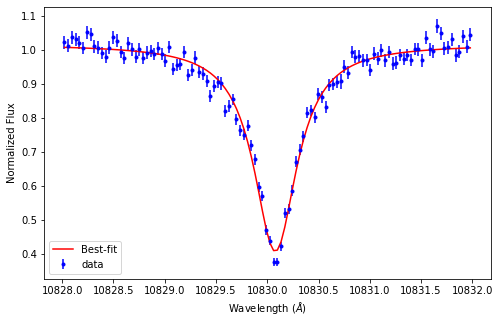

[1.01060040e+00 4.94737677e-01 1.08300821e+04 1.86020076e-04
 2.56996165e-01]


/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


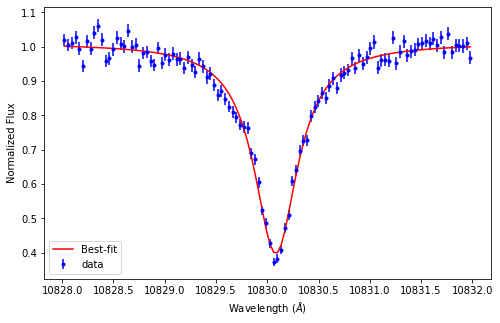

[1.01810884e+00 4.84707819e-01 1.08300820e+04 2.87199294e-05
 2.54591995e-01]


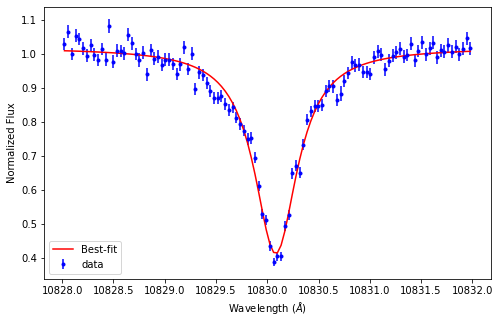

[1.01082455e+00 4.88645869e-01 1.08300762e+04 3.45518554e-05
 2.54947407e-01]


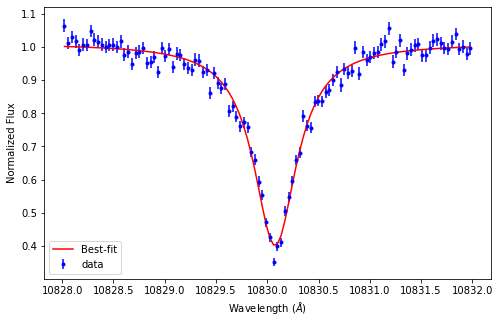

[1.01412458e+00 4.89810051e-01 1.08300779e+04 8.29829170e-04
 2.48405219e-01]


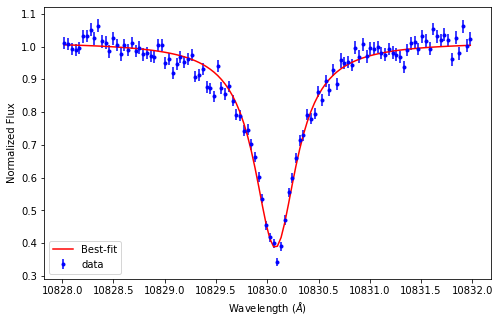

[1.01702194e+00 5.06466892e-01 1.08300762e+04 3.01862091e-05
 2.64920810e-01]


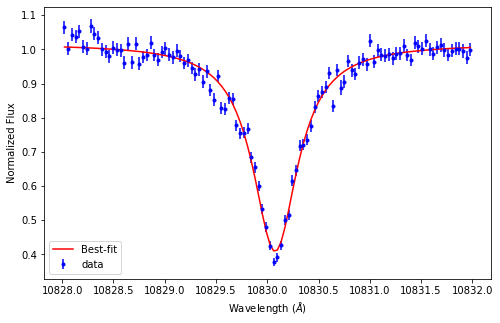

[1.00697851e+00 4.71514180e-01 1.08300871e+04 5.70198808e-05
 2.44844202e-01]


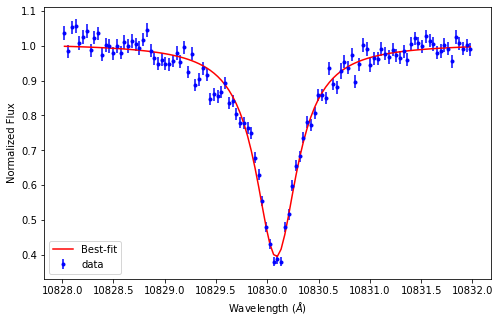

[1.01306649e+00 4.91177584e-01 1.08300756e+04 9.78478748e-05
 2.52764460e-01]


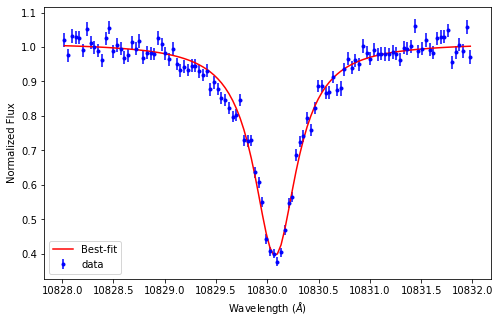

[1.01206729e+00 4.98305728e-01 1.08300758e+04 5.45064468e-04
 2.66023410e-01]


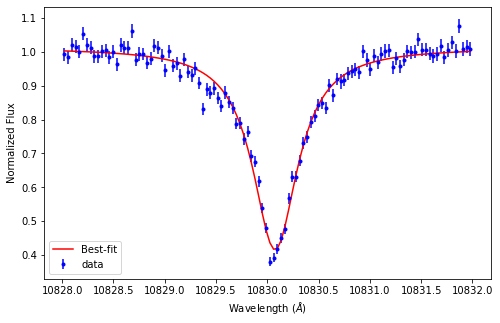

[1.01296900e+00 5.18229502e-01 1.08300773e+04 2.06232979e-05
 2.67799432e-01]


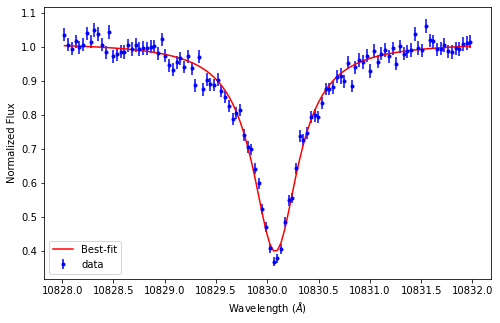

[1.01512656e+00 4.99439649e-01 1.08300859e+04 3.25718516e-05
 2.59868723e-01]


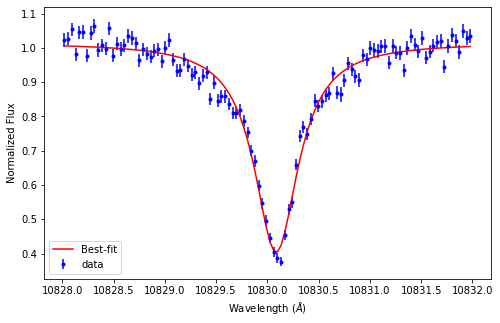

In [34]:
lower_l = 10828
upper_l = 10832

guess_para = [0.3, 0.6, 10830, 0.1, 0.2]
bound = ((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf))

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    theta_Si_HA, err_theta_Si_HA = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda_HA, total_norm_spctr_HA, total_norm_err_HA, 'r')
    
    theta_Si_HE, err_theta_Si_HE = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda_HE, total_norm_spctr_HE, total_norm_err_HE, 'k')

#If there is one mode of observation
else:
    
    theta_Si, err_theta_Si = AF.fit_spctr_line(AF.Voigt, AF.eval_Voigt, lower_l, upper_l, guess_para, bound, 
                  total_lamda, total_norm_spctr, total_norm_err, 'r')

## Plotting the positions, depths and widths of the fitted Gaussian lines for Si

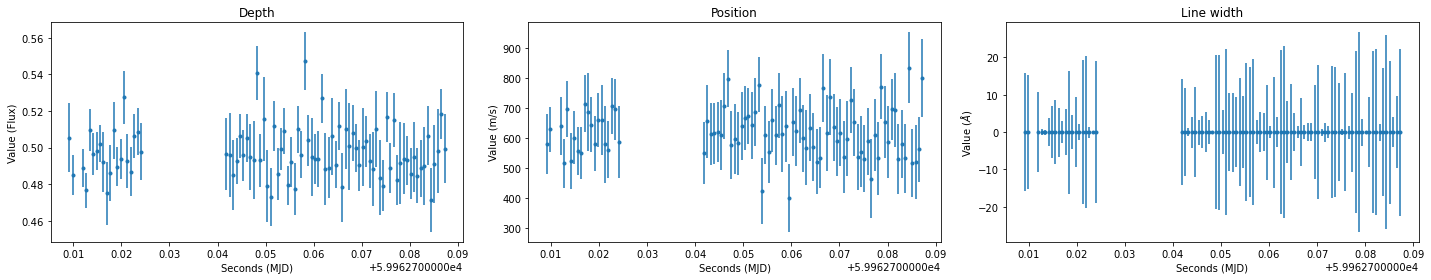

In [35]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ref_Si = AF.air2vac(10827.091)

    ax1.errorbar(date_HA, theta_Si_HA[:, 1], yerr=err_theta_Si_HA[:, 1], fmt='.')
    ax2.errorbar(date_HA, (theta_Si_HA[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si_HA[:, 2]*3e8/ref_Si, fmt='.')
    ax3.errorbar(date_HA, theta_Si_HA[:, 3], yerr=err_theta_Si_HA[:, 3], fmt='.')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')

    fig.tight_layout()
    plt.savefig('Plot_Results/Si_Voigt_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[20, 4])

    ax4.errorbar(date_HE, theta_Si_HE[:, 1], yerr=err_theta_Si_HE[:, 1], fmt='.')
    ax5.errorbar(date_HE, (theta_Si_HE[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si_HE[:, 2]*3e8/ref_Si, fmt='.')
    ax6.errorbar(date_HE, theta_Si_HE[:, 3], yerr=err_theta_Si_HE[:, 3], fmt='.')
    ax4.set_xlabel('Seconds (MJD)')
    ax5.set_xlabel('Seconds (MJD)')
    ax6.set_xlabel('Seconds (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')

    fig.tight_layout()
    plt.savefig('Plot_Results/Si_Voigt_Fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ref_Si = AF.air2vac(10827.091)

    ax1.errorbar(date, theta_Si[:, 1], yerr=err_theta_Si[:, 1], fmt='.')
    ax2.errorbar(date, (theta_Si[:, 2]-ref_Si)*3e8/ref_Si, yerr=err_theta_Si[:, 2]*3e8/ref_Si, fmt='.')
    ax3.errorbar(date, theta_Si[:, 3], yerr=err_theta_Si[:, 3], fmt='.')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')

    fig.tight_layout()
    plt.savefig('Plot_Results/Si_Voigt_Fit.pdf')
    plt.show()


## Periodogram for the position, depth and width of the Si line

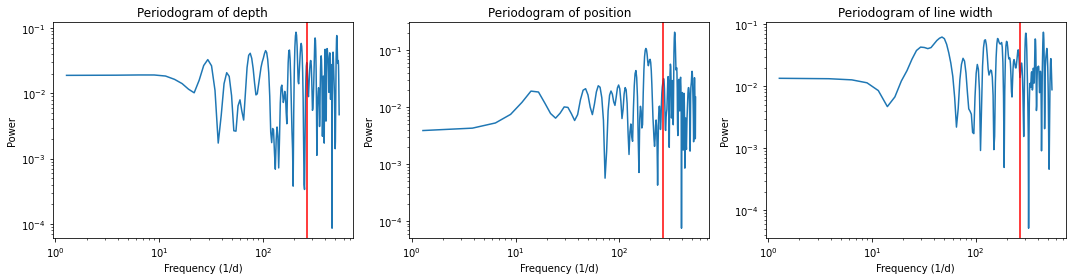

In [36]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si_HA = LombScargle(date_HA, theta_Si_HA[:, 3]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_Si_HA[0], LS_depth_Si_HA[1])
    ax2.loglog(LS_position_Si_HA[0], LS_position_Si_HA[1])
    ax3.loglog(LS_width_Si_HA[0], LS_width_Si_HA[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax1.set_title('Periodogram of depth for HA')
    ax2.set_title('Periodogram of position for HA')
    ax3.set_title('Periodogram of line width for HA')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    plt.savefig('Plot_Results/Periodogram_Si_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si_HE = LombScargle(date_HE, theta_Si_HE[:, 3]).autopower(nyquist_factor=1)

    ax4.loglog(LS_depth_Si_HE[0], LS_depth_Si_HE[1])
    ax5.loglog(LS_position_Si_HE[0], LS_position_Si_HE[1])
    ax6.loglog(LS_width_Si_HE[0], LS_width_Si_HE[1])
    ax4.set_xlabel('Frequency (1/d)')
    ax5.set_xlabel('Frequency (1/d)')
    ax6.set_xlabel('Frequency (1/d)')
    ax4.set_ylabel('Power')
    ax5.set_ylabel('Power')
    ax6.set_ylabel('Power')
    ax4.set_title('Periodogram of depth for HE')
    ax5.set_title('Periodogram of position for HE')
    ax6.set_title('Periodogram of line width for HE')
    ax4.axvline(oscillation_freq, color='r')
    ax5.axvline(oscillation_freq, color='r')
    ax6.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    plt.savefig('Plot_Results/Periodogram_Si_Fit_HE.pdf')
    plt.show()
    
#If there is one mode of observation
else:
    
    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[15, 4])

    LS_depth_Si = LombScargle(date, theta_Si[:, 1]).autopower(nyquist_factor=1)
    LS_position_Si = LombScargle(date, theta_Si[:, 2]).autopower(nyquist_factor=1)
    LS_width_Si = LombScargle(date, theta_Si[:, 3]).autopower(nyquist_factor=1)

    ax1.loglog(LS_depth_Si[0], LS_depth_Si[1])
    ax2.loglog(LS_position_Si[0], LS_position_Si[1])
    ax3.loglog(LS_width_Si[0], LS_width_Si[1])
    ax1.set_xlabel('Frequency (1/d)')
    ax2.set_xlabel('Frequency (1/d)')
    ax3.set_xlabel('Frequency (1/d)')
    ax1.set_ylabel('Power')
    ax2.set_ylabel('Power')
    ax3.set_ylabel('Power')
    ax1.set_title('Periodogram of depth')
    ax2.set_title('Periodogram of position')
    ax3.set_title('Periodogram of line width')
    ax1.axvline(oscillation_freq, color='r')
    ax2.axvline(oscillation_freq, color='r')
    ax3.axvline(oscillation_freq, color='r')
    fig.tight_layout()
    plt.savefig('Plot_Results/Periodogram_Si_Fit.pdf')
    plt.show()


## Checking the impact of tellurics

In [37]:
tot_spctr_NC = np.zeros((len(os.listdir(dir_name)), 4084))
tot_norm_spctr_NC = np.zeros((len(os.listdir(dir_name)), 4084))
tot_err_NC = np.zeros((len(os.listdir(dir_name)), 4084))
tot_norm_err_NC = np.zeros((len(os.listdir(dir_name)), 4084))
tot_telluric = np.zeros((len(os.listdir(dir_name)), 4084))

In [38]:
reload(AF) 

order_ES = 14

#Defining the Sun's BB for later.
Sun_BB = models.BlackBody(temperature = 5778*u.K)
    
for i in range(len(os.listdir(dir_name))):
    file = pf.open(dir_name+'/'+sorted(os.listdir(dir_name))[i])
    file_lamda = file[4].data[order_ES]
    file_spctr = file[1].data[order_ES]
    file_err = file[2].data[order_ES]
    file_telluric = file[11].data[order_ES]
    file_DLL = file[6].data[order_ES]

    #Getting the telluric spectra
    tot_telluric[i] = file_telluric
         
    #Getting the wavelength and error on the flux
    tot_err_NC[i] = file_err
    
    #Distinguish two cases depending on the number of modes of observation
    #If there are two modes of observation
    if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

        #Performing Blaze correction
        for j in range(len(os.listdir(blaze_dir))):
            file_blaze = pf.open(blaze_dir+'/'+os.listdir(blaze_dir)[j])
            if file_blaze[0].header['HIERARCH ESO INS MODE'][1] == 'A':
                blaze_HA = file_blaze
            else:
                blaze_HE = file_blaze

        #Getting the Blaze spectra for each mode of observation.
        blaze_HA_spctr = blaze_HA[1].data[order_ES]
        blaze_HE_spctr = blaze_HE[1].data[order_ES]

        if file[0].header['HIERARCH ESO INS MODE'] == 'HA':
            A = file_spctr/blaze_HA_spctr
            A_err = file_err/blaze_HA_spctr
        else: 
            A = file_spctr/blaze_HE_spctr
            A_err = file_err/blaze_HE_spctr

        #Removing the trend of the spectrum's continuum using DLL and the Sun's Black Body spectrum.
        B = A/file_DLL
        B_err = A_err/file_DLL

        tot_spctr_NC[i] = B / Sun_BB(file_lamda*u.AA).value
        tot_err_NC[i] = B_err / Sun_BB(file_lamda*u.AA).value
    
        #Making the normalized spectra and error bars.
        tot_norm_spctr_NC[i] = tot_spctr_NC[i]/np.mean(tot_spctr_NC[i])
        tot_norm_err_NC[i] = tot_err_NC[i]/np.mean(tot_spctr_NC[i])
        
    #If there is one mode of observation
    else:
        #Performing the Blaze correction.
        file_blaze = pf.open(blaze_dir+'/'+os.listdir(blaze_dir)[0])
        
        blaze_spctr = file_blaze[1].data[order_ES]
        
        A = file_spctr / blaze_spctr
        A_err = file_err / blaze_spctr
        
        #Removing the trend of the spectrum's continuum using DLL and the Sun's Black Body spectrum.
        B = A/file_DLL
        B_err = A_err/file_DLL
        
        tot_spctr_NC[i] = B / Sun_BB(file_lamda*u.AA).value
        tot_err_NC[i] = B_err / Sun_BB(file_lamda*u.AA).value
        
        #Making the normalized spectra and error bars.
        tot_norm_spctr_NC[i] = tot_spctr_NC[i]/np.mean(tot_spctr_NC[i])
        tot_norm_err_NC[i] = tot_err_NC[i]/np.mean(tot_spctr_NC[i])

In [39]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    total_spctr_NC_HA, total_spctr_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_spctr_NC, tot_RV, cut, threshold)

    total_norm_spctr_NC_HA, total_norm_spctr_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_norm_spctr_NC, tot_RV, cut, threshold)

    total_err_NC_HA, total_err_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_err_NC, tot_RV, cut, threshold)

    total_norm_err_NC_HA, total_norm_err_NC_HE = AF.segment_and_reduce(mode, tot_SNR, tot_norm_err_NC, tot_RV, cut, threshold)

    total_telluric_HA, total_telluric_HE = AF.segment_and_reduce(mode, tot_SNR, tot_telluric, tot_RV, cut, threshold)

#If there is one mode of observation
else:
    
    total_spctr_NC = AF.segment_and_reduce(mode, tot_SNR, tot_spctr_NC, tot_RV, cut, threshold)

    total_norm_spctr_NC = AF.segment_and_reduce(mode, tot_SNR, tot_norm_spctr_NC, tot_RV, cut, threshold)

    total_err_NC = AF.segment_and_reduce(mode, tot_SNR, tot_err_NC, tot_RV, cut, threshold)

    total_norm_err_NC = AF.segment_and_reduce(mode, tot_SNR, tot_norm_err_NC, tot_RV, cut, threshold)

    total_telluric = AF.segment_and_reduce(mode, tot_SNR, tot_telluric, tot_RV, cut, threshold)


[]
[]
[]
[]
[]


## PLotting the telluric spectra and the diff between the TC and not TC spectra

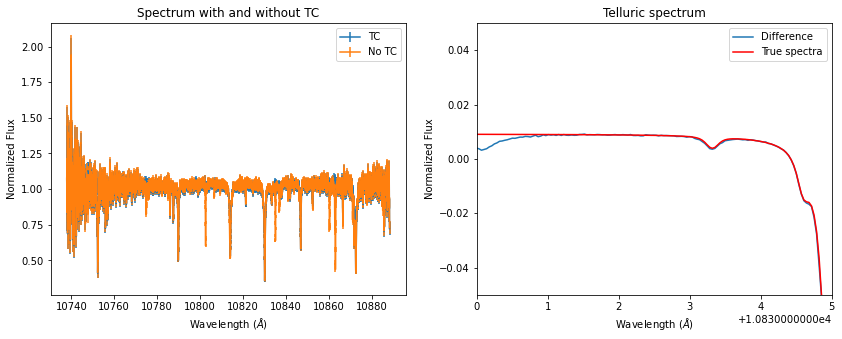

In [40]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
idx=2
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 5])
    ax1.errorbar(total_lamda_HA[idx], total_norm_spctr_HA[idx], yerr=total_norm_err_HA[idx], label='TC')
    ax1.errorbar(total_lamda_HA[idx], total_norm_spctr_NC_HA[idx], yerr=total_norm_err_NC_HA[idx], label='No TC')
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Normalized Flux')
    ax1.set_title('Spectrum with and without TC for HA')
    ax1.legend()

    diff = total_norm_spctr_NC_HA[idx] - total_norm_spctr_HA[idx]
    ax2.plot(total_lamda_HA[idx], diff, label='Difference')
    ax2.plot(total_lamda_HA[idx], total_telluric_HA[idx]-np.mean(total_telluric_HA[idx]), 'r', label='True spectra')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title('Telluric spectra for HA')
    ax2.legend()
    ax2.set_xlim([10830, 10835])
    ax2.set_ylim([-0.05, 0.05])
    plt.savefig('Plot_Results/Telluric_Spectrum_HA.pdf')
    plt.show()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 5])
    ax1.errorbar(total_lamda_HE[idx], total_norm_spctr_HE[idx], yerr=total_norm_err_HE[idx], label='TC')
    ax1.errorbar(total_lamda_HE[idx], total_norm_spctr_NC_HE[idx], yerr=total_norm_err_NC_HE[idx], label='No TC')
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Normalized Flux')
    ax1.set_title('Spectrum with and without TC for HE')
    ax1.legend()

    diff = total_norm_spctr_NC_HE[idx] - total_norm_spctr_HE[idx]
    ax2.plot(total_lamda_HE[idx], diff, label='Difference')
    ax2.plot(total_lamda_HE[idx], total_telluric_HE[idx]-np.mean(total_telluric_HE[idx]), 'r', label='True spectra')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title('Telluric spectra for HE')
    ax2.legend()
    ax2.set_xlim([10830, 10835])
    ax2.set_ylim([-0.05, 0.05])
    plt.savefig('Plot_Results/Telluric_Spectrum_HE.pdf')
    plt.show()

#If there is one mode of observation
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 5])
    ax1.errorbar(total_lamda[idx], total_norm_spctr[idx], yerr=total_norm_err[idx], label='TC')
    ax1.errorbar(total_lamda[idx], total_norm_spctr_NC[idx], yerr=total_norm_err_NC[idx], label='No TC')
    ax1.set_xlabel('Wavelength ($\AA$)')
    ax1.set_ylabel('Normalized Flux')
    ax1.set_title('Spectrum with and without TC')
    ax1.legend()

    diff = total_norm_spctr_NC[idx] - total_norm_spctr[idx]
    ax2.plot(total_lamda[idx], diff, label='Difference')
    ax2.plot(total_lamda[idx], total_telluric[idx]-np.mean(total_telluric[idx]), 'r', label='True spectra')
    ax2.set_xlabel('Wavelength ($\AA$)')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_title('Telluric spectrum')
    ax2.legend()
    ax2.set_xlim([10830, 10835])
    ax2.set_ylim([-0.05, 0.05])
    plt.savefig('Plot_Results/Telluric_Spectrum.pdf')
    plt.show()


## Fitting the line in the telluric spectra around the He triplet

[-7.96810144e-02 -2.36661430e+02  1.08333928e+04  2.60854437e-01
  2.19411826e-02]


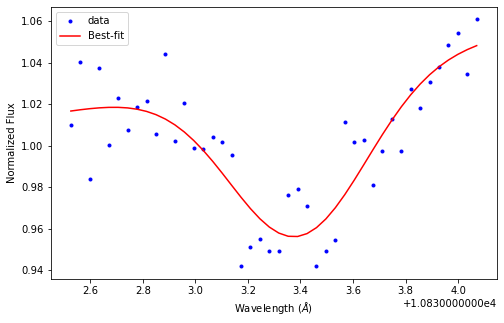

[-7.84896025e-02 -6.24011270e+01  1.08333309e+04  2.98838836e-01
  5.85333919e-03]


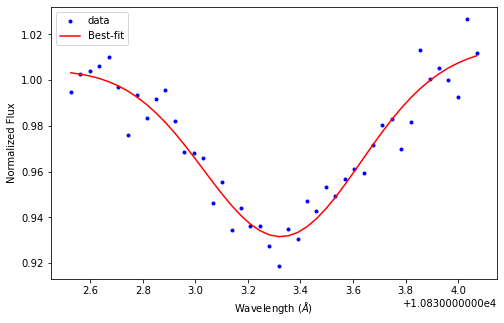

[-8.03882880e-02 -4.14465682e+01  1.08333392e+04  2.21278532e-01
  3.91830228e-03]


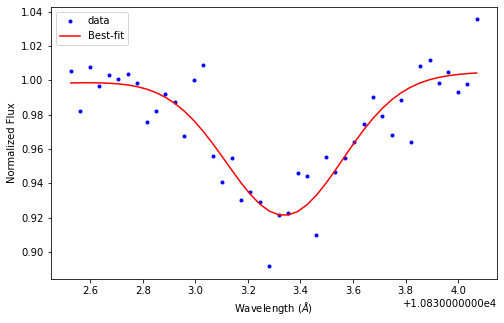

[-8.17970174e-02 -1.79302045e+02  1.08334125e+04  3.56629628e-01
  1.66451687e-02]


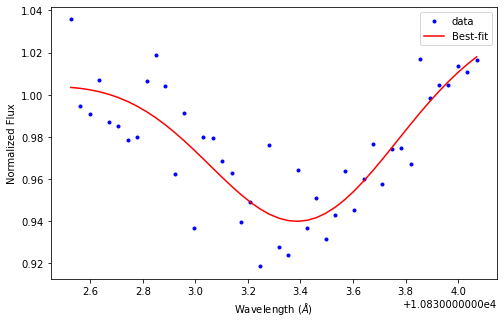

[-7.80047922e-02 -1.00515963e+02  1.08333081e+04  2.69455531e-01
  9.37117586e-03]


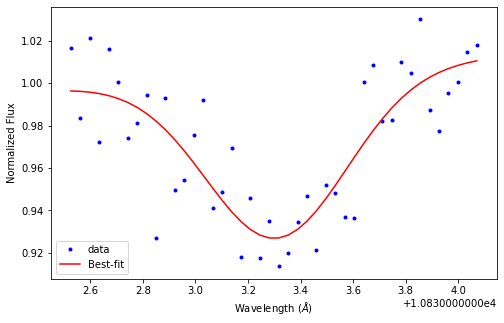

[-8.97539098e-02 -2.96579971e+02  1.08333657e+04  2.89545623e-01
  2.74712671e-02]


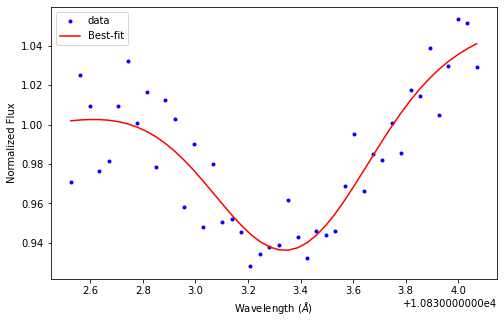

[-6.94189296e-02 -1.81761263e+02  1.08333524e+04  2.68738901e-01
  1.68711303e-02]


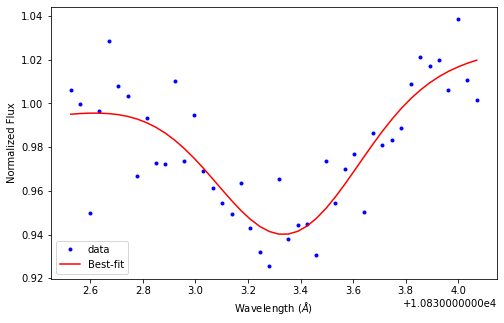

[-7.41986274e-02 -7.61632790e+01  1.08333069e+04  3.12548699e-01
  7.12406576e-03]


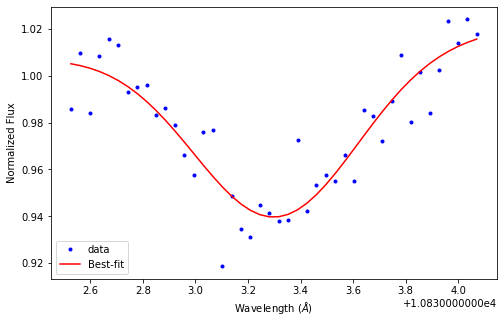

[-7.68010000e-02 -5.95182657e+01  1.08333135e+04  2.32727370e-01
  5.58681483e-03]


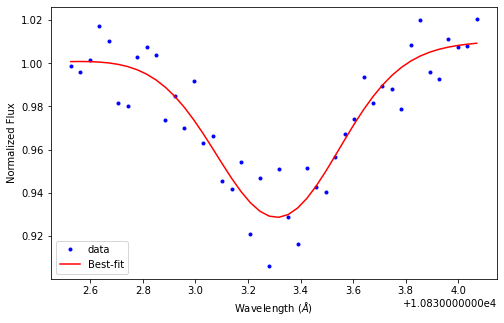

[-7.39997473e-02 -5.07113103e+01  1.08332886e+04  3.08161427e-01
  4.77366370e-03]


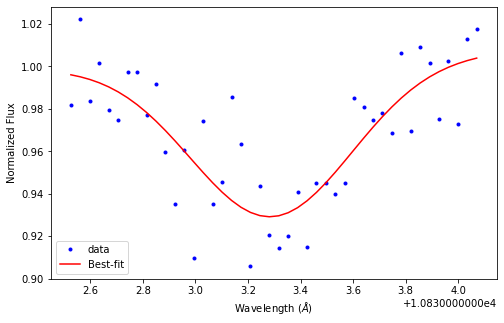

[-8.90851978e-02 -1.10463505e+02  1.08333016e+04  2.34617958e-01
  1.02890736e-02]


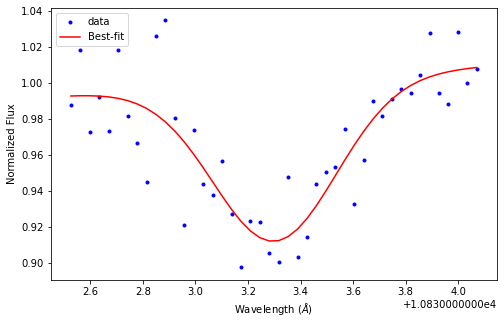

[-8.28604983e-02 -1.06458230e+02  1.08333380e+04  2.58061632e-01
  9.92138413e-03]


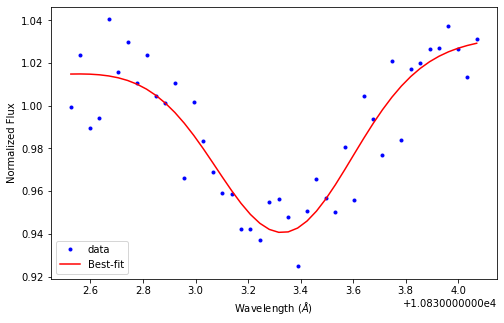

[-7.55775769e-02 -1.16642533e+02  1.08333204e+04  2.29739863e-01
  1.08600892e-02]


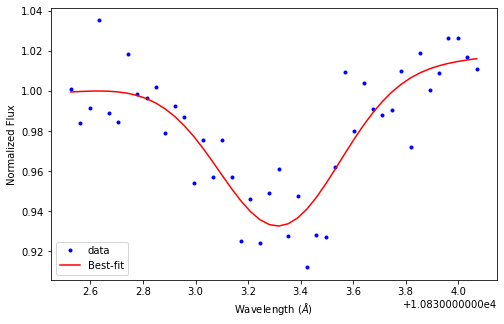

[-7.70700863e-02 -4.36109553e+01  1.08332987e+04  2.46769825e-01
  4.11948875e-03]


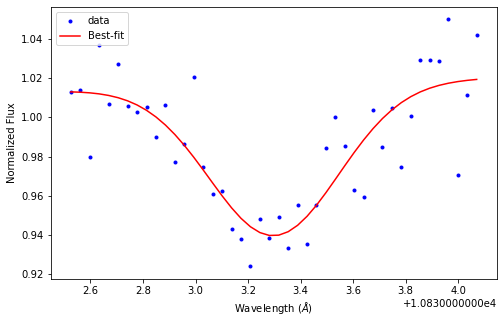

[-8.61039923e-02  1.19999878e+01  1.08333231e+04  2.16125094e-01
 -1.01389122e-03]


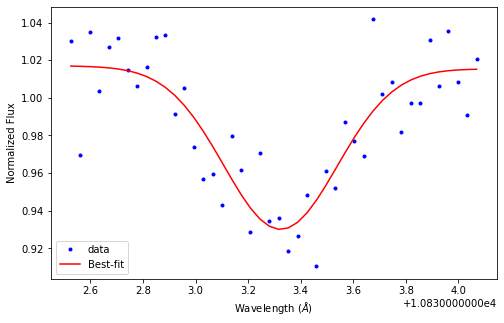

[-7.41287535e-02 -9.41833020e+01  1.08333784e+04  2.00634116e-01
  8.78682213e-03]


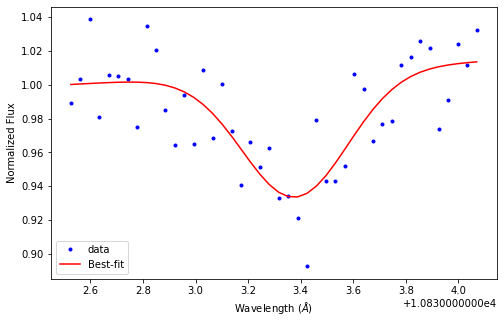

[-7.80471247e-02 -1.64896057e+02  1.08333280e+04  2.26902465e-01
  1.53146858e-02]


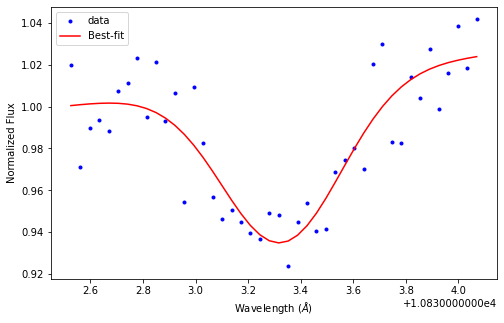

[-7.30178925e-02 -1.30742920e+02  1.08333257e+04  2.68022960e-01
  1.21622642e-02]


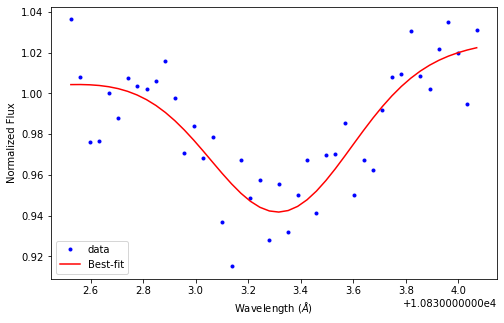

[-7.91601079e-02 -1.29681804e+02  1.08333752e+04  2.12695657e-01
  1.20636713e-02]


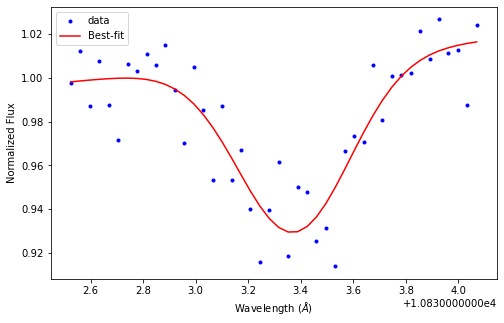

[-8.47562008e-02 -9.13224211e+01  1.08333225e+04  2.01594496e-01
  8.52219039e-03]


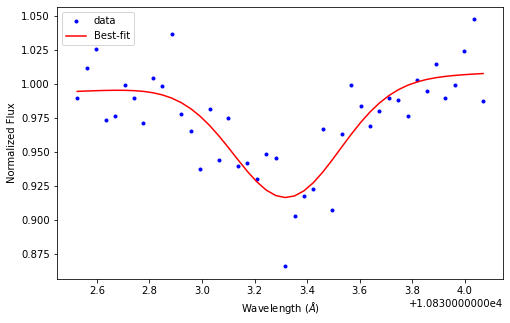

[-2.61516408e-01 -2.44495689e+02  1.08333675e+04  8.99812951e-01
  2.26813642e-02]


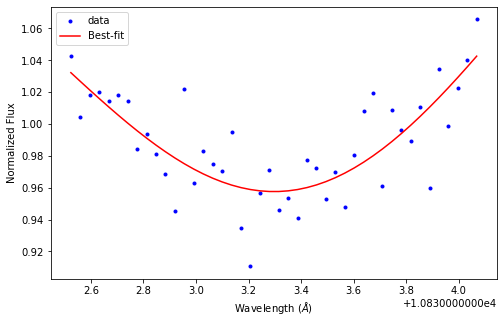

[-9.53388281e-02 -1.79125616e+02  1.08333532e+04  2.31202545e-01
  1.66293577e-02]


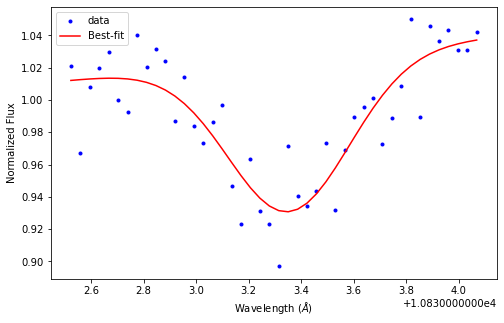

[-8.45893645e-02 -2.13137052e+02  1.08333214e+04  2.89571681e-01
  1.97688529e-02]


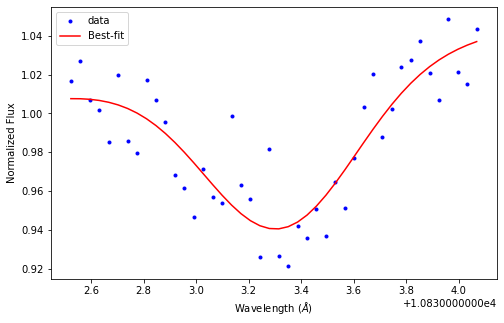

[-9.41602573e-02 -1.78151110e+02  1.08333442e+04  3.28466144e-01
  1.65399143e-02]


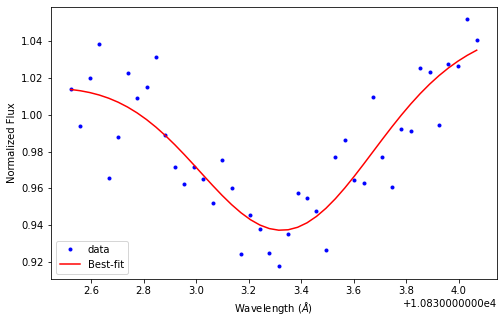

[-1.07966790e-01 -3.36810683e+02  1.08334254e+04  3.78201666e-01
  3.11871975e-02]


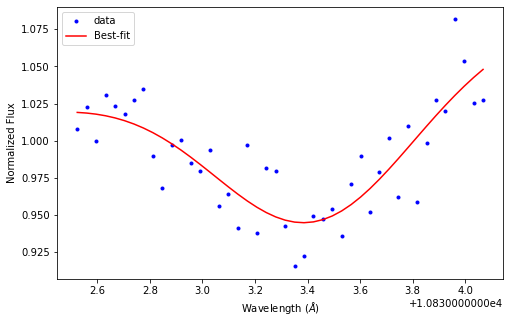

[-7.62161109e-02 -9.56606104e+01  1.08333080e+04  3.49531280e-01
  8.92491319e-03]


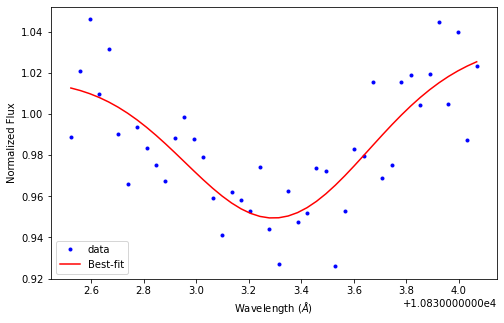

[-6.80669250e-02  1.19998140e+01  1.08332719e+04  1.78432201e-01
 -1.01523644e-03]


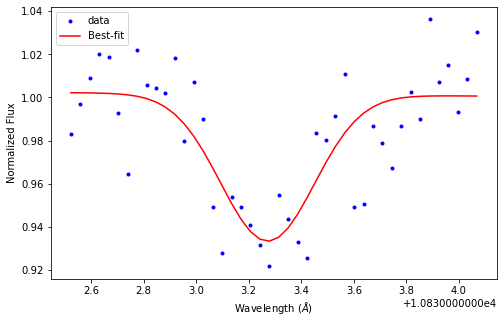

[-8.93297369e-02 -5.60824436e+01  1.08333172e+04  2.08181774e-01
  5.27068611e-03]


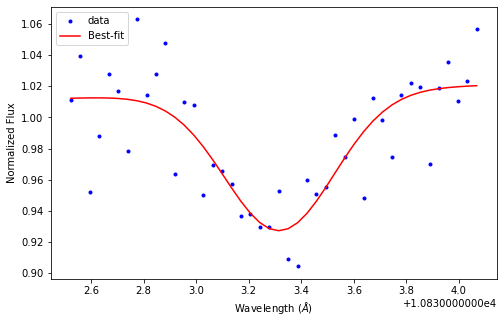

[-7.93817564e-02 -1.21119268e+02  1.08333675e+04  2.87937632e-01
  1.12746534e-02]


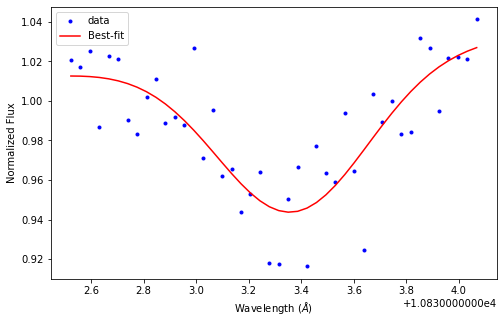

[-7.38454430e-02 -3.45494060e+01  1.08333114e+04  2.67738369e-01
  3.28319921e-03]


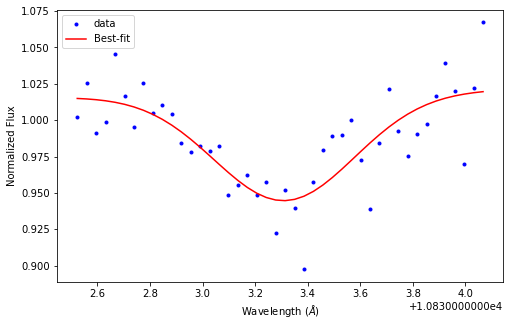

[-8.11358496e-02 -1.05074689e+02  1.08333314e+04  2.47334338e-01
  9.79328626e-03]


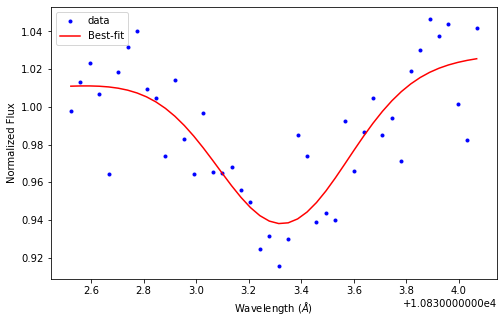

[-8.20634079e-02 -1.30369797e+02  1.08333356e+04  3.56893153e-01
  1.21297968e-02]


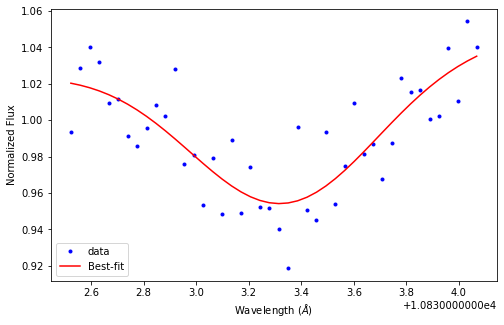

[-7.21196016e-02 -4.67122204e+01  1.08333229e+04  2.13395251e-01
  4.40527375e-03]


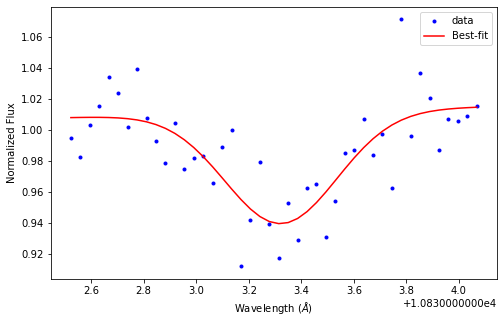

[-8.25553815e-02 -5.86709472e+01  1.08334011e+04  3.66114425e-01
  5.51146825e-03]


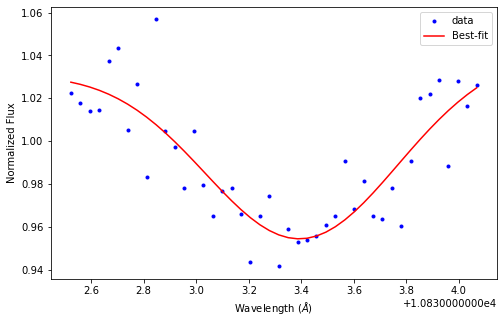

[-7.78739411e-02 -1.51683687e+02  1.08333345e+04  3.04851432e-01
  1.40956382e-02]


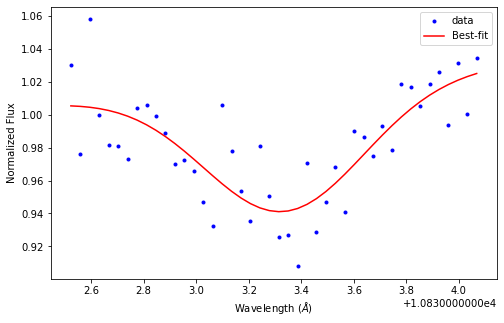

[-7.65140194e-02 -1.35954240e+02  1.08333540e+04  2.33633611e-01
  1.26437354e-02]


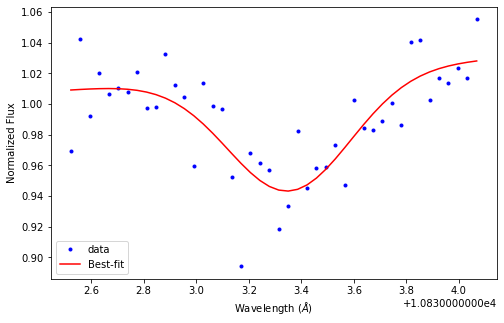

[-8.58518711e-02 -2.22807554e+02  1.08333515e+04  3.26752704e-01
  2.06620214e-02]


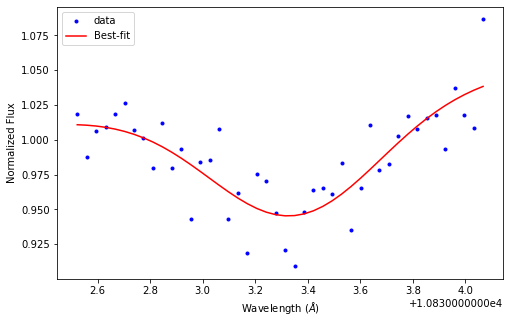

[-7.50116814e-02 -1.05443769e+02  1.08333937e+04  2.41704701e-01
  9.82645547e-03]


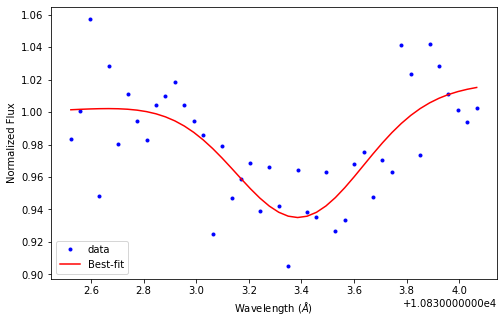

[-7.71386568e-02  1.20000000e+01  1.08333233e+04  2.19849376e-01
 -1.01403792e-03]


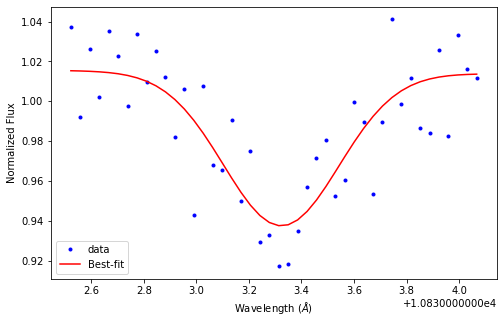

[-7.66529264e-02 -1.28550886e+01  1.08333504e+04  2.29698138e-01
  1.27975284e-03]


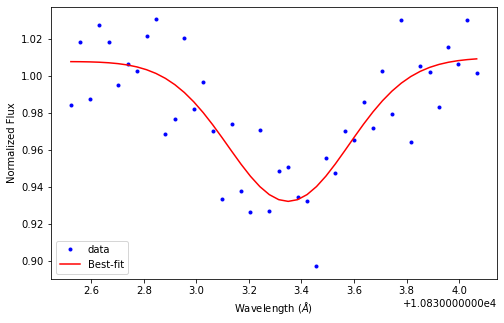

[-8.58990297e-02 -5.34954035e+01  1.08333772e+04  3.14437394e-01
  5.03287972e-03]


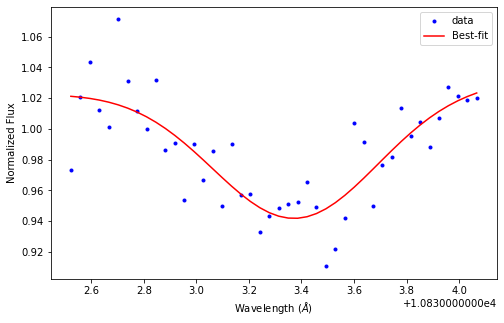

[-9.09462916e-02 -1.71480342e+02  1.08333613e+04  2.87551786e-01
  1.59239895e-02]


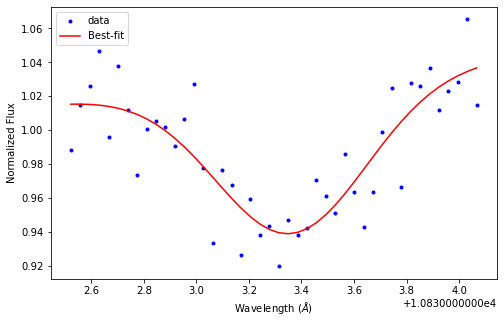

[-8.28658568e-02 -6.96996979e+01  1.08333192e+04  2.76321269e-01
  6.52797337e-03]


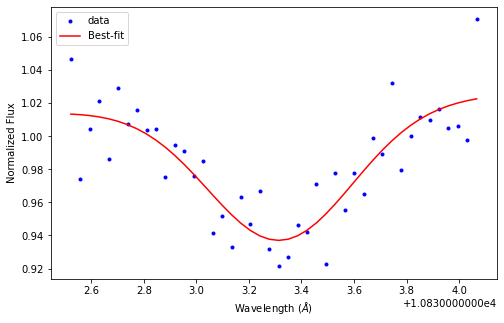

[-8.54917126e-02 -4.32805231e+01  1.08333169e+04  1.90605378e-01
  4.08829700e-03]


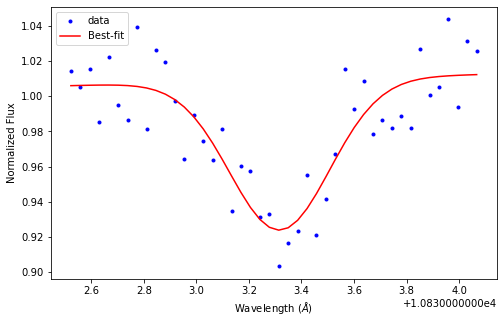

[-8.37128651e-02 -4.04535920e+01  1.08333416e+04  2.19695799e-01
  3.82737659e-03]


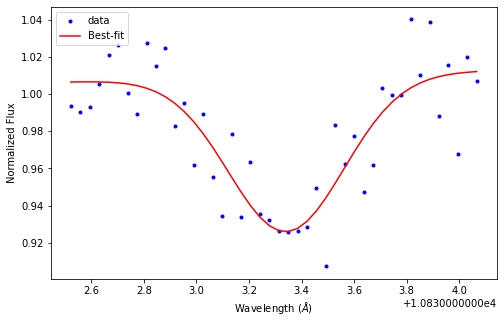

[-8.24083006e-02 -1.20897190e+02  1.08333814e+04  3.18615431e-01
  1.12545078e-02]


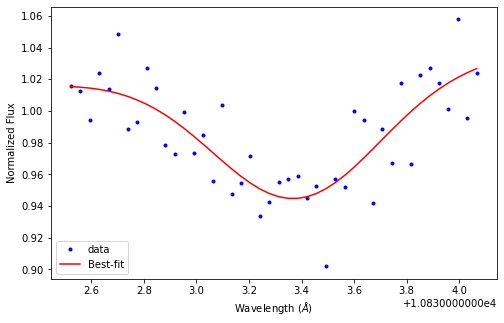

[-8.92897267e-02 -2.59579614e+02  1.08334331e+04  1.87186487e-01
  2.40541383e-02]


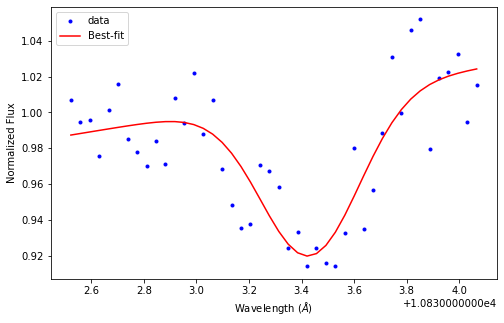

[-7.97841903e-02 -3.77650148e+01  1.08332501e+04  2.25364990e-01
  3.57925120e-03]


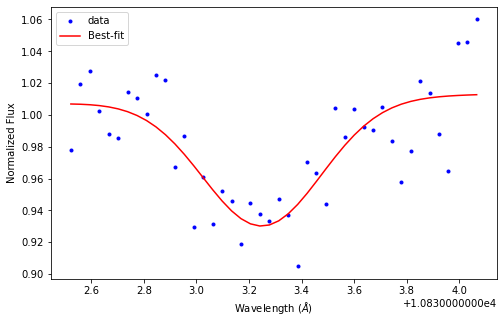

[-8.49137860e-02 -2.87158442e+02  1.08333826e+04  2.18672001e-01
  2.66003340e-02]


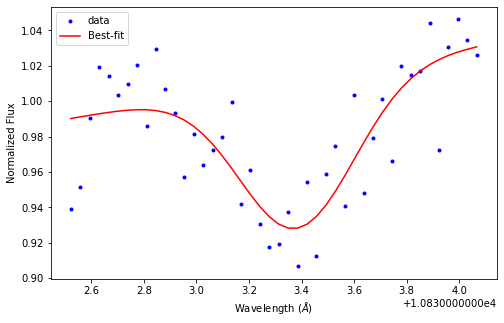

[-7.17481273e-02 -8.93397731e+01  1.08332850e+04  2.67721041e-01
  8.34078236e-03]


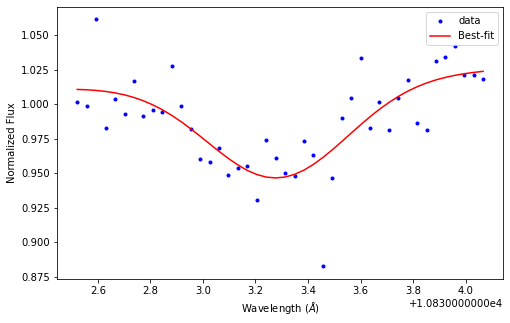

[-8.60226640e-02 -7.21505578e+01  1.08333241e+04  1.94867360e-01
  6.75356689e-03]


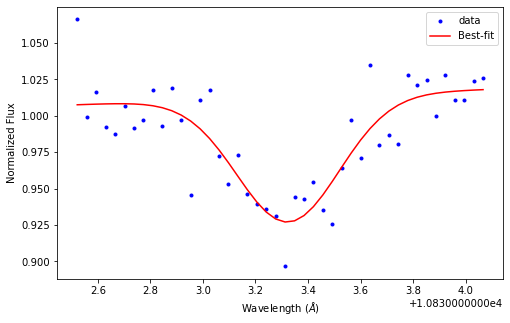

[-7.85772372e-02  1.20000000e+01  1.08332644e+04  2.56416562e-01
 -1.01400015e-03]


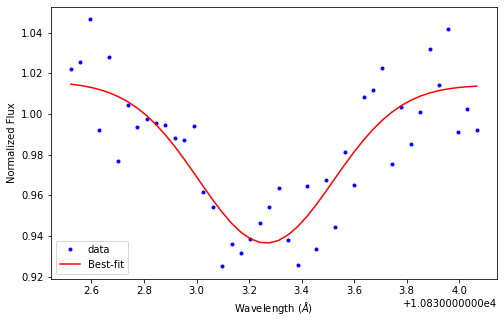

[-1.03253353e-01 -1.77630893e+02  1.08333825e+04  2.94946727e-01
  1.64922137e-02]


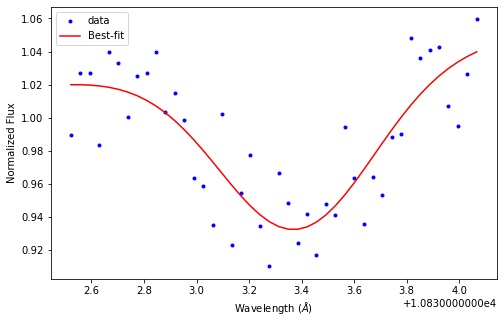

[-8.10180822e-02 -7.28135602e+01  1.08333104e+04  3.34006396e-01
  6.81612111e-03]


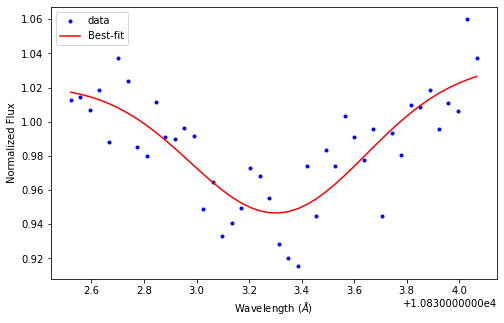

[-9.26177338e-02 -1.14109217e+02  1.08333223e+04  2.40982249e-01
  1.06264864e-02]


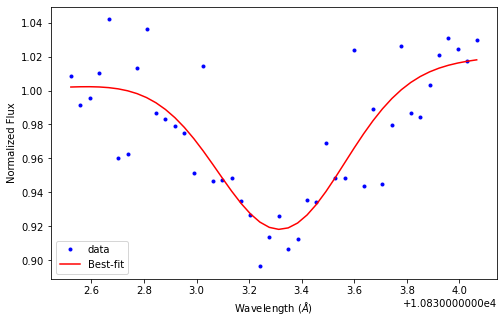

[-6.95490429e-02 -6.37087098e+00  1.08333068e+04  1.85899442e-01
  6.81171837e-04]


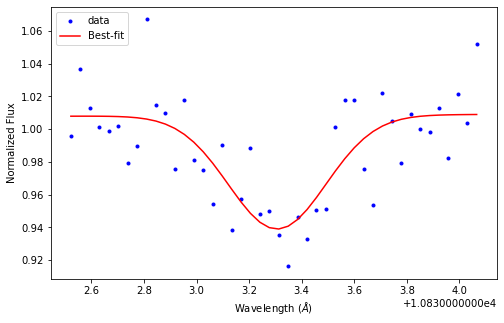

[-8.19877846e-02 -5.90889889e+01  1.08333502e+04  2.59648662e-01
  5.54818337e-03]


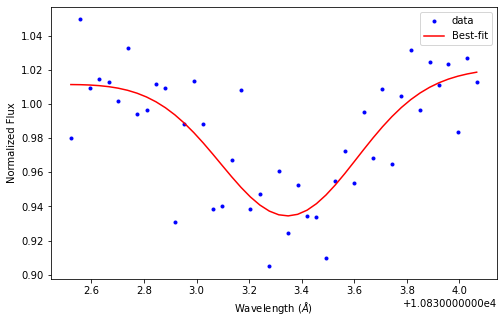

[-9.43237062e-02  1.19999959e+01  1.08332957e+04  1.83371602e-01
 -1.01383835e-03]


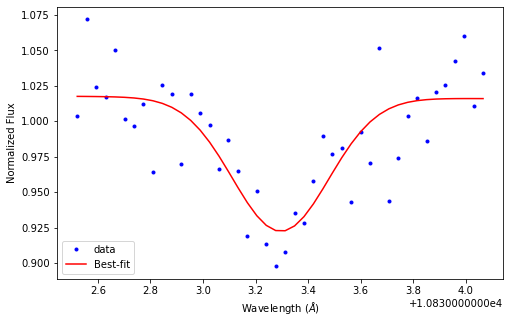

[-7.52563514e-02 -3.70893833e+02  1.08334059e+04  2.75848947e-01
  3.43296638e-02]


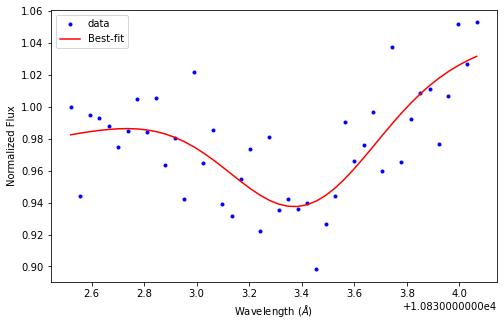

[-2.33751062e-01 -3.66416071e+02  1.08334416e+04  8.76728018e-01
  3.39325992e-02]


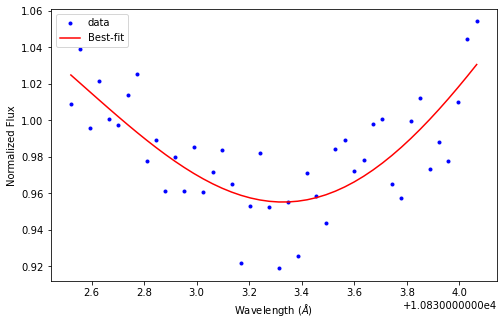

[-7.68539717e-02 -3.56787023e+01  1.08333217e+04  2.25511759e-01
  3.38646324e-03]


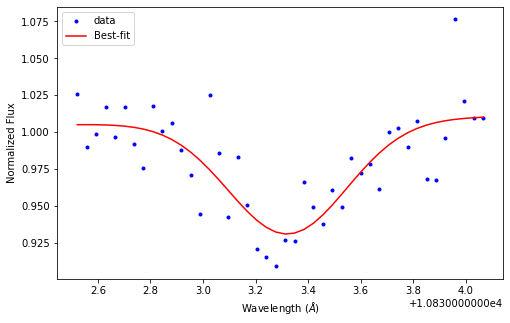

[-7.49355194e-02  1.20000000e+01  1.08332983e+04  2.38285404e-01
 -1.01428978e-03]


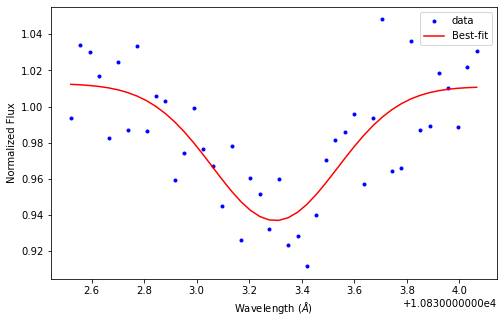

[-8.25744169e-02 -2.28942812e+02  1.08333350e+04  2.39606509e-01
  2.12273933e-02]


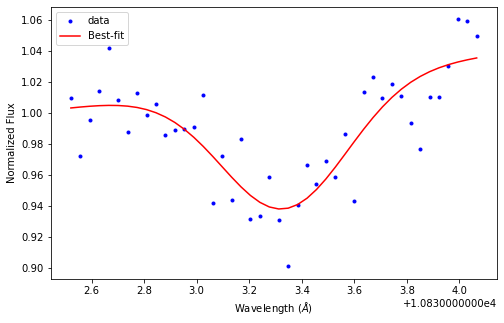

[-8.45899769e-02  1.20000000e+01  1.08333152e+04  2.70313714e-01
 -1.01372735e-03]


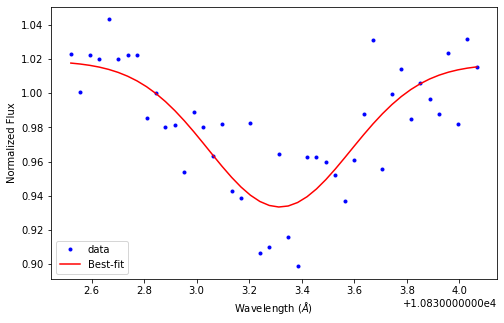

[-7.68764015e-02 -6.03114334e+01  1.08332884e+04  2.45543804e-01
  5.66141071e-03]


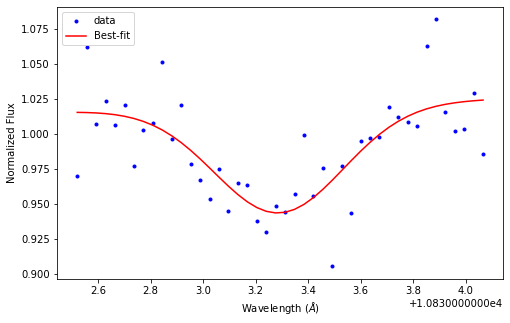

[-8.05204462e-02 -1.56169109e+02  1.08333302e+04  2.62937322e-01
  1.45094388e-02]


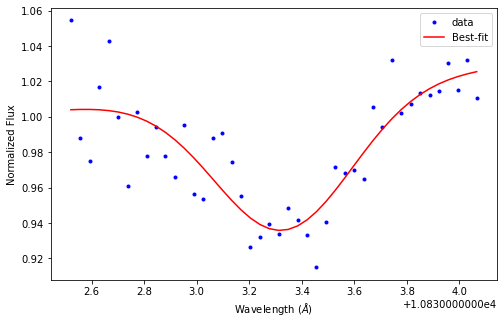

[-8.67323505e-02  1.19999692e+01  1.08332933e+04  2.66236395e-01
 -1.01358883e-03]


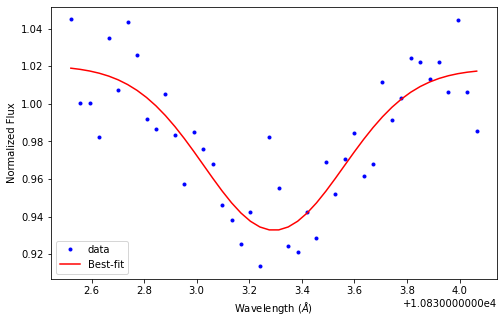

[-6.34013260e-02  1.19999999e+01  1.08333557e+04  1.52925245e-01
 -1.01544348e-03]


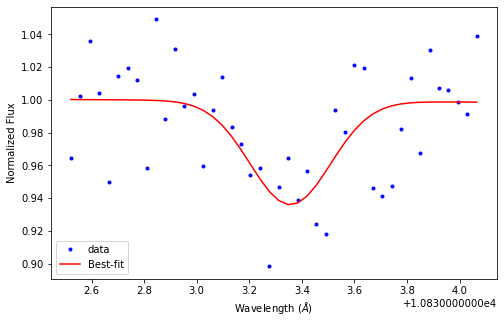

[-1.00935359e-01 -1.18591587e+02  1.08333779e+04  3.25781861e-01
  1.10431981e-02]


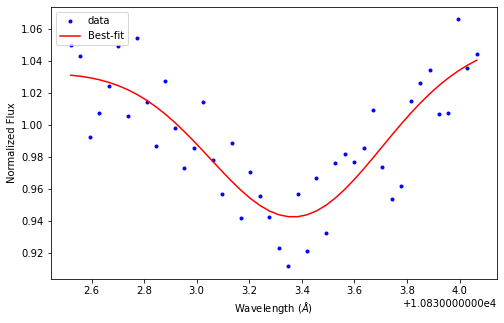

[-9.33399032e-02 -1.22014508e+02  1.08333430e+04  1.69502159e-01
  1.13563902e-02]


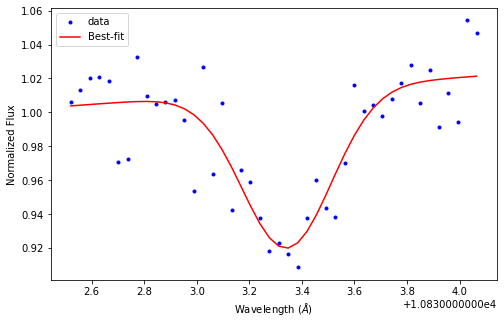

[-8.00259742e-02 -4.64684790e+01  1.08333304e+04  1.34970573e-01
  4.38197488e-03]


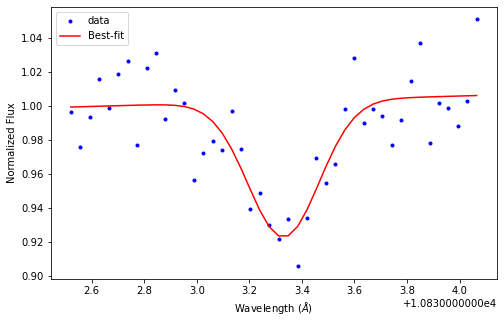

[-8.44340239e-02 -6.04155840e+01  1.08333249e+04  2.27434780e-01
  5.67071270e-03]


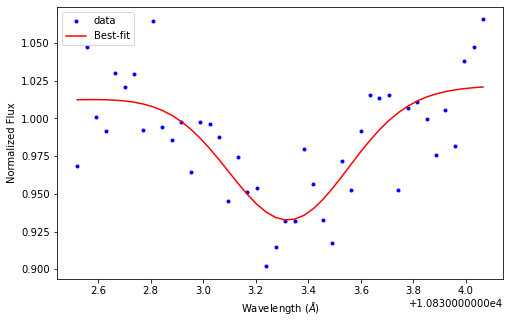

[-9.21005802e-02 -4.54964208e+01  1.08333415e+04  2.96292111e-01
  4.29461010e-03]


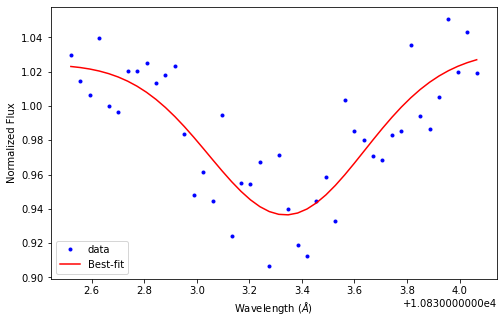

[-9.28390351e-02 -6.17483737e+01  1.08332981e+04  2.36222401e-01
  5.79381730e-03]


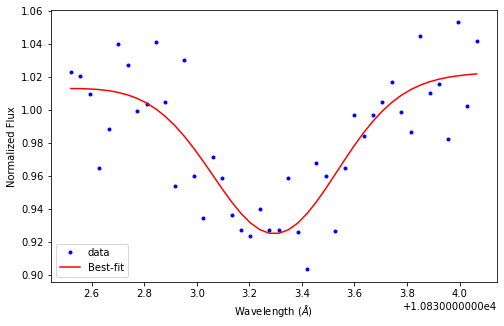

[-8.10865757e-02 -2.96683307e+02  1.08333777e+04  2.71956005e-01
  2.74802502e-02]


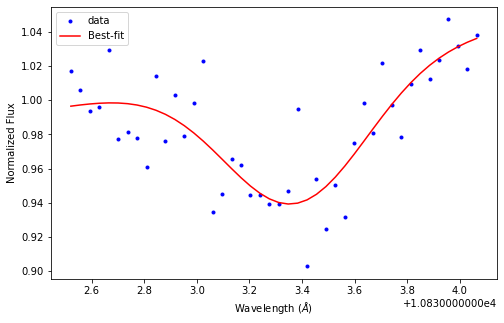

[-6.48896035e-02 -1.00533954e+02  1.08332937e+04  3.37491532e-01
  9.37392937e-03]


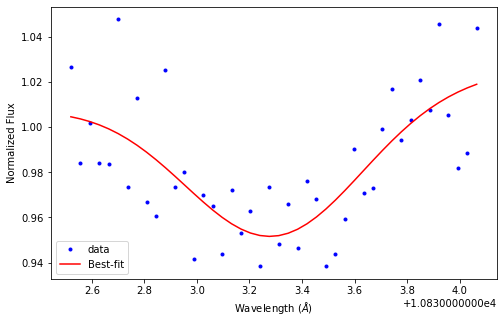

[-7.06305996e-02  1.19999999e+01  1.08333318e+04  2.18828507e-01
 -1.01451640e-03]


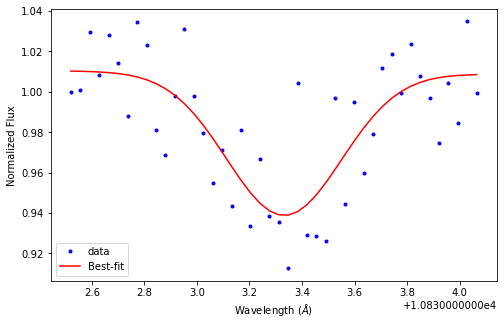

[-6.43581564e-02 -2.41652605e+02  1.08333374e+04  2.63591571e-01
  2.23993313e-02]


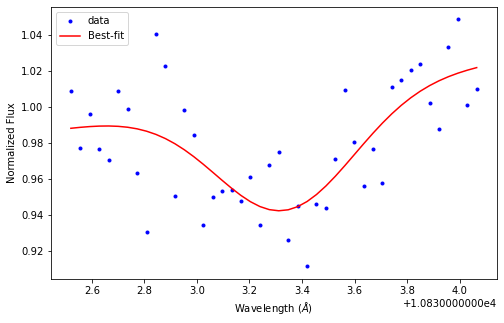

[-6.10191065e-02  1.19999921e+01  1.08332995e+04  3.26660914e-01
 -1.01376891e-03]


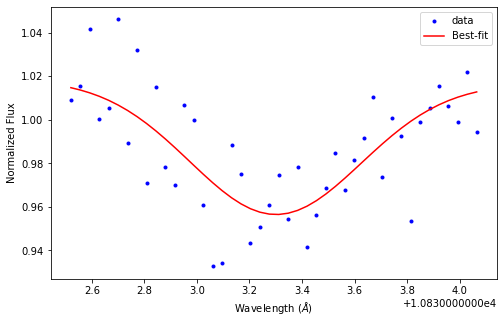

[-7.62720276e-02  1.19999999e+01  1.08332707e+04  2.79818837e-01
 -1.01428700e-03]


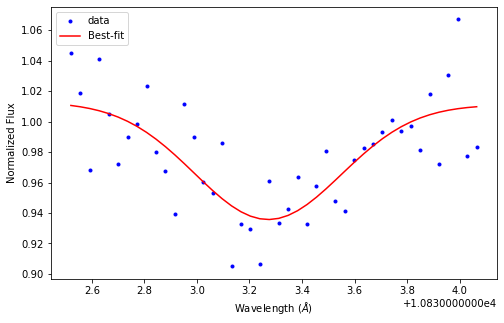

[-8.94690182e-02 -3.38291422e+02  1.08333922e+04  4.14033452e-01
  3.13232611e-02]


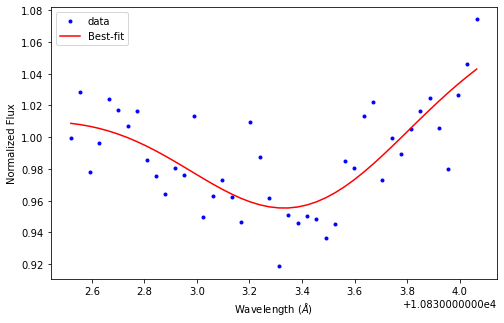

[-8.03987750e-02  1.20000000e+01  1.08332997e+04  1.35534829e-01
 -1.01515433e-03]


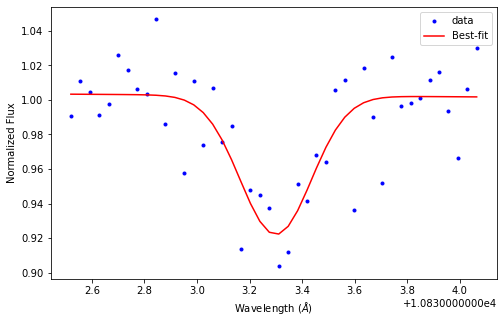

[-7.12418295e-02 -7.52234779e+01  1.08332973e+04  2.43955801e-01
  7.03723259e-03]


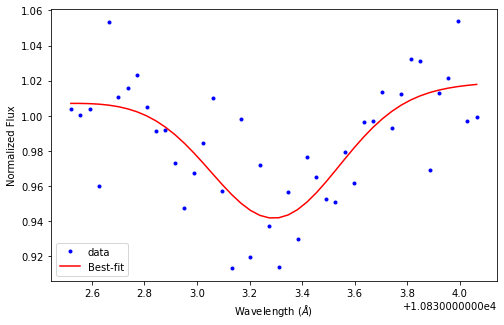

[-5.85020332e-02 -2.10183264e+02  1.08333252e+04  2.62045428e-01
  1.94949231e-02]


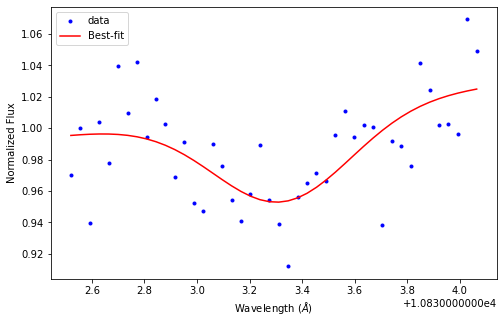

[-6.80846846e-02 -9.83609807e+01  1.08333328e+04  1.98150276e-01
  9.17292310e-03]


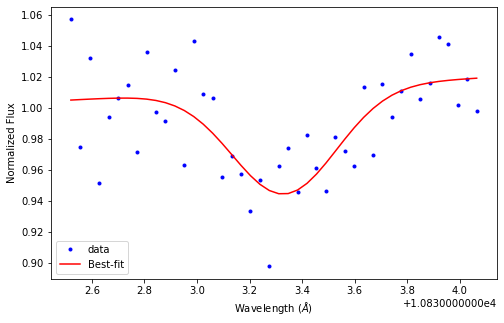

In [41]:
reload(AF)

lower_lim_T = 10832.5
upper_lim_T = 10834.1

guess_params_T = [-0.08, 10, 10833.3, 0.1, -0.005]
bounds_param_T = ((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf),(1, 12, np.inf, np.inf, np.inf)) 

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    theta_T_HA, err_theta_T_HA = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                               bounds_param_T, total_lamda_HA, total_telluric_HA,[], 'r', False)

    theta_T_HE, err_theta_T_HE = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                               bounds_param_T, total_lamda_HE, total_telluric_HE,[], 'k', False)
#If there is one mode of observation
else:
    theta_T, err_theta_T = AF.fit_spctr_line(AF.gaussian_L, AF.eval_gaussian_L, lower_lim_T, upper_lim_T, guess_params_T, 
                                               bounds_param_T, total_lamda, total_norm_spctr, [], 'r', False)


## Plotting the time series of the position, width and depth of this line

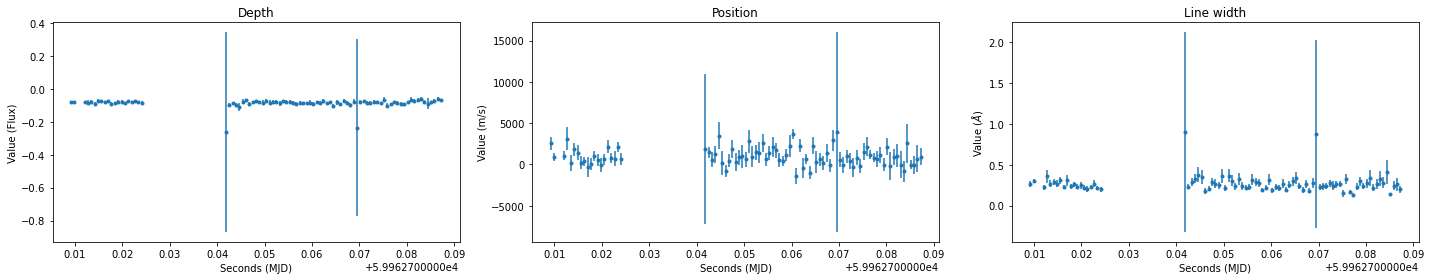

In [42]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ax1.errorbar(date_HA, theta_T_HA[:, 0], yerr=err_theta_T_HA[:, 0], fmt='.')
    ax2.errorbar(date_HA, (theta_T_HA[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T_HA[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date_HA, theta_T_HA[:, 3], yerr=err_theta_T_HA[:, 3], fmt='.')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth for HA')
    ax2.set_title('Position for HA')
    ax3.set_title('Line width for HA')
    fig.tight_layout()
    plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit_HA.pdf')
    plt.show()

    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[20, 4])

    ax4.errorbar(date_HE, theta_T_HE[:, 0], yerr=err_theta_T_HE[:, 0], fmt='.')
    ax5.errorbar(date_HE, (theta_T_HE[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T_HE[:, 2]*3e8/ref_He, fmt='.')
    ax6.errorbar(date_HE, theta_T_HE[:, 3], yerr=err_theta_T_HE[:, 3], fmt='.')
    ax4.set_xlabel('Seconds (MJD)')
    ax5.set_xlabel('Seconds (MJD)')
    ax6.set_xlabel('Seconds (MJD)')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth for HE')
    ax5.set_title('Position for HE')
    ax6.set_title('Line width for HE')
    fig.tight_layout()
    plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit_HE.pdf')
    plt.show()

#If there is one mode of observation
else:
    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    ax1.errorbar(date, theta_T[:, 0], yerr=err_theta_T[:, 0], fmt='.')
    ax2.errorbar(date, (theta_T[:, 2]-ref_He)*3e8/ref_He, yerr=err_theta_T[:, 2]*3e8/ref_He, fmt='.')
    ax3.errorbar(date, theta_T[:, 3], yerr=err_theta_T[:, 3], fmt='.')
    ax1.set_xlabel('Seconds (MJD)')
    ax2.set_xlabel('Seconds (MJD)')
    ax3.set_xlabel('Seconds (MJD)')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth')
    ax2.set_title('Position')
    ax3.set_title('Line width')
    fig.tight_layout()
    plt.savefig('Plot_Results/Telluric_He_Gaussian_Fit.pdf')
    plt.show()


## Plotting the time series of the air mass and fitting a poynomial

/var/folders/zb/dzv8y8kn1dl5qhcybvz_4nv00000gn/T/ipykernel_81696/2101900089.py:10: RankWarning: Polyfit may be poorly conditioned
  AF.plot_TS_Periodo(date, total_AIRM, [], 'Air Mass', 'Air Mass', '', fit=True, order=4)


           4             3         2
1.582e-09 x - 4.745e-05 x - 5.689 x - 1.706e+05 x + 2.046e+10


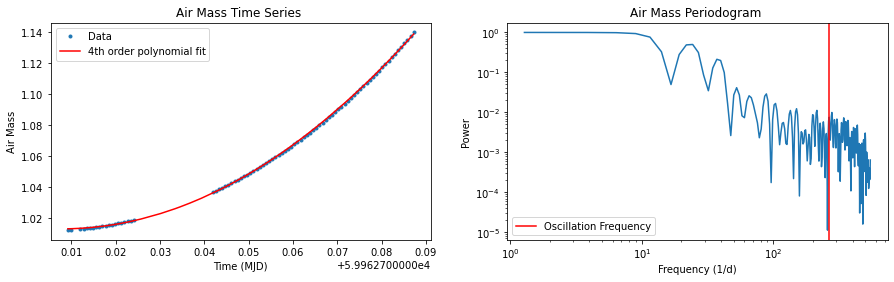

In [43]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_AIRM_HA, [], 'Air Mass', 'Air Mass', '(HA)', fit=True, order=4)
    
    AF.plot_TS_Periodo(date_HE, total_AIRM_HE, [], 'Air Mass', 'Air Mass', '(HE)', fit=True, order=4)
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_AIRM, [], 'Air Mass', 'Air Mass', '', fit=True, order=4)

## Detrending the air mass from the CO2 IWV

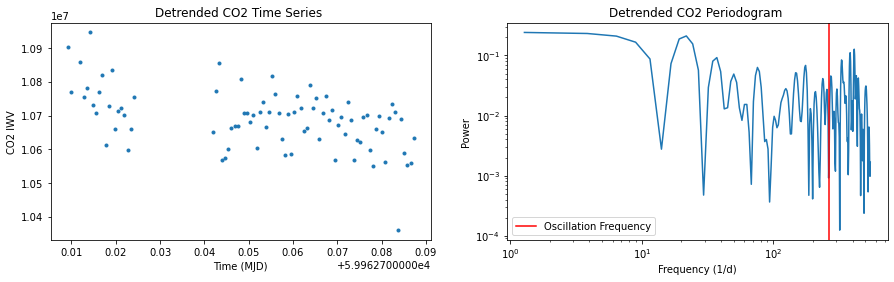

In [44]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_CO2_HA/total_AIRM_HA, [], 'CO2 IWV', 'Detrended CO2', '(HA)')
    
    AF.plot_TS_Periodo(date_HE, total_CO2_HE/total_AIRM_HE, [], 'Air Mass', 'Detrended CO2', '(HE)')
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_CO2/total_AIRM, [], 'CO2 IWV', 'Detrended CO2', '')

## Detrending the air mass from the H2O IWV

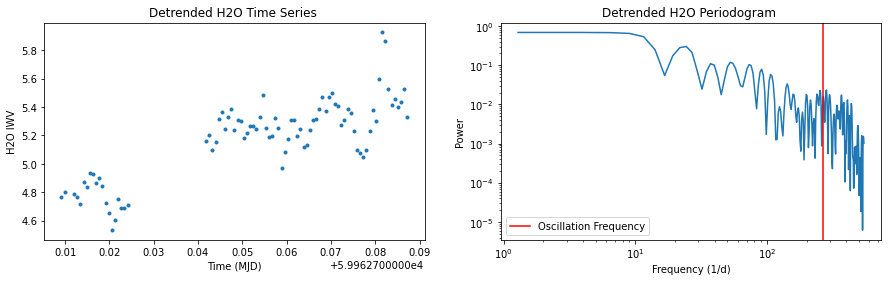

In [45]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    AF.plot_TS_Periodo(date_HA, total_H2O_HA/total_AIRM_HA, [], 'H2O IWV', 'Detrended H2O', '(HA)')
    
    AF.plot_TS_Periodo(date_HE, total_H2O_HE/total_AIRM_HE, [], 'Air Mass', 'Detrended H2O', '(HE)')
#If there is one mode of observation.
else:
    AF.plot_TS_Periodo(date, total_H2O/total_AIRM, [], 'H2O IWV', 'Detrended H2O', '')

## Plotting the correlation between H2O IWV and the position, depth and width of the He triplet (not the one fit from the telluric spectra but the one fit from the spectra where TC was applied)

In [46]:
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    depth_A = np.abs(theta_HA[:,1])[np.argsort(date_HA)]
    pos_A = theta_HA[:,2][np.argsort(date_HA)]
    width_A = theta_HA[:,3][np.argsort(date_HA)]

    H2O_IWVA = total_H2O_HA/total_AIRM_HA
    H2O_IWVA = H2O_IWVA[np.argsort(date_HA)]

    depth_E = np.abs(theta_HE[:,1])[np.argsort(date_HE)]
    pos_E = theta_HE[:,2][np.argsort(date_HE)]
    width_E = theta_HE[:,3][np.argsort(date_HE)]

    H2O_IWVE = total_H2O_HE/total_AIRM_HE
    H2O_IWVE = H2O_IWVE[np.argsort(date_HE)]

#If there is one mode of observation.
else:
    depth = np.abs(theta[:,1])[np.argsort(date)]
    pos = theta[:,2][np.argsort(date)]
    width = theta[:,3][np.argsort(date)]

    H2O_IWV = total_H2O/total_AIRM
    H2O_IWV = H2O_IWV[np.argsort(date)]


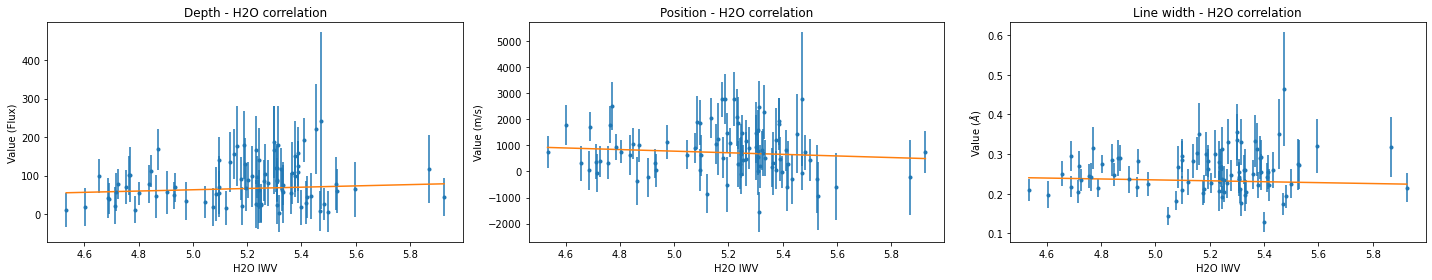

Depth polynomial:  
16.75 x - 20.58 
 Position polynomial:  
-305.8 x + 2305 
 Width polynomial:  
-0.01157 x + 0.2929
Position correlation: -0.10996219757841552
Depth correlation: 0.19235216898948174
Width correlation 0.13253535566993702


In [47]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation.
#If there are two modes of observation.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2OA = np.linspace(min(H2O_IWVA), max(H2O_IWVA), 1000)

    m_depthA = np.poly1d(np.polyfit(H2O_IWVA, depth_A, 1, w = 1/err_theta_HA[:,1][np.argsort(date_HA)]))
    m_posA = np.poly1d(np.polyfit(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He, 1, w = 1/(err_theta_HA[:,2][np.argsort(date_HA)]*3e8/ref_He)))
    m_widthA = np.poly1d(np.polyfit(H2O_IWVA, width_A, 1, w = 1/err_theta_HA[:,3][np.argsort(date_HA)]))

    ax1.errorbar(H2O_IWVA, depth_A, yerr = err_theta_HA[:,1][np.argsort(date_HA)], fmt='.')
    ax1.plot(x_H2OA, m_depthA(x_H2OA))
    ax2.errorbar(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He, yerr = err_theta_HA[:,2][np.argsort(date_HA)]*3e8/ref_He, fmt='.')
    ax2.plot(x_H2OA, m_posA(x_H2OA))
    ax3.errorbar(H2O_IWVA, width_A, yerr = err_theta_HA[:,3][np.argsort(date_HA)], fmt='.')
    ax3.plot(x_H2OA, m_widthA(x_H2OA))
    ax1.set_xlabel('H2O IWV')
    ax2.set_xlabel('H2O IWV')
    ax3.set_xlabel('H2O IWV')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth - H2O correlation (HA)')
    ax2.set_title('Position - H2O correlation (HA)')
    ax3.set_title('Line width - H2O correlation (HA)')
    
    fig.tight_layout()
    plt.savefig('Plot_Results/Correlation_HA.pdf')
    plt.show()

    print('Depth polynomial:',m_depthA,'\n','Position polynomial:',m_posA,'\n','Width polynomial:',m_widthA)
    print('Depth correlation:', np.corrcoef(H2O_IWVA, depth_A)[0][1])
    print('Position correlation:', np.corrcoef(H2O_IWVA, (pos_A-ref_He)*3e8/ref_He)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWVA, width_A)[0][1])

    
    fig, (ax4, ax5, ax6) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2OE = np.linspace(min(H2O_IWVE), max(H2O_IWVE), 1000)

    m_depthE = np.poly1d(np.polyfit(H2O_IWVE, depth_E, 1, w = 1/err_theta_HE[:,1][np.argsort(date_HE)]))
    m_posE = np.poly1d(np.polyfit(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He, 1, w = 1/(err_theta_HE[:,2][np.argsort(date_HE)]*3e8/ref_He)))
    m_widthE = np.poly1d(np.polyfit(H2O_IWVE, width_E, 1, w = 1/err_theta_HE[:,3][np.argsort(date_HE)]))

    ax4.errorbar(H2O_IWVE, depth_E, yerr=err_theta_HE[:, 1][np.argsort(date_HE)], fmt='.')
    ax4.plot(x_H2OE, m_depthE(x_H2OE))
    ax5.errorbar(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He, yerr=err_theta_HE[:, 2][np.argsort(date_HE)]*3e8/ref_He, fmt='.')
    ax5.plot(x_H2OE, m_posE(x_H2OE))
    ax6.errorbar(H2O_IWVE, width_E, yerr=err_theta_HE[:, 3][np.argsort(date_HE)], fmt='.')
    ax6.plot(x_H2OE, m_widthE(x_H2OE))
    ax4.set_xlabel('H2O IWV')
    ax5.set_xlabel('H2O IWV')
    ax6.set_xlabel('H2O IWV')
    ax4.set_ylabel('Value (Flux)')
    ax5.set_ylabel('Value (m/s)')
    ax6.set_ylabel('Value ($\AA$)')
    ax4.set_title('Depth - H2O correlation (HE)')
    ax5.set_title('Position - H2O correlation (HE)')
    ax6.set_title('Line width - H2O correlation (HE)')

    fig.tight_layout()
    plt.savefig('Plot_Results/Correlation_HE.pdf')
    plt.show()

    print('Depth polynomial:',m_depthE,'\n','Position polynomial:',m_posE,'\n','Width polynomial:',m_widthE)
    print('Depth correlation:', np.corrcoef(H2O_IWVE, depth_E)[0][1])
    print('Position correlation:', np.corrcoef(H2O_IWVE, (pos_E-ref_He)*3e8/ref_He)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWVE, width_E)[0][1])

#If there is one mode of observation
else:

    fig, (ax1, ax2, ax3) = plt.subplots (1, 3, figsize=[20, 4])

    x_H2O = np.linspace(min(H2O_IWV), max(H2O_IWV), 1000)

    m_depth = np.poly1d(np.polyfit(H2O_IWV, depth, 1, w = 1/err_theta[:,1][np.argsort(date)]))
    m_pos = np.poly1d(np.polyfit(H2O_IWV, (pos-ref_He)*3e8/ref_He, 1, w = 1/(err_theta[:,2][np.argsort(date)]*3e8/ref_He)))
    m_width = np.poly1d(np.polyfit(H2O_IWV, width, 1, w = 1/err_theta[:,3][np.argsort(date)]))

    ax1.errorbar(H2O_IWV, depth, yerr = err_theta[:,1][np.argsort(date)], fmt='.')
    ax1.plot(x_H2O, m_depth(x_H2O))
    ax2.errorbar(H2O_IWV, (pos-ref_He)*3e8/ref_He, yerr = err_theta[:,2][np.argsort(date)]*3e8/ref_He, fmt='.')
    ax2.plot(x_H2O, m_pos(x_H2O))
    ax3.errorbar(H2O_IWV, width, yerr = err_theta[:,3][np.argsort(date)], fmt='.')
    ax3.plot(x_H2O, m_width(x_H2O))
    ax1.set_xlabel('H2O IWV')
    ax2.set_xlabel('H2O IWV')
    ax3.set_xlabel('H2O IWV')
    ax1.set_ylabel('Value (Flux)')
    ax2.set_ylabel('Value (m/s)')
    ax3.set_ylabel('Value ($\AA$)')
    ax1.set_title('Depth - H2O correlation')
    ax2.set_title('Position - H2O correlation')
    ax3.set_title('Line width - H2O correlation')
    
    fig.tight_layout()
    plt.savefig('Plot_Results/Correlation.pdf')
    plt.show()
   
    print('Depth polynomial:',m_depth,'\n','Position polynomial:',m_pos,'\n','Width polynomial:',m_width)
    print('Position correlation:', np.corrcoef(H2O_IWV, (pos-ref_He)*3e8/ref_He)[0][1])
    print('Depth correlation:', np.corrcoef(H2O_IWV, depth)[0][1])
    print('Width correlation', np.corrcoef(H2O_IWV, width)[0][1])
    
